In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
from utilityFunctions import *

from style_encoder import StyleEncoder
from content_encoder import ContentEncoder
from discriminator import Discriminator
from new_decoder import Decoder, compute_comprehensive_loss
from losses import (infoNCE_loss, margin_loss, adversarial_loss, 
                   disentanglement_loss)
from dataloader import get_dataloader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")


Using device: cuda
GPU: NVIDIA GeForce RTX 3080


In [2]:
# train parameters
config = {
    "style_dim": 256,
    "content_dim": 256,
    "transformer_heads": 4,
    "transformer_layers": 4,
    "cnn_channels": [16, 32, 64, 128, 256],
    
    # Training params
    "epochs": 100,
    "batch_size": 16,          
    "lr_gen": 3e-5,
    "lr_disc": 1e-5,
    "beta1": 0.5,
    "beta2": 0.999,
    "weight_decay": 1e-4, 
    
    # losses weights
    "lambda_adv_disc": 0.5,
    "lambda_adv_gen": 0.3,
    "lambda_disent": 0.8,
    "lambda_cont": 0.1,
    "lambda_margin": 0.05,
    "lambda_recon": 5.0,
    
    # for stability
    "grad_clip_value": 0.5, 
    "warmup_epochs": 5,
    "nan_threshold": 5,          # Max NaN consecutivi
    
    # paths
    "piano_dir": "dataset/train/piano",
    "violin_dir": "dataset/train/violin",
    "stats_path": "stats_stft_cqt.npz",
    
    # save
    "save_dir": "checkpoints",
    "save_interval": 10,
    
    # training strategy ----> EXPERIMENT WITH DIFFERENT VALUES
    "discriminator_steps": 1,
    "generator_steps": 2,
}

os.makedirs(config["save_dir"], exist_ok=True)

In [3]:
# conservative weight initialization
def init_weights_conservative(m):
    """
    Inizializzazione conservativa dei pesi per prevenire NaN
    """
    if isinstance(m, nn.Conv2d):
        # Xavier uniforme con gain ridotto
        nn.init.xavier_uniform_(m.weight, gain=0.2)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        # Xavier uniforme con gain ridotto
        nn.init.xavier_uniform_(m.weight, gain=0.2)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

# utility functions

def check_for_nan(*tensors, names=None):
    """
    Controlla se ci sono NaN o Inf nei tensori
    
    Args:
        *tensors: Tensori da controllare
        names: Nomi dei tensori per il debug
    
    Returns:
        bool: True se trovati NaN/Inf
    """
    if names is None:
        names = [f"tensor_{i}" for i in range(len(tensors))]
    
    for tensor, name in zip(tensors, names):
        if torch.isnan(tensor).any():
            print(f"🚨 NaN detected in {name}")
            return True
        if torch.isinf(tensor).any():
            print(f"🚨 Inf detected in {name}")
            return True
    return False



def set_requires_grad(models, requires_grad):
    """
    Abilita/disabilita i gradienti per i modelli
    
    Args:
        models: Modello singolo o lista di modelli
        requires_grad: True per abilitare, False per disabilitare
    """
    if not isinstance(models, list):
        models = [models]
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad



def get_learning_rate_multiplier(epoch, warmup_epochs):
    """
    Calcola il moltiplicatore del learning rate per il warmup
    
    Args:
        epoch: Epoca corrente
        warmup_epochs: Numero di epoche di warmup
    
    Returns:
        float: Moltiplicatore del learning rate
    """
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    return 1.0

def save_checkpoint(epoch, models_dict, optimizers_dict, schedulers_dict, config):
    """
    Salva checkpoint completo
    
    Args:
        epoch: Epoca corrente
        models_dict: Dizionario dei modelli
        optimizers_dict: Dizionario degli ottimizzatori
        schedulers_dict: Dizionario degli schedulers
        config: Configurazione
    """
    checkpoint = {
        'epoch': epoch,
        'config': config
    }
    
    # Salva stati dei modelli
    for name, model in models_dict.items():
        checkpoint[name] = model.state_dict()
    
    # Salva stati degli ottimizzatori
    for name, optimizer in optimizers_dict.items():
        checkpoint[name] = optimizer.state_dict()
    
    # Salva stati degli schedulers
    for name, scheduler in schedulers_dict.items():
        checkpoint[name] = scheduler.state_dict()
    
    checkpoint_path = os.path.join(config["save_dir"], f"checkpoint_epoch_{epoch}.pth")
    torch.save(checkpoint, checkpoint_path)
    print(f"💾 Checkpoint saved: {checkpoint_path}")

In [4]:
# model initialization
print("Initializing models...")

style_encoder = StyleEncoder(
    cnn_out_dim=config["style_dim"],
    transformer_dim=config["style_dim"],
    num_heads=config["transformer_heads"],
    num_layers=config["transformer_layers"]
).to(device)

content_encoder = ContentEncoder(
    cnn_out_dim=config["content_dim"],
    transformer_dim=config["content_dim"],
    num_heads=config["transformer_heads"],
    num_layers=config["transformer_layers"],
    channels_list=config["cnn_channels"]
).to(device)

discriminator = Discriminator(
    input_dim=config["style_dim"],
    hidden_dim=128
).to(device)

decoder = Decoder(
    d_model=config["style_dim"],
    nhead=config["transformer_heads"],
    num_layers=config["transformer_layers"]
).to(device)

# Applica inizializzazione conservativa
models = [style_encoder, content_encoder, discriminator, decoder]
model_names = ["style_encoder", "content_encoder", "discriminator", "decoder"]

for model, name in zip(models, model_names):
    model.apply(init_weights_conservative)
    print(f"{name} initialized")


# ottimizzazione regolare
# from style_encoder import initialize_weights
# initialize_weights(style_encoder)
# initialize_weights(content_encoder)
# initialize_weights(decoder)
# initialize_weights(discriminator)

Initializing models...
style_encoder initialized
content_encoder initialized
discriminator initialized
decoder initialized


In [5]:
# optimizers and schedulers
print("🔧 Setting up optimizers and schedulers...")

optimizer_G = optim.AdamW(
    list(style_encoder.parameters()) + 
    list(content_encoder.parameters()) + 
    list(decoder.parameters()),
    lr=config["lr_gen"],
    betas=(config["beta1"], config["beta2"]),
    weight_decay=config["weight_decay"]
)

optimizer_D = optim.AdamW(
    discriminator.parameters(),
    lr=config["lr_disc"],
    betas=(config["beta1"], config["beta2"]),
    weight_decay=config["weight_decay"]
)

# Schedulers
scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_G, mode='min', factor=0.7, patience=5
)

scheduler_D = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_D, mode='min', factor=0.7, patience=5
)

# dataloader
print("🔧 Setting up dataloader...")

try:
    train_loader = get_dataloader(
        piano_dir=config["piano_dir"],
        violin_dir=config["violin_dir"],
        batch_size=config["batch_size"],
        shuffle=True,
        stats_path=config["stats_path"]
    )
    print(f"✅ DataLoader created successfully with batch_size={config['batch_size']}")
except Exception as e:
    print(f"❌ Error creating DataLoader: {e}")
    raise

🔧 Setting up optimizers and schedulers...
🔧 Setting up dataloader...
✅ Loaded separate statistics:
  Piano: train_set_stats/stats_stft_cqt_piano.npz
  Violin: train_set_stats/stats_stft_cqt_violin.npz
✅ DataLoader created successfully with batch_size=16


## Regular training

In [ ]:
# training steps for discriminator and generator
def discriminator_training_step(x, labels, epoch):

    # only discriminator requires gradients
    set_requires_grad(discriminator, True)
    set_requires_grad([style_encoder, content_encoder, decoder], False)
    
    try:
        # no gradient flow for generators
        with torch.no_grad():
            style_emb, class_emb = style_encoder(x, labels)
            content_emb = content_encoder(x)
        
        # NaN check
        if check_for_nan(style_emb, class_emb, content_emb, 
                         names=["style_emb", "class_emb", "content_emb"]):
            return float('nan')
        
        # detach embeddings to avoid gradient flow
        disc_loss, _ = adversarial_loss(
            style_emb.detach(),
            class_emb.detach(),
            content_emb.detach(),
            discriminator,
            labels,
            compute_for_discriminator=True,
            lambda_content=config["lambda_adv_disc"]
        )
        
        # NaN
        if check_for_nan(disc_loss, names=["disc_loss"]):
            return float('nan')
        
        # Backpropagation
        optimizer_D.zero_grad()
        disc_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), config["grad_clip_value"])
        
        # Controllo gradienti per NaN
        for name, param in discriminator.named_parameters():
            if param.grad is not None:
                if check_for_nan(param.grad, names=[f"discriminator.{name}.grad"]):
                    return float('nan')
        
        optimizer_D.step()
        return disc_loss.item()
        
    except Exception as e:
        print(f"❌ Error in discriminator training step: {e}")
        return float('nan')



def generator_training_step(x, labels, epoch):

    set_requires_grad([style_encoder, content_encoder, decoder], True)
    set_requires_grad(discriminator, False)
    
    try:

        style_emb, class_emb = style_encoder(x, labels)
        content_emb = content_encoder(x)
        

        if check_for_nan(style_emb, class_emb, content_emb,
                         names=["style_emb", "class_emb", "content_emb"]):
            return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}
        

        _, adv_gen_loss = adversarial_loss(
            style_emb,
            class_emb,
            content_emb,
            discriminator,
            labels,
            compute_for_discriminator=False,
            lambda_content=config["lambda_adv_gen"]
        )
        
        # disentanglement
        disent_loss = disentanglement_loss(
            style_emb,
            content_emb.mean(dim=1),
            use_hsic=True
        )
        
        # contrastive losses
        cont_loss = infoNCE_loss(style_emb, labels)
        
        margin_loss_val = margin_loss(class_emb)
        
        # reconstruction loss
        # get only stft from input
        stft_part = x[:, :, :, :, :513]

        # duplicate class embedding from (2,d) to (B,d)
        B = content_emb.size(0)
        class_emb = class_emb.repeat_interleave(repeats=B//2, dim=0)

        # reconstruction loss
        recon_x = decoder(content_emb, class_emb, y=stft_part)
        recon_losses = compute_comprehensive_loss(recon_x, stft_part)
        recon_loss = recon_losses['total_loss']
        
        # NaN
        losses = [adv_gen_loss, disent_loss, cont_loss, margin_loss_val, recon_loss]
        loss_names = ['adv_gen_loss', 'disent_loss', 'cont_loss', 'margin_loss', 'recon_loss']
        
        if check_for_nan(*losses, names=loss_names):
            return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}
        
        # total loss with warmup
        lr_multiplier = get_learning_rate_multiplier(epoch, config["warmup_epochs"])
        warmup_factor = lr_multiplier if epoch < config["warmup_epochs"] else 1.0
        
        total_G_loss = (
            config["lambda_adv_gen"] * adv_gen_loss * warmup_factor +
            config["lambda_disent"] * disent_loss * warmup_factor +
            config["lambda_cont"] * cont_loss * warmup_factor +
            config["lambda_margin"] * margin_loss_val * warmup_factor +
            config["lambda_recon"] * recon_loss
        )
        
        if check_for_nan(total_G_loss, names=["total_G_loss"]):
            return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}
        
        # Backpropagation
        optimizer_G.zero_grad()
        total_G_loss.backward()
        
        # Gradient clipping
        generator_params = (
            list(style_encoder.parameters()) + 
            list(content_encoder.parameters()) +
            list(decoder.parameters())
        )
        torch.nn.utils.clip_grad_norm_(generator_params, config["grad_clip_value"])
        
        # NaN
        for model, model_name in [(style_encoder, "style_encoder"), 
                                 (content_encoder, "content_encoder"), 
                                 (decoder, "decoder")]:
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if check_for_nan(param.grad, names=[f"{model_name}.{name}.grad"]):
                        return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}
        
        optimizer_G.step()
        
        return {
            'total_G': total_G_loss.item(),
            'adv_gen': adv_gen_loss.item(),
            'disent': disent_loss.item(),
            'cont': cont_loss.item(),
            'margin': margin_loss_val.item(),
            'recon': recon_loss.item()
        }
        
    except Exception as e:
        print(f"❌ Error in generator training step: {e}")
        return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}

🚀 Starting training with enhanced NaN protection...
📊 Configuration: {'style_dim': 256, 'content_dim': 256, 'transformer_heads': 4, 'transformer_layers': 4, 'cnn_channels': [16, 32, 64, 128, 256], 'epochs': 100, 'batch_size': 16, 'lr_gen': 3e-05, 'lr_disc': 1e-05, 'beta1': 0.5, 'beta2': 0.999, 'weight_decay': 0.0001, 'lambda_adv_disc': 0.5, 'lambda_adv_gen': 0.3, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05, 'lambda_recon': 5.0, 'grad_clip_value': 0.5, 'warmup_epochs': 5, 'nan_threshold': 5, 'piano_dir': 'dataset/train/piano', 'violin_dir': 'dataset/train/violin', 'stats_path': 'stats_stft_cqt.npz', 'save_dir': 'checkpoints', 'save_interval': 10, 'discriminator_steps': 1, 'generator_steps': 2}


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


🔄 Epoch 1/100
------------------------------------------------------------


c:\Users\Francesco\anaconda3\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)



📊 Batch 1:
   Discriminator Loss: 1.386349
   Generator Total Loss: 15.388690
     Adv Gen: -0.693146
     Disent: 0.002854
     Cont: 2.705039
     Margin: 0.054525
     Recon: 3.075035
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.380597
   Generator Total Loss: 18.543676
     Adv Gen: -0.693147
     Disent: 0.000049
     Cont: 1.972282
     Margin: 0.000000
     Recon: 3.709162
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   1%|          | 1/100 [02:23<3:56:00, 143.04s/it]


✅ Epoch 1 Summary:
----------------------------------------
   Disc: 1.383228
   Total G: 18.280889
   Adv Gen: -0.693147
   Disent: 0.000179
   Cont: 2.281578
   Margin: 0.001432
   Recon: 3.655361
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 2/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.380836
   Generator Total Loss: 16.821405
     Adv Gen: -0.693147
     Disent: 0.000044
     Cont: 2.317998
     Margin: 0.000000
     Recon: 3.362370
   Consecutive NaN count: 0
   GPU Memory: 424.5 MB

📊 Batch 26:
   Discriminator Loss: 1.368538
   Generator Total Loss: 11.866914
     Adv Gen: -0.693147
     Disent: 0.000058
     Cont: 2.720109
     Margin: 0.000000
     Recon: 2.368254
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:   2%|▏         | 2/100 [04:33<3:41:52, 135.84s/it]


✅ Epoch 2 Summary:
----------------------------------------
   Disc: 1.371519
   Total G: 16.263591
   Adv Gen: -0.693147
   Disent: 0.000056
   Cont: 2.105504
   Margin: 0.000000
   Recon: 3.252506
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 3/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.360608
   Generator Total Loss: 11.725679
     Adv Gen: -0.693147
     Disent: 0.000058
     Cont: 1.957102
     Margin: 0.000000
     Recon: 2.346599
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.344879
   Generator Total Loss: 12.704657
     Adv Gen: -0.693147
     Disent: 0.000047
     Cont: 1.953961
     Margin: 0.000000
     Recon: 2.542433
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   3%|▎         | 3/100 [06:38<3:31:35, 130.88s/it]


✅ Epoch 3 Summary:
----------------------------------------
   Disc: 1.373212
   Total G: 16.091479
   Adv Gen: -0.693147
   Disent: 0.000064
   Cont: 2.138915
   Margin: 0.000000
   Recon: 3.217576
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 4/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.421752
   Generator Total Loss: 12.158838
     Adv Gen: -0.693147
     Disent: 0.000059
     Cont: 1.965222
     Margin: 0.000000
     Recon: 2.433588
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.408286
   Generator Total Loss: 10.935494
     Adv Gen: -0.693147
     Disent: 0.000039
     Cont: 1.957564
     Margin: 0.000000
     Recon: 2.189044
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   4%|▍         | 4/100 [08:34<3:20:06, 125.06s/it]


✅ Epoch 4 Summary:
----------------------------------------
   Disc: 1.409171
   Total G: 17.515144
   Adv Gen: -0.693147
   Disent: 0.000047
   Cont: 2.030000
   Margin: 0.000000
   Recon: 3.503814
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 5/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.397571
   Generator Total Loss: 12.197311
     Adv Gen: -0.693147
     Disent: 0.000037
     Cont: 1.958681
     Margin: 0.000000
     Recon: 2.441872
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.379148
   Generator Total Loss: 12.150969
     Adv Gen: -0.693147
     Disent: 0.000035
     Cont: 1.950521
     Margin: 0.000000
     Recon: 2.432767
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   5%|▌         | 5/100 [10:31<3:12:59, 121.89s/it]


✅ Epoch 5 Summary:
----------------------------------------
   Disc: 1.382945
   Total G: 18.215813
   Adv Gen: -0.693147
   Disent: 0.000038
   Cont: 1.956224
   Margin: 0.000000
   Recon: 3.645621
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 6/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.366595
   Generator Total Loss: 15.178515
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.948594
     Margin: 0.000000
     Recon: 3.038315
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.343022
   Generator Total Loss: 11.756292
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.948456
     Margin: 0.000000
     Recon: 2.353874
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   6%|▌         | 6/100 [12:27<3:07:47, 119.87s/it]


✅ Epoch 6 Summary:
----------------------------------------
   Disc: 1.349320
   Total G: 15.516645
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.933489
   Margin: 0.000000
   Recon: 3.106243
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 7/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.330832
   Generator Total Loss: 12.435064
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.955125
     Margin: 0.000000
     Recon: 2.489494
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.306440
   Generator Total Loss: 14.187418
     Adv Gen: -0.693147
     Disent: 0.000037
     Cont: 1.948424
     Margin: 0.000000
     Recon: 2.840098
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   7%|▋         | 7/100 [14:23<3:03:48, 118.58s/it]


✅ Epoch 7 Summary:
----------------------------------------
   Disc: 1.312545
   Total G: 18.034762
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.930102
   Margin: 0.000000
   Recon: 3.609934
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 8/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.302785
   Generator Total Loss: 13.068730
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 2.059364
     Margin: 0.000000
     Recon: 2.614143
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.269098
   Generator Total Loss: 11.669032
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.949761
     Margin: 0.000000
     Recon: 2.336395
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   8%|▊         | 8/100 [16:19<3:00:45, 117.88s/it]


✅ Epoch 8 Summary:
----------------------------------------
   Disc: 1.276594
   Total G: 13.891040
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.933204
   Margin: 0.000000
   Recon: 2.781128
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 9/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.253969
   Generator Total Loss: 14.429674
     Adv Gen: -0.693147
     Disent: 0.000033
     Cont: 1.948220
     Margin: 0.000000
     Recon: 2.888554
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.230932
   Generator Total Loss: 23.975729
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.956101
     Margin: 0.000000
     Recon: 4.797608
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   9%|▉         | 9/100 [18:16<2:58:08, 117.46s/it]


✅ Epoch 9 Summary:
----------------------------------------
   Disc: 1.235030
   Total G: 17.946696
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.928962
   Margin: 0.000000
   Recon: 3.592344
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 10/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.213264
   Generator Total Loss: 16.235907
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.948687
     Margin: 0.000000
     Recon: 3.249792
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.184680
   Generator Total Loss: 15.265226
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.949452
     Margin: 0.000000
     Recon: 3.055640
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  10%|█         | 10/100 [20:12<2:55:36, 117.07s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_10.pth

✅ Epoch 10 Summary:
----------------------------------------
   Disc: 1.192371
   Total G: 16.610634
   Adv Gen: -0.693147
   Disent: 0.000030
   Cont: 1.926969
   Margin: 0.000000
   Recon: 3.325172
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 11/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.170290
   Generator Total Loss: 12.987661
     Adv Gen: -0.693146
     Disent: 0.000024
     Cont: 1.949608
     Margin: 0.000000
     Recon: 2.600125
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.138158
   Generator Total Loss: 13.789934
     Adv Gen: -0.693146
     Disent: 0.000029
     Cont: 1.952646
     Margin: 0.000000
     Recon: 2.760518
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  11%|█         | 11/100 [22:08<2:53:26, 116.93s/it]


✅ Epoch 11 Summary:
----------------------------------------
   Disc: 1.146207
   Total G: 15.792449
   Adv Gen: -0.693147
   Disent: 0.000029
   Cont: 1.925817
   Margin: 0.000000
   Recon: 3.161558
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 12/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.120583
   Generator Total Loss: 16.724670
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.948025
     Margin: 0.000000
     Recon: 3.347557
   Consecutive NaN count: 0
   GPU Memory: 424.6 MB

📊 Batch 26:
   Discriminator Loss: 1.088722
   Generator Total Loss: 14.572062
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.948766
     Margin: 0.000000
     Recon: 2.917022
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:  12%|█▏        | 12/100 [25:19<3:24:36, 139.50s/it]


✅ Epoch 12 Summary:
----------------------------------------
   Disc: 1.100910
   Total G: 16.319415
   Adv Gen: -0.693147
   Disent: 0.000029
   Cont: 1.941246
   Margin: 0.000000
   Recon: 3.266642
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 13/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.070817
   Generator Total Loss: 9.457353
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.948502
     Margin: 0.000000
     Recon: 1.894085
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.040291
   Generator Total Loss: 13.772737
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.951486
     Margin: 0.000000
     Recon: 2.757102
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  13%|█▎        | 13/100 [28:41<3:49:41, 158.41s/it]


✅ Epoch 13 Summary:
----------------------------------------
   Disc: 1.048344
   Total G: 17.853515
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.931206
   Margin: 0.000000
   Recon: 3.573663
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 14/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.016775
   Generator Total Loss: 14.984545
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.947958
     Margin: 0.000000
     Recon: 2.999534
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.985164
   Generator Total Loss: 13.641283
     Adv Gen: -0.693146
     Disent: 0.000028
     Cont: 1.953206
     Margin: 0.000000
     Recon: 2.730777
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  14%|█▍        | 14/100 [32:02<4:05:13, 171.09s/it]


✅ Epoch 14 Summary:
----------------------------------------
   Disc: 0.995175
   Total G: 13.695877
   Adv Gen: -0.693146
   Disent: 0.000028
   Cont: 1.927026
   Margin: 0.000000
   Recon: 2.742219
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 15/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.968354
   Generator Total Loss: 12.127221
     Adv Gen: -0.693145
     Disent: 0.000024
     Cont: 1.953774
     Margin: 0.000000
     Recon: 2.427954
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.935939
   Generator Total Loss: 15.257789
     Adv Gen: -0.693146
     Disent: 0.000024
     Cont: 1.957716
     Margin: 0.000000
     Recon: 3.053988
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  15%|█▌        | 15/100 [35:30<4:18:24, 182.41s/it]


✅ Epoch 15 Summary:
----------------------------------------
   Disc: 0.941259
   Total G: 16.826180
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.923565
   Margin: 0.000000
   Recon: 3.368349
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 16/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.914625
   Generator Total Loss: 13.102141
     Adv Gen: -0.693146
     Disent: 0.000029
     Cont: 1.968254
     Margin: 0.000000
     Recon: 2.622647
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.880356
   Generator Total Loss: 18.475268
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.953442
     Margin: 0.000000
     Recon: 3.697569
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  16%|█▌        | 16/100 [39:10<4:31:07, 193.66s/it]


✅ Epoch 16 Summary:
----------------------------------------
   Disc: 0.888788
   Total G: 17.535253
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.927702
   Margin: 0.000000
   Recon: 3.510081
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 17/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.861065
   Generator Total Loss: 14.848908
     Adv Gen: -0.693146
     Disent: 0.000024
     Cont: 1.956327
     Margin: 0.000000
     Recon: 2.972240
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.835216
   Generator Total Loss: 19.007369
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.958084
     Margin: 0.000000
     Recon: 3.803897
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  17%|█▋        | 17/100 [43:02<4:43:44, 205.11s/it]


✅ Epoch 17 Summary:
----------------------------------------
   Disc: 0.836829
   Total G: 15.578159
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.927847
   Margin: 0.000000
   Recon: 3.118659
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 18/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.808006
   Generator Total Loss: 14.811633
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.947857
     Margin: 0.000000
     Recon: 2.964954
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.775574
   Generator Total Loss: 11.026810
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.948301
     Margin: 0.000000
     Recon: 2.207980
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  18%|█▊        | 18/100 [46:54<4:51:31, 213.31s/it]


✅ Epoch 18 Summary:
----------------------------------------
   Disc: 0.785998
   Total G: 17.822753
   Adv Gen: -0.693146
   Disent: 0.000028
   Cont: 1.926199
   Margin: 0.000000
   Recon: 3.567611
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 19/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.757200
   Generator Total Loss: 18.564939
     Adv Gen: -0.693145
     Disent: 0.000029
     Cont: 1.951944
     Margin: 0.000000
     Recon: 3.715533
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.732508
   Generator Total Loss: 16.721406
     Adv Gen: -0.693146
     Disent: 0.000029
     Cont: 1.966067
     Margin: 0.000000
     Recon: 3.346544
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  19%|█▉        | 19/100 [50:42<4:53:36, 217.48s/it]


✅ Epoch 19 Summary:
----------------------------------------
   Disc: 0.736237
   Total G: 19.165752
   Adv Gen: -0.693146
   Disent: 0.000028
   Cont: 1.931793
   Margin: 0.000000
   Recon: 3.836099
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 20/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.707790
   Generator Total Loss: 18.967711
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.949650
     Margin: 0.000000
     Recon: 3.796134
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.677913
   Generator Total Loss: 10.666977
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.950240
     Margin: 0.000000
     Recon: 2.135975
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  20%|██        | 20/100 [54:35<4:56:31, 222.39s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_20.pth

✅ Epoch 20 Summary:
----------------------------------------
   Disc: 0.687439
   Total G: 15.088555
   Adv Gen: -0.693146
   Disent: 0.000028
   Cont: 1.924924
   Margin: 0.000000
   Recon: 3.020797
   LR Generator: 2.10e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 21/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.664104
   Generator Total Loss: 11.730754
     Adv Gen: -0.693146
     Disent: 0.000024
     Cont: 1.952971
     Margin: 0.000000
     Recon: 2.348676
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.637152
   Generator Total Loss: 12.659321
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.954877
     Margin: 0.000000
     Recon: 2.534351
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  21%|██        | 21/100 [58:17<4:52:36, 222.23s/it]


✅ Epoch 21 Summary:
----------------------------------------
   Disc: 0.642480
   Total G: 17.043669
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.923319
   Margin: 0.000000
   Recon: 3.411852
   LR Generator: 2.10e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 22/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.619494
   Generator Total Loss: 14.153738
     Adv Gen: -0.693146
     Disent: 0.000022
     Cont: 1.952072
     Margin: 0.000000
     Recon: 2.833292
   Consecutive NaN count: 0
   GPU Memory: 425.0 MB

📊 Batch 26:
   Discriminator Loss: 0.595798
   Generator Total Loss: 10.300132
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.947404
     Margin: 0.000000
     Recon: 2.062663
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  22%|██▏       | 22/100 [1:01:38<4:40:21, 215.66s/it]


✅ Epoch 22 Summary:
----------------------------------------
   Disc: 0.601802
   Total G: 21.436564
   Adv Gen: -0.693146
   Disent: 0.000028
   Cont: 1.933405
   Margin: 0.000000
   Recon: 4.290229
   LR Generator: 2.10e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 23/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.586096
   Generator Total Loss: 14.095524
     Adv Gen: -0.693146
     Disent: 0.000038
     Cont: 1.956221
     Margin: 0.000000
     Recon: 2.821563
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.558834
   Generator Total Loss: 13.874667
     Adv Gen: -0.693146
     Disent: 0.000029
     Cont: 1.954177
     Margin: 0.000000
     Recon: 2.777434
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  23%|██▎       | 23/100 [1:04:54<4:29:14, 209.79s/it]


✅ Epoch 23 Summary:
----------------------------------------
   Disc: 0.563312
   Total G: 13.827717
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.921395
   Margin: 0.000000
   Recon: 2.768700
   LR Generator: 2.10e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 24/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.543839
   Generator Total Loss: 9.508821
     Adv Gen: -0.693146
     Disent: 0.000030
     Cont: 1.947084
     Margin: 0.000000
     Recon: 1.904406
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.524500
   Generator Total Loss: 15.071508
     Adv Gen: -0.693146
     Disent: 0.000024
     Cont: 1.959754
     Margin: 0.000000
     Recon: 3.016691
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  24%|██▍       | 24/100 [1:08:15<4:22:21, 207.13s/it]


✅ Epoch 24 Summary:
----------------------------------------
   Disc: 0.528814
   Total G: 14.532563
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.933553
   Margin: 0.000000
   Recon: 2.909426
   LR Generator: 2.10e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 25/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.511888
   Generator Total Loss: 14.030337
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.953858
     Margin: 0.000000
     Recon: 2.808575
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.492276
   Generator Total Loss: 12.211719
     Adv Gen: -0.693145
     Disent: 0.000030
     Cont: 1.949221
     Margin: 0.000000
     Recon: 2.444943
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  25%|██▌       | 25/100 [1:11:41<4:18:42, 206.96s/it]


✅ Epoch 25 Summary:
----------------------------------------
   Disc: 0.498266
   Total G: 14.625718
   Adv Gen: -0.693146
   Disent: 0.000028
   Cont: 1.922681
   Margin: 0.000000
   Recon: 2.928274
   LR Generator: 2.10e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 26/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.489935
   Generator Total Loss: 104.265354
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 2.017593
     Margin: 0.000000
     Recon: 20.854303
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.468087
   Generator Total Loss: 42.117802
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.972762
     Margin: 0.000000
     Recon: 8.425690
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  26%|██▌       | 26/100 [1:15:01<4:12:31, 204.75s/it]


✅ Epoch 26 Summary:
----------------------------------------
   Disc: 0.471053
   Total G: 16.922404
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.921804
   Margin: 0.000000
   Recon: 3.387629
   LR Generator: 1.47e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 27/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.456584
   Generator Total Loss: 16.608629
     Adv Gen: -0.693146
     Disent: 0.000022
     Cont: 1.947911
     Margin: 0.000000
     Recon: 3.324353
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.444240
   Generator Total Loss: 17.288024
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.953373
     Margin: 0.000000
     Recon: 3.460122
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  27%|██▋       | 27/100 [1:18:24<4:08:35, 204.33s/it]


✅ Epoch 27 Summary:
----------------------------------------
   Disc: 0.448005
   Total G: 17.021160
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.923884
   Margin: 0.000000
   Recon: 3.407338
   LR Generator: 1.47e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 28/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.436621
   Generator Total Loss: 11.316951
     Adv Gen: -0.693146
     Disent: 0.000024
     Cont: 1.949990
     Margin: 0.000000
     Recon: 2.265975
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.424060
   Generator Total Loss: 11.590782
     Adv Gen: -0.693146
     Disent: 0.000030
     Cont: 1.949787
     Margin: 0.000000
     Recon: 2.320745
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  28%|██▊       | 28/100 [1:21:47<4:04:37, 203.86s/it]


✅ Epoch 28 Summary:
----------------------------------------
   Disc: 0.431277
   Total G: 15.263474
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.931494
   Margin: 0.000000
   Recon: 3.055649
   LR Generator: 1.47e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 29/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.418151
   Generator Total Loss: 11.905553
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.949680
     Margin: 0.000000
     Recon: 2.383702
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.408440
   Generator Total Loss: 10.482237
     Adv Gen: -0.693146
     Disent: 0.000031
     Cont: 1.949507
     Margin: 0.000000
     Recon: 2.099041
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  29%|██▉       | 29/100 [1:25:09<4:00:39, 203.37s/it]


✅ Epoch 29 Summary:
----------------------------------------
   Disc: 0.411009
   Total G: 15.472725
   Adv Gen: -0.693146
   Disent: 0.000030
   Cont: 1.918968
   Margin: 0.000000
   Recon: 3.097750
   LR Generator: 1.47e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 30/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.404649
   Generator Total Loss: 13.873300
     Adv Gen: -0.693146
     Disent: 0.000030
     Cont: 1.950300
     Margin: 0.000000
     Recon: 2.777238
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.394310
   Generator Total Loss: 9.237859
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.947867
     Margin: 0.000000
     Recon: 1.850199
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  30%|███       | 30/100 [1:28:31<3:56:35, 202.79s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_30.pth

✅ Epoch 30 Summary:
----------------------------------------
   Disc: 0.397165
   Total G: 14.521854
   Adv Gen: -0.693146
   Disent: 0.000028
   Cont: 1.919603
   Margin: 0.000000
   Recon: 2.907563
   LR Generator: 1.47e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 31/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.390174
   Generator Total Loss: 7.180118
     Adv Gen: -0.693146
     Disent: 0.000023
     Cont: 1.948281
     Margin: 0.000000
     Recon: 1.438643
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.384063
   Generator Total Loss: 11.757214
     Adv Gen: -0.693145
     Disent: 0.000030
     Cont: 1.948019
     Margin: 0.000000
     Recon: 2.354066
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  31%|███       | 31/100 [1:32:41<4:09:30, 216.96s/it]


✅ Epoch 31 Summary:
----------------------------------------
   Disc: 0.386265
   Total G: 14.263454
   Adv Gen: -0.693145
   Disent: 0.000029
   Cont: 1.919027
   Margin: 0.000000
   Recon: 2.855894
   LR Generator: 1.47e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 32/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.382486
   Generator Total Loss: 15.712093
     Adv Gen: -0.693145
     Disent: 0.000035
     Cont: 1.958617
     Margin: 0.000000
     Recon: 3.144829
   Consecutive NaN count: 0
   GPU Memory: 424.6 MB

📊 Batch 26:
   Discriminator Loss: 0.377408
   Generator Total Loss: 13.511566
     Adv Gen: -0.693145
     Disent: 0.000024
     Cont: 1.946978
     Margin: 0.000000
     Recon: 2.704958
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:  32%|███▏      | 32/100 [1:37:24<4:28:37, 237.03s/it]


✅ Epoch 32 Summary:
----------------------------------------
   Disc: 0.384375
   Total G: 15.962528
   Adv Gen: -0.693145
   Disent: 0.000028
   Cont: 1.934234
   Margin: 0.000000
   Recon: 3.195405
   LR Generator: 1.03e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 33/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.375759
   Generator Total Loss: 9.983356
     Adv Gen: -0.693145
     Disent: 0.000025
     Cont: 1.948857
     Margin: 0.000000
     Recon: 1.999279
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.372689
   Generator Total Loss: 16.918820
     Adv Gen: -0.693145
     Disent: 0.000025
     Cont: 1.950960
     Margin: 0.000000
     Recon: 3.386330
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  33%|███▎      | 33/100 [1:42:15<4:42:32, 253.03s/it]


✅ Epoch 33 Summary:
----------------------------------------
   Disc: 0.373420
   Total G: 17.299100
   Adv Gen: -0.693145
   Disent: 0.000027
   Cont: 1.922852
   Margin: 0.000000
   Recon: 3.462947
   LR Generator: 1.03e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 34/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.370634
   Generator Total Loss: 13.097514
     Adv Gen: -0.693144
     Disent: 0.000021
     Cont: 1.947029
     Margin: 0.000000
     Recon: 2.622148
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.368499
   Generator Total Loss: 10.703252
     Adv Gen: -0.693145
     Disent: 0.000023
     Cont: 1.949239
     Margin: 0.000000
     Recon: 2.143251
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  34%|███▍      | 34/100 [1:47:01<4:49:21, 263.05s/it]


✅ Epoch 34 Summary:
----------------------------------------
   Disc: 0.374198
   Total G: 16.994886
   Adv Gen: -0.693145
   Disent: 0.000028
   Cont: 1.927741
   Margin: 0.000000
   Recon: 3.402007
   LR Generator: 1.03e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 35/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.368082
   Generator Total Loss: 12.233469
     Adv Gen: -0.693144
     Disent: 0.000027
     Cont: 1.961157
     Margin: 0.000000
     Recon: 2.449055
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.364749
   Generator Total Loss: 11.505023
     Adv Gen: -0.693146
     Disent: 0.000024
     Cont: 1.946980
     Margin: 0.000000
     Recon: 2.303650
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  35%|███▌      | 35/100 [1:51:52<4:54:08, 271.52s/it]


✅ Epoch 35 Summary:
----------------------------------------
   Disc: 0.367942
   Total G: 16.816827
   Adv Gen: -0.693145
   Disent: 0.000029
   Cont: 1.924034
   Margin: 0.000000
   Recon: 3.366469
   LR Generator: 1.03e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 36/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.364273
   Generator Total Loss: 9.021080
     Adv Gen: -0.693146
     Disent: 0.000034
     Cont: 1.948139
     Margin: 0.000000
     Recon: 1.806836
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.363284
   Generator Total Loss: 10.486316
     Adv Gen: -0.693145
     Disent: 0.000038
     Cont: 1.947888
     Margin: 0.000000
     Recon: 2.099888
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  36%|███▌      | 36/100 [1:56:30<4:51:23, 273.18s/it]


✅ Epoch 36 Summary:
----------------------------------------
   Disc: 0.363598
   Total G: 16.197004
   Adv Gen: -0.693145
   Disent: 0.000030
   Cont: 1.920836
   Margin: 0.000000
   Recon: 3.242568
   LR Generator: 1.03e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 37/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.361981
   Generator Total Loss: 12.400111
     Adv Gen: -0.693145
     Disent: 0.000030
     Cont: 1.947301
     Margin: 0.000000
     Recon: 2.482660
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.360937
   Generator Total Loss: 12.999316
     Adv Gen: -0.693145
     Disent: 0.000028
     Cont: 1.948657
     Margin: 0.000000
     Recon: 2.602474
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  37%|███▋      | 37/100 [2:01:00<4:45:55, 272.32s/it]


✅ Epoch 37 Summary:
----------------------------------------
   Disc: 0.363088
   Total G: 19.440174
   Adv Gen: -0.693146
   Disent: 0.000030
   Cont: 1.928246
   Margin: 0.000000
   Recon: 3.891054
   LR Generator: 1.03e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 38/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.360476
   Generator Total Loss: 12.506937
     Adv Gen: -0.693146
     Disent: 0.000033
     Cont: 1.955281
     Margin: 0.000000
     Recon: 2.503865
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.359184
   Generator Total Loss: 11.742816
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.949440
     Margin: 0.000000
     Recon: 2.351159
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  38%|███▊      | 38/100 [2:05:38<4:43:04, 273.94s/it]


✅ Epoch 38 Summary:
----------------------------------------
   Disc: 0.359756
   Total G: 20.192928
   Adv Gen: -0.693146
   Disent: 0.000030
   Cont: 1.920554
   Margin: 0.000000
   Recon: 4.041758
   LR Generator: 7.20e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 39/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.358691
   Generator Total Loss: 10.824977
     Adv Gen: -0.693146
     Disent: 0.000025
     Cont: 1.947524
     Margin: 0.000000
     Recon: 2.167630
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.357630
   Generator Total Loss: 13.573256
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.948144
     Margin: 0.000000
     Recon: 2.717273
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  39%|███▉      | 39/100 [2:10:22<4:41:47, 277.17s/it]


✅ Epoch 39 Summary:
----------------------------------------
   Disc: 0.358358
   Total G: 17.034849
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.922532
   Margin: 0.000000
   Recon: 3.410103
   LR Generator: 7.20e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 40/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.357620
   Generator Total Loss: 15.887773
     Adv Gen: -0.693146
     Disent: 0.000025
     Cont: 1.955292
     Margin: 0.000000
     Recon: 3.180033
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.356894
   Generator Total Loss: 18.742121
     Adv Gen: -0.693145
     Disent: 0.000025
     Cont: 1.951243
     Margin: 0.000000
     Recon: 3.750984
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  40%|████      | 40/100 [2:15:12<4:41:00, 281.00s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_40.pth

✅ Epoch 40 Summary:
----------------------------------------
   Disc: 0.357441
   Total G: 18.370941
   Adv Gen: -0.693146
   Disent: 0.000030
   Cont: 1.923288
   Margin: 0.000000
   Recon: 3.677306
   LR Generator: 7.20e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 41/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.356460
   Generator Total Loss: 13.564019
     Adv Gen: -0.693146
     Disent: 0.000021
     Cont: 1.946993
     Margin: 0.000000
     Recon: 2.715449
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.356002
   Generator Total Loss: 17.436937
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.953751
     Margin: 0.000000
     Recon: 3.489897
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  41%|████      | 41/100 [2:19:48<4:34:43, 279.38s/it]


✅ Epoch 41 Summary:
----------------------------------------
   Disc: 0.356028
   Total G: 15.605303
   Adv Gen: -0.693146
   Disent: 0.000031
   Cont: 1.923214
   Margin: 0.000000
   Recon: 3.124180
   LR Generator: 7.20e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 42/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.355421
   Generator Total Loss: 15.380481
     Adv Gen: -0.693145
     Disent: 0.000024
     Cont: 1.953167
     Margin: 0.000000
     Recon: 3.078618
   Consecutive NaN count: 0
   GPU Memory: 424.5 MB

📊 Batch 26:
   Discriminator Loss: 0.354654
   Generator Total Loss: 15.174630
     Adv Gen: -0.693146
     Disent: 0.000029
     Cont: 1.947069
     Margin: 0.000000
     Recon: 3.037569
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:  42%|████▏     | 42/100 [2:22:08<3:49:43, 237.65s/it]


✅ Epoch 42 Summary:
----------------------------------------
   Disc: 0.356218
   Total G: 14.397922
   Adv Gen: -0.693146
   Disent: 0.000030
   Cont: 1.920320
   Margin: 0.000000
   Recon: 2.882762
   LR Generator: 7.20e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 43/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.354476
   Generator Total Loss: 10.398961
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.948583
     Margin: 0.000000
     Recon: 2.082405
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.354317
   Generator Total Loss: 10.696231
     Adv Gen: -0.693146
     Disent: 0.000023
     Cont: 1.948138
     Margin: 0.000000
     Recon: 2.141869
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  43%|████▎     | 43/100 [2:24:29<3:18:13, 208.66s/it]


✅ Epoch 43 Summary:
----------------------------------------
   Disc: 0.354381
   Total G: 17.223783
   Adv Gen: -0.693146
   Disent: 0.000030
   Cont: 1.919337
   Margin: 0.000000
   Recon: 3.447954
   LR Generator: 7.20e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 44/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.354162
   Generator Total Loss: 13.738596
     Adv Gen: -0.693146
     Disent: 0.000030
     Cont: 1.950788
     Margin: 0.000000
     Recon: 2.750288
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.356767
   Generator Total Loss: 31.054599
     Adv Gen: -0.693146
     Disent: 0.000031
     Cont: 2.005678
     Margin: 0.000000
     Recon: 6.212390
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  44%|████▍     | 44/100 [2:26:50<2:55:47, 188.35s/it]


✅ Epoch 44 Summary:
----------------------------------------
   Disc: 0.353799
   Total G: 14.970106
   Adv Gen: -0.693147
   Disent: 0.000030
   Cont: 1.919464
   Margin: 0.000000
   Recon: 2.997216
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 45/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.354180
   Generator Total Loss: 72.790367
     Adv Gen: -0.693147
     Disent: 0.000036
     Cont: 1.987000
     Margin: 0.000000
     Recon: 14.559916
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.352888
   Generator Total Loss: 15.969948
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.948453
     Margin: 0.000000
     Recon: 3.196605
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  45%|████▌     | 45/100 [2:29:10<2:39:21, 173.84s/it]


✅ Epoch 45 Summary:
----------------------------------------
   Disc: 0.355321
   Total G: 16.415943
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.923066
   Margin: 0.000000
   Recon: 3.286311
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 46/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.353019
   Generator Total Loss: 13.221048
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.952828
     Margin: 0.000000
     Recon: 2.646738
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.352464
   Generator Total Loss: 11.574623
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.947841
     Margin: 0.000000
     Recon: 2.317551
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  46%|████▌     | 46/100 [2:31:33<2:27:59, 164.44s/it]


✅ Epoch 46 Summary:
----------------------------------------
   Disc: 0.352992
   Total G: 15.267008
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.919803
   Margin: 0.000000
   Recon: 3.056589
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 47/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.352240
   Generator Total Loss: 13.017067
     Adv Gen: -0.693147
     Disent: 0.000021
     Cont: 1.947800
     Margin: 0.000000
     Recon: 2.606043
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.351875
   Generator Total Loss: 9.417652
     Adv Gen: -0.693147
     Disent: 0.000022
     Cont: 1.946906
     Margin: 0.000000
     Recon: 1.886177
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  47%|████▋     | 47/100 [2:33:50<2:18:05, 156.32s/it]


✅ Epoch 47 Summary:
----------------------------------------
   Disc: 0.352125
   Total G: 13.663913
   Adv Gen: -0.693147
   Disent: 0.000030
   Cont: 1.918545
   Margin: 0.000000
   Recon: 2.735996
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 48/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.351814
   Generator Total Loss: 12.406502
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.946858
     Margin: 0.000000
     Recon: 2.483948
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.351805
   Generator Total Loss: 11.739793
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.948894
     Margin: 0.000000
     Recon: 2.350564
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  48%|████▊     | 48/100 [2:36:12<2:11:53, 152.18s/it]


✅ Epoch 48 Summary:
----------------------------------------
   Disc: 0.351835
   Total G: 15.634019
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.921028
   Margin: 0.000000
   Recon: 3.129967
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 49/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.351426
   Generator Total Loss: 12.263882
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.948682
     Margin: 0.000000
     Recon: 2.455387
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.351268
   Generator Total Loss: 13.910865
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.948893
     Margin: 0.000000
     Recon: 2.784779
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  49%|████▉     | 49/100 [2:38:33<2:06:25, 148.74s/it]


✅ Epoch 49 Summary:
----------------------------------------
   Disc: 0.352392
   Total G: 17.929484
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.923320
   Margin: 0.000000
   Recon: 3.589014
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 50/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.351128
   Generator Total Loss: 13.488696
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.947804
     Margin: 0.000000
     Recon: 2.700368
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.350637
   Generator Total Loss: 13.055263
     Adv Gen: -0.693147
     Disent: 0.000033
     Cont: 1.947549
     Margin: 0.000000
     Recon: 2.613685
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  50%|█████     | 50/100 [2:40:54<2:01:55, 146.31s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_50.pth

✅ Epoch 50 Summary:
----------------------------------------
   Disc: 0.352737
   Total G: 15.008184
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.921733
   Margin: 0.000000
   Recon: 3.004786
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 51/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.350725
   Generator Total Loss: 15.230592
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.947720
     Margin: 0.000000
     Recon: 3.048747
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.350597
   Generator Total Loss: 9.598611
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.950606
     Margin: 0.000000
     Recon: 1.922294
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  51%|█████     | 51/100 [2:43:17<1:58:49, 145.50s/it]


✅ Epoch 51 Summary:
----------------------------------------
   Disc: 0.350762
   Total G: 15.454237
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.921215
   Margin: 0.000000
   Recon: 3.094007
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 52/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.351354
   Generator Total Loss: 26.381066
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.968508
     Margin: 0.000000
     Recon: 5.278428
   Consecutive NaN count: 0
   GPU Memory: 424.6 MB

📊 Batch 26:
   Discriminator Loss: 0.350293
   Generator Total Loss: 9.634734
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.946664
     Margin: 0.000000
     Recon: 1.929597
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:  52%|█████▏    | 52/100 [2:45:31<1:53:32, 141.92s/it]


✅ Epoch 52 Summary:
----------------------------------------
   Disc: 0.350538
   Total G: 15.586478
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.919862
   Margin: 0.000000
   Recon: 3.120482
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 53/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.350376
   Generator Total Loss: 11.758593
     Adv Gen: -0.693147
     Disent: 0.000033
     Cont: 1.948444
     Margin: 0.000000
     Recon: 2.354333
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.350544
   Generator Total Loss: 13.997937
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.948639
     Margin: 0.000000
     Recon: 2.802199
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  53%|█████▎    | 53/100 [2:47:41<1:48:24, 138.40s/it]


✅ Epoch 53 Summary:
----------------------------------------
   Disc: 0.350223
   Total G: 17.330957
   Adv Gen: -0.693147
   Disent: 0.000030
   Cont: 1.919590
   Margin: 0.000000
   Recon: 3.469384
   LR Generator: 3.53e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 54/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.350098
   Generator Total Loss: 17.657896
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.951019
     Margin: 0.000000
     Recon: 3.534143
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.350063
   Generator Total Loss: 13.619051
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.947913
     Margin: 0.000000
     Recon: 2.726436
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  54%|█████▍    | 54/100 [2:49:55<1:45:00, 136.96s/it]


✅ Epoch 54 Summary:
----------------------------------------
   Disc: 0.350892
   Total G: 17.862839
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.921679
   Margin: 0.000000
   Recon: 3.575718
   LR Generator: 3.53e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 55/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.349914
   Generator Total Loss: 13.198351
     Adv Gen: -0.693147
     Disent: 0.000024
     Cont: 1.947124
     Margin: 0.000000
     Recon: 2.642313
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.349903
   Generator Total Loss: 13.894141
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.948690
     Margin: 0.000000
     Recon: 2.781438
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  55%|█████▌    | 55/100 [2:52:10<1:42:20, 136.45s/it]


✅ Epoch 55 Summary:
----------------------------------------
   Disc: 0.349829
   Total G: 14.705034
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.919263
   Margin: 0.000000
   Recon: 2.944205
   LR Generator: 3.53e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 56/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.349774
   Generator Total Loss: 10.958665
     Adv Gen: -0.693147
     Disent: 0.000025
     Cont: 1.946731
     Margin: 0.000000
     Recon: 2.194383
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.349516
   Generator Total Loss: 10.292706
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.946893
     Margin: 0.000000
     Recon: 2.061188
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  56%|█████▌    | 56/100 [2:54:34<1:41:45, 138.76s/it]


✅ Epoch 56 Summary:
----------------------------------------
   Disc: 0.349630
   Total G: 16.705373
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.920638
   Margin: 0.000000
   Recon: 3.344245
   LR Generator: 3.53e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 57/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.349424
   Generator Total Loss: 12.572012
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.948394
     Margin: 0.000000
     Recon: 2.517019
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.349201
   Generator Total Loss: 9.739830
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.947140
     Margin: 0.000000
     Recon: 1.950607
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  57%|█████▋    | 57/100 [2:56:52<1:39:20, 138.62s/it]


✅ Epoch 57 Summary:
----------------------------------------
   Disc: 0.351932
   Total G: 14.143388
   Adv Gen: -0.693147
   Disent: 0.000032
   Cont: 1.923105
   Margin: 0.000000
   Recon: 2.831799
   LR Generator: 3.53e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 58/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.349253
   Generator Total Loss: 8.829042
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.947560
     Margin: 0.000000
     Recon: 1.768442
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.349183
   Generator Total Loss: 9.172526
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.947232
     Margin: 0.000000
     Recon: 1.837145
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  58%|█████▊    | 58/100 [2:59:08<1:36:19, 137.60s/it]


✅ Epoch 58 Summary:
----------------------------------------
   Disc: 0.349326
   Total G: 16.940978
   Adv Gen: -0.693147
   Disent: 0.000032
   Cont: 1.920802
   Margin: 0.000000
   Recon: 3.391363
   LR Generator: 3.53e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 59/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.349124
   Generator Total Loss: 12.428386
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.948884
     Margin: 0.000000
     Recon: 2.488283
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.348947
   Generator Total Loss: 11.589888
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.947541
     Margin: 0.000000
     Recon: 2.320611
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  59%|█████▉    | 59/100 [3:01:29<1:34:45, 138.67s/it]


✅ Epoch 59 Summary:
----------------------------------------
   Disc: 0.350869
   Total G: 14.833999
   Adv Gen: -0.693147
   Disent: 0.000032
   Cont: 1.924916
   Margin: 0.000000
   Recon: 2.969885
   LR Generator: 2.47e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 60/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.349125
   Generator Total Loss: 9.641366
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.949214
     Margin: 0.000000
     Recon: 1.930873
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.348802
   Generator Total Loss: 9.970428
     Adv Gen: -0.693147
     Disent: 0.000024
     Cont: 1.947010
     Margin: 0.000000
     Recon: 1.996730
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  60%|██████    | 60/100 [3:03:49<1:32:45, 139.14s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_60.pth

✅ Epoch 60 Summary:
----------------------------------------
   Disc: 0.349009
   Total G: 15.264439
   Adv Gen: -0.693147
   Disent: 0.000032
   Cont: 1.920548
   Margin: 0.000000
   Recon: 3.056061
   LR Generator: 2.47e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 61/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348947
   Generator Total Loss: 14.817422
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.947752
     Margin: 0.000000
     Recon: 2.966114
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.349129
   Generator Total Loss: 43.275415
     Adv Gen: -0.693147
     Disent: 0.000023
     Cont: 1.969266
     Margin: 0.000000
     Recon: 8.657283
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  61%|██████    | 61/100 [3:06:09<1:30:30, 139.25s/it]


✅ Epoch 61 Summary:
----------------------------------------
   Disc: 0.348981
   Total G: 15.545829
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.921454
   Margin: 0.000000
   Recon: 3.112320
   LR Generator: 2.47e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 62/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348740
   Generator Total Loss: 15.916936
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.951071
     Margin: 0.000000
     Recon: 3.185950
   Consecutive NaN count: 0
   GPU Memory: 425.0 MB

📊 Batch 26:
   Discriminator Loss: 0.348878
   Generator Total Loss: 9.735879
     Adv Gen: -0.693147
     Disent: 0.000033
     Cont: 1.948548
     Margin: 0.000000
     Recon: 1.949789
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  62%|██████▏   | 62/100 [3:08:07<1:24:12, 132.96s/it]


✅ Epoch 62 Summary:
----------------------------------------
   Disc: 0.349017
   Total G: 15.503683
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.922763
   Margin: 0.000000
   Recon: 3.103865
   LR Generator: 2.47e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 63/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348827
   Generator Total Loss: 12.980613
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.952231
     Margin: 0.000000
     Recon: 2.598663
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348767
   Generator Total Loss: 14.972852
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.947338
     Margin: 0.000000
     Recon: 2.997207
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  63%|██████▎   | 63/100 [3:10:04<1:19:06, 128.29s/it]


✅ Epoch 63 Summary:
----------------------------------------
   Disc: 0.348642
   Total G: 16.604833
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.918436
   Margin: 0.000000
   Recon: 3.324181
   LR Generator: 2.47e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 64/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348579
   Generator Total Loss: 11.998577
     Adv Gen: -0.693147
     Disent: 0.000025
     Cont: 1.950430
     Margin: 0.000000
     Recon: 2.402292
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348475
   Generator Total Loss: 16.650096
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.947756
     Margin: 0.000000
     Recon: 3.332648
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  64%|██████▍   | 64/100 [3:12:00<1:14:47, 124.66s/it]


✅ Epoch 64 Summary:
----------------------------------------
   Disc: 0.351128
   Total G: 18.684430
   Adv Gen: -0.693147
   Disent: 0.000032
   Cont: 1.928450
   Margin: 0.000000
   Recon: 3.739901
   LR Generator: 2.47e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 65/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348464
   Generator Total Loss: 10.853189
     Adv Gen: -0.693147
     Disent: 0.000038
     Cont: 1.948372
     Margin: 0.000000
     Recon: 2.173253
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348865
   Generator Total Loss: 14.786481
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.949493
     Margin: 0.000000
     Recon: 2.959890
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  65%|██████▌   | 65/100 [3:14:00<1:11:46, 123.04s/it]


✅ Epoch 65 Summary:
----------------------------------------
   Disc: 0.348852
   Total G: 13.717818
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.918510
   Margin: 0.000000
   Recon: 2.746777
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 66/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348421
   Generator Total Loss: 15.777499
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.951218
     Margin: 0.000000
     Recon: 3.158060
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348436
   Generator Total Loss: 10.678755
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.947512
     Margin: 0.000000
     Recon: 2.138385
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  66%|██████▌   | 66/100 [3:15:52<1:07:49, 119.69s/it]


✅ Epoch 66 Summary:
----------------------------------------
   Disc: 0.349057
   Total G: 18.005195
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.924068
   Margin: 0.000000
   Recon: 3.604141
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 67/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348328
   Generator Total Loss: 13.894201
     Adv Gen: -0.693147
     Disent: 0.000036
     Cont: 1.947796
     Margin: 0.000000
     Recon: 2.781467
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348456
   Generator Total Loss: 13.583021
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.948044
     Margin: 0.000000
     Recon: 2.719228
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  67%|██████▋   | 67/100 [3:17:48<1:05:20, 118.80s/it]


✅ Epoch 67 Summary:
----------------------------------------
   Disc: 0.348436
   Total G: 18.736671
   Adv Gen: -0.693147
   Disent: 0.000032
   Cont: 1.922003
   Margin: 0.000000
   Recon: 3.750478
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 68/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348161
   Generator Total Loss: 20.909131
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.952733
     Margin: 0.000000
     Recon: 4.184356
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348185
   Generator Total Loss: 13.703448
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.949481
     Margin: 0.000000
     Recon: 2.743284
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  68%|██████▊   | 68/100 [3:19:45<1:02:58, 118.07s/it]


✅ Epoch 68 Summary:
----------------------------------------
   Disc: 0.348249
   Total G: 13.171468
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.919708
   Margin: 0.000000
   Recon: 2.637483
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 69/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348083
   Generator Total Loss: 12.892601
     Adv Gen: -0.693147
     Disent: 0.000024
     Cont: 1.947499
     Margin: 0.000000
     Recon: 2.581155
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348101
   Generator Total Loss: 12.643297
     Adv Gen: -0.693147
     Disent: 0.000033
     Cont: 1.947918
     Margin: 0.000000
     Recon: 2.531285
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  69%|██████▉   | 69/100 [3:21:42<1:00:55, 117.91s/it]


✅ Epoch 69 Summary:
----------------------------------------
   Disc: 0.348113
   Total G: 15.301961
   Adv Gen: -0.693147
   Disent: 0.000032
   Cont: 1.920314
   Margin: 0.000000
   Recon: 3.063570
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 70/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.353800
   Generator Total Loss: 20.288284
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 2.005248
     Margin: 0.000000
     Recon: 4.059136
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.347887
   Generator Total Loss: 7.906286
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.947226
     Margin: 0.000000
     Recon: 1.583897
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  70%|███████   | 70/100 [3:23:39<58:43, 117.45s/it]  

💾 Checkpoint saved: checkpoints\checkpoint_epoch_70.pth

✅ Epoch 70 Summary:
----------------------------------------
   Disc: 0.348191
   Total G: 16.383964
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.919494
   Margin: 0.000000
   Recon: 3.279986
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 71/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347920
   Generator Total Loss: 22.062822
     Adv Gen: -0.693147
     Disent: 0.000038
     Cont: 1.948805
     Margin: 0.000000
     Recon: 4.415171
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348234
   Generator Total Loss: 40.727617
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.995848
     Margin: 0.000000
     Recon: 8.147191
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  71%|███████   | 71/100 [3:25:38<56:58, 117.90s/it]


✅ Epoch 71 Summary:
----------------------------------------
   Disc: 0.347995
   Total G: 17.956741
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.921218
   Margin: 0.000000
   Recon: 3.594507
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 72/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347942
   Generator Total Loss: 12.577022
     Adv Gen: -0.693147
     Disent: 0.000044
     Cont: 1.947287
     Margin: 0.000000
     Recon: 2.518040
   Consecutive NaN count: 0
   GPU Memory: 424.6 MB

📊 Batch 26:
   Discriminator Loss: 0.347968
   Generator Total Loss: 13.594439
     Adv Gen: -0.693147
     Disent: 0.000038
     Cont: 1.948725
     Margin: 0.000000
     Recon: 2.721496
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:  72%|███████▏  | 72/100 [3:28:33<1:03:07, 135.28s/it]


✅ Epoch 72 Summary:
----------------------------------------
   Disc: 0.348119
   Total G: 13.880526
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.919437
   Margin: 0.000000
   Recon: 2.779300
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 73/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347786
   Generator Total Loss: 11.311874
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.947065
     Margin: 0.000000
     Recon: 2.265018
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347892
   Generator Total Loss: 11.001600
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.948842
     Margin: 0.000000
     Recon: 2.202927
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  73%|███████▎  | 73/100 [3:31:29<1:06:22, 147.50s/it]


✅ Epoch 73 Summary:
----------------------------------------
   Disc: 0.347887
   Total G: 15.012064
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.917364
   Margin: 0.000000
   Recon: 3.005649
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 74/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348016
   Generator Total Loss: 40.948378
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.979921
     Margin: 0.000000
     Recon: 8.191661
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347870
   Generator Total Loss: 13.780744
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.949523
     Margin: 0.000000
     Recon: 2.758742
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  74%|███████▍  | 74/100 [3:34:19<1:06:47, 154.14s/it]


✅ Epoch 74 Summary:
----------------------------------------
   Disc: 0.347846
   Total G: 15.580235
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.919514
   Margin: 0.000000
   Recon: 3.119240
   LR Generator: 1.21e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 75/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347571
   Generator Total Loss: 9.217056
     Adv Gen: -0.693147
     Disent: 0.000037
     Cont: 1.947040
     Margin: 0.000000
     Recon: 1.846053
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347619
   Generator Total Loss: 12.605757
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.947217
     Margin: 0.000000
     Recon: 2.523791
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  75%|███████▌  | 75/100 [3:37:14<1:06:49, 160.37s/it]


✅ Epoch 75 Summary:
----------------------------------------
   Disc: 0.347830
   Total G: 14.505607
   Adv Gen: -0.693147
   Disent: 0.000035
   Cont: 1.919707
   Margin: 0.000000
   Recon: 2.904310
   LR Generator: 1.21e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 76/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347699
   Generator Total Loss: 18.703924
     Adv Gen: -0.693147
     Disent: 0.000035
     Cont: 1.949989
     Margin: 0.000000
     Recon: 3.743368
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347693
   Generator Total Loss: 8.094999
     Adv Gen: -0.693147
     Disent: 0.000035
     Cont: 1.947696
     Margin: 0.000000
     Recon: 1.621629
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  76%|███████▌  | 76/100 [3:40:08<1:05:46, 164.42s/it]


✅ Epoch 76 Summary:
----------------------------------------
   Disc: 0.347699
   Total G: 13.962115
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.916755
   Margin: 0.000000
   Recon: 2.795671
   LR Generator: 1.21e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 77/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347954
   Generator Total Loss: 9.687174
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.949434
     Margin: 0.000000
     Recon: 1.940030
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347609
   Generator Total Loss: 10.345513
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.947209
     Margin: 0.000000
     Recon: 2.071742
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  77%|███████▋  | 77/100 [3:43:02<1:04:09, 167.38s/it]


✅ Epoch 77 Summary:
----------------------------------------
   Disc: 0.349394
   Total G: 16.216951
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.922185
   Margin: 0.000000
   Recon: 3.246530
   LR Generator: 1.21e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 78/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347636
   Generator Total Loss: 13.091146
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.946944
     Margin: 0.000000
     Recon: 2.620874
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347489
   Generator Total Loss: 11.172389
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.948192
     Margin: 0.000000
     Recon: 2.237097
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  78%|███████▊  | 78/100 [3:45:56<1:02:08, 169.46s/it]


✅ Epoch 78 Summary:
----------------------------------------
   Disc: 0.349730
   Total G: 16.816875
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.924307
   Margin: 0.000000
   Recon: 3.366472
   LR Generator: 1.21e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 79/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347620
   Generator Total Loss: 10.700539
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.946963
     Margin: 0.000000
     Recon: 2.142752
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347354
   Generator Total Loss: 11.174097
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.947056
     Margin: 0.000000
     Recon: 2.237462
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  79%|███████▉  | 79/100 [3:48:48<59:32, 170.14s/it]  


✅ Epoch 79 Summary:
----------------------------------------
   Disc: 0.347731
   Total G: 15.017858
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.920414
   Margin: 0.000000
   Recon: 3.006747
   LR Generator: 1.21e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 80/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347526
   Generator Total Loss: 12.363241
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.947612
     Margin: 0.000000
     Recon: 2.475280
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347514
   Generator Total Loss: 10.439348
     Adv Gen: -0.693147
     Disent: 0.000036
     Cont: 1.947790
     Margin: 0.000000
     Recon: 2.090497
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  80%|████████  | 80/100 [3:51:39<56:45, 170.30s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_80.pth

✅ Epoch 80 Summary:
----------------------------------------
   Disc: 0.347607
   Total G: 14.614049
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.918692
   Margin: 0.000000
   Recon: 2.926019
   LR Generator: 8.47e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 81/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347511
   Generator Total Loss: 13.511858
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.949598
     Margin: 0.000000
     Recon: 2.704964
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347528
   Generator Total Loss: 9.132135
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.947464
     Margin: 0.000000
     Recon: 1.829061
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  81%|████████  | 81/100 [3:54:27<53:44, 169.73s/it]


✅ Epoch 81 Summary:
----------------------------------------
   Disc: 0.347590
   Total G: 19.242260
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.923872
   Margin: 0.000000
   Recon: 3.851558
   LR Generator: 8.47e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 82/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347602
   Generator Total Loss: 13.019395
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.948126
     Margin: 0.000000
     Recon: 2.606501
   Consecutive NaN count: 0
   GPU Memory: 424.5 MB

📊 Batch 26:
   Discriminator Loss: 0.347517
   Generator Total Loss: 11.214205
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.947760
     Margin: 0.000000
     Recon: 2.245470
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:  82%|████████▏ | 82/100 [3:56:15<45:19, 151.08s/it]


✅ Epoch 82 Summary:
----------------------------------------
   Disc: 0.347755
   Total G: 14.179896
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.919701
   Margin: 0.000000
   Recon: 2.839169
   LR Generator: 8.47e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 83/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.374987
   Generator Total Loss: 28.493435
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 2.065446
     Margin: 0.000000
     Recon: 5.698963
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347306
   Generator Total Loss: 12.206161
     Adv Gen: -0.693147
     Disent: 0.000038
     Cont: 1.947018
     Margin: 0.000000
     Recon: 2.443875
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  83%|████████▎ | 83/100 [3:58:01<38:59, 137.62s/it]


✅ Epoch 83 Summary:
----------------------------------------
   Disc: 0.348179
   Total G: 14.822986
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.920747
   Margin: 0.000000
   Recon: 2.967766
   LR Generator: 8.47e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 84/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347303
   Generator Total Loss: 12.120358
     Adv Gen: -0.693147
     Disent: 0.000035
     Cont: 1.947356
     Margin: 0.000000
     Recon: 2.426708
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347344
   Generator Total Loss: 9.485562
     Adv Gen: -0.693147
     Disent: 0.000025
     Cont: 1.948505
     Margin: 0.000000
     Recon: 1.899727
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  84%|████████▍ | 84/100 [3:59:48<34:16, 128.56s/it]


✅ Epoch 84 Summary:
----------------------------------------
   Disc: 0.347655
   Total G: 16.963521
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.921151
   Margin: 0.000000
   Recon: 3.395865
   LR Generator: 8.47e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 85/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347417
   Generator Total Loss: 13.260903
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.948375
     Margin: 0.000000
     Recon: 2.654797
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347453
   Generator Total Loss: 13.065776
     Adv Gen: -0.693147
     Disent: 0.000036
     Cont: 1.948144
     Margin: 0.000000
     Recon: 2.615775
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  85%|████████▌ | 85/100 [4:01:36<30:35, 122.34s/it]


✅ Epoch 85 Summary:
----------------------------------------
   Disc: 0.348507
   Total G: 18.591626
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.923629
   Margin: 0.000000
   Recon: 3.721436
   LR Generator: 8.47e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 86/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347287
   Generator Total Loss: 11.567042
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.947469
     Margin: 0.000000
     Recon: 2.316044
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347303
   Generator Total Loss: 13.002925
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.949155
     Margin: 0.000000
     Recon: 2.603186
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  86%|████████▌ | 86/100 [4:03:21<27:19, 117.08s/it]


✅ Epoch 86 Summary:
----------------------------------------
   Disc: 0.347431
   Total G: 18.240453
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.922026
   Margin: 0.000000
   Recon: 3.651234
   LR Generator: 5.93e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 87/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347163
   Generator Total Loss: 10.830005
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.948475
     Margin: 0.000000
     Recon: 2.168616
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347324
   Generator Total Loss: 13.850517
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.947952
     Margin: 0.000000
     Recon: 2.772729
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  87%|████████▋ | 87/100 [4:05:08<24:41, 113.95s/it]


✅ Epoch 87 Summary:
----------------------------------------
   Disc: 0.347471
   Total G: 17.739226
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.921648
   Margin: 0.000000
   Recon: 3.550996
   LR Generator: 5.93e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 88/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347322
   Generator Total Loss: 16.790381
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.951923
     Margin: 0.000000
     Recon: 3.360622
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347489
   Generator Total Loss: 11.685896
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.947641
     Margin: 0.000000
     Recon: 2.339810
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  88%|████████▊ | 88/100 [4:06:54<22:20, 111.75s/it]


✅ Epoch 88 Summary:
----------------------------------------
   Disc: 0.347329
   Total G: 17.081647
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.919398
   Margin: 0.000000
   Recon: 3.419525
   LR Generator: 5.93e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 89/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347205
   Generator Total Loss: 10.041489
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.947578
     Margin: 0.000000
     Recon: 2.010931
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347301
   Generator Total Loss: 12.277239
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.948082
     Margin: 0.000000
     Recon: 2.458070
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  89%|████████▉ | 89/100 [4:08:42<20:14, 110.39s/it]


✅ Epoch 89 Summary:
----------------------------------------
   Disc: 0.347434
   Total G: 15.703839
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.921734
   Margin: 0.000000
   Recon: 3.143917
   LR Generator: 5.93e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 90/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347206
   Generator Total Loss: 13.484609
     Adv Gen: -0.693147
     Disent: 0.000024
     Cont: 1.948060
     Margin: 0.000000
     Recon: 2.699546
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.349392
   Generator Total Loss: 20.550983
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 2.015561
     Margin: 0.000000
     Recon: 4.111470
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  90%|█████████ | 90/100 [4:10:31<18:22, 110.26s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_90.pth

✅ Epoch 90 Summary:
----------------------------------------
   Disc: 0.347323
   Total G: 15.380904
   Adv Gen: -0.693147
   Disent: 0.000035
   Cont: 1.921225
   Margin: 0.000000
   Recon: 3.079339
   LR Generator: 5.93e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 91/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347224
   Generator Total Loss: 18.160839
     Adv Gen: -0.693147
     Disent: 0.000042
     Cont: 1.948661
     Margin: 0.000000
     Recon: 3.634777
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347238
   Generator Total Loss: 11.061884
     Adv Gen: -0.693146
     Disent: 0.000031
     Cont: 1.948989
     Margin: 0.000000
     Recon: 2.214981
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  91%|█████████ | 91/100 [4:12:18<16:22, 109.14s/it]


✅ Epoch 91 Summary:
----------------------------------------
   Disc: 0.347273
   Total G: 18.165641
   Adv Gen: -0.693147
   Disent: 0.000035
   Cont: 1.922063
   Margin: 0.000000
   Recon: 3.636270
   LR Generator: 5.93e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 92/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347157
   Generator Total Loss: 9.313711
     Adv Gen: -0.693147
     Disent: 0.000036
     Cont: 1.947760
     Margin: 0.000000
     Recon: 1.865370
   Consecutive NaN count: 0
   GPU Memory: 424.6 MB

📊 Batch 26:
   Discriminator Loss: 0.347117
   Generator Total Loss: 19.240058
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.955440
     Margin: 0.000000
     Recon: 3.850487
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:  92%|█████████▏| 92/100 [4:14:14<14:49, 111.15s/it]


✅ Epoch 92 Summary:
----------------------------------------
   Disc: 0.347250
   Total G: 17.215018
   Adv Gen: -0.693147
   Disent: 0.000035
   Cont: 1.921643
   Margin: 0.000000
   Recon: 3.446154
   LR Generator: 4.15e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 93/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.351245
   Generator Total Loss: 25.327695
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 2.006774
     Margin: 0.000000
     Recon: 5.066988
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347079
   Generator Total Loss: 13.538918
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.947045
     Margin: 0.000000
     Recon: 2.710426
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  93%|█████████▎| 93/100 [4:16:08<13:04, 112.07s/it]


✅ Epoch 93 Summary:
----------------------------------------
   Disc: 0.347291
   Total G: 17.970985
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.921762
   Margin: 0.000000
   Recon: 3.597345
   LR Generator: 4.15e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 94/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347227
   Generator Total Loss: 12.780686
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.947898
     Margin: 0.000000
     Recon: 2.558763
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.348258
   Generator Total Loss: 15.600255
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.983893
     Margin: 0.000000
     Recon: 3.121957
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  94%|█████████▍| 94/100 [4:18:02<11:15, 112.55s/it]


✅ Epoch 94 Summary:
----------------------------------------
   Disc: 0.347212
   Total G: 15.301573
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.918588
   Margin: 0.000000
   Recon: 3.063526
   LR Generator: 4.15e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 95/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347207
   Generator Total Loss: 12.734496
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.947528
     Margin: 0.000000
     Recon: 2.549533
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347047
   Generator Total Loss: 13.161084
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.946856
     Margin: 0.000000
     Recon: 2.634864
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  95%|█████████▌| 95/100 [4:19:59<09:30, 114.07s/it]


✅ Epoch 95 Summary:
----------------------------------------
   Disc: 0.347163
   Total G: 14.533186
   Adv Gen: -0.693147
   Disent: 0.000035
   Cont: 1.917710
   Margin: 0.000000
   Recon: 2.909866
   LR Generator: 4.15e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 96/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347274
   Generator Total Loss: 14.021943
     Adv Gen: -0.693147
     Disent: 0.000033
     Cont: 1.947722
     Margin: 0.000000
     Recon: 2.807018
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.346966
   Generator Total Loss: 13.114037
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.946882
     Margin: 0.000000
     Recon: 2.625454
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  96%|█████████▌| 96/100 [4:21:55<07:38, 114.52s/it]


✅ Epoch 96 Summary:
----------------------------------------
   Disc: 0.347135
   Total G: 16.920646
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.918903
   Margin: 0.000000
   Recon: 3.387335
   LR Generator: 4.15e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 97/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347329
   Generator Total Loss: 11.473737
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.947630
     Margin: 0.000000
     Recon: 2.297379
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347055
   Generator Total Loss: 13.315089
     Adv Gen: -0.693147
     Disent: 0.000036
     Cont: 1.947893
     Margin: 0.000000
     Recon: 2.665643
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  97%|█████████▋| 97/100 [4:23:52<05:46, 115.36s/it]


✅ Epoch 97 Summary:
----------------------------------------
   Disc: 0.347130
   Total G: 16.876714
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.921338
   Margin: 0.000000
   Recon: 3.378499
   LR Generator: 4.15e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 98/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347172
   Generator Total Loss: 14.074560
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.947988
     Margin: 0.000000
     Recon: 2.817536
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.366178
   Generator Total Loss: 12.892499
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 2.104588
     Margin: 0.000000
     Recon: 2.577992
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  98%|█████████▊| 98/100 [4:25:47<03:50, 115.12s/it]


✅ Epoch 98 Summary:
----------------------------------------
   Disc: 0.347619
   Total G: 15.481153
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.922643
   Margin: 0.000000
   Recon: 3.099361
   LR Generator: 2.91e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 99/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347121
   Generator Total Loss: 9.099121
     Adv Gen: -0.693147
     Disent: 0.000033
     Cont: 1.946830
     Margin: 0.000000
     Recon: 1.822471
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347157
   Generator Total Loss: 44.275640
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.966135
     Margin: 0.000000
     Recon: 8.857390
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  99%|█████████▉| 99/100 [4:27:40<01:54, 114.46s/it]


✅ Epoch 99 Summary:
----------------------------------------
   Disc: 0.347122
   Total G: 14.958294
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.920641
   Margin: 0.000000
   Recon: 2.994830
   LR Generator: 2.91e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 100/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.352308
   Generator Total Loss: 12.260978
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 2.027146
     Margin: 0.000000
     Recon: 2.453236
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347036
   Generator Total Loss: 42.953415
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.978657
     Margin: 0.000000
     Recon: 8.592694
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress: 100%|██████████| 100/100 [4:29:34<00:00, 161.74s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_100.pth

✅ Epoch 100 Summary:
----------------------------------------
   Disc: 0.347295
   Total G: 17.997156
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.923537
   Margin: 0.000000
   Recon: 3.602544
   LR Generator: 2.91e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

💾 Saving final checkpoint...
💾 Checkpoint saved: checkpoints\checkpoint_epoch_100.pth


📊 Generating loss plots...


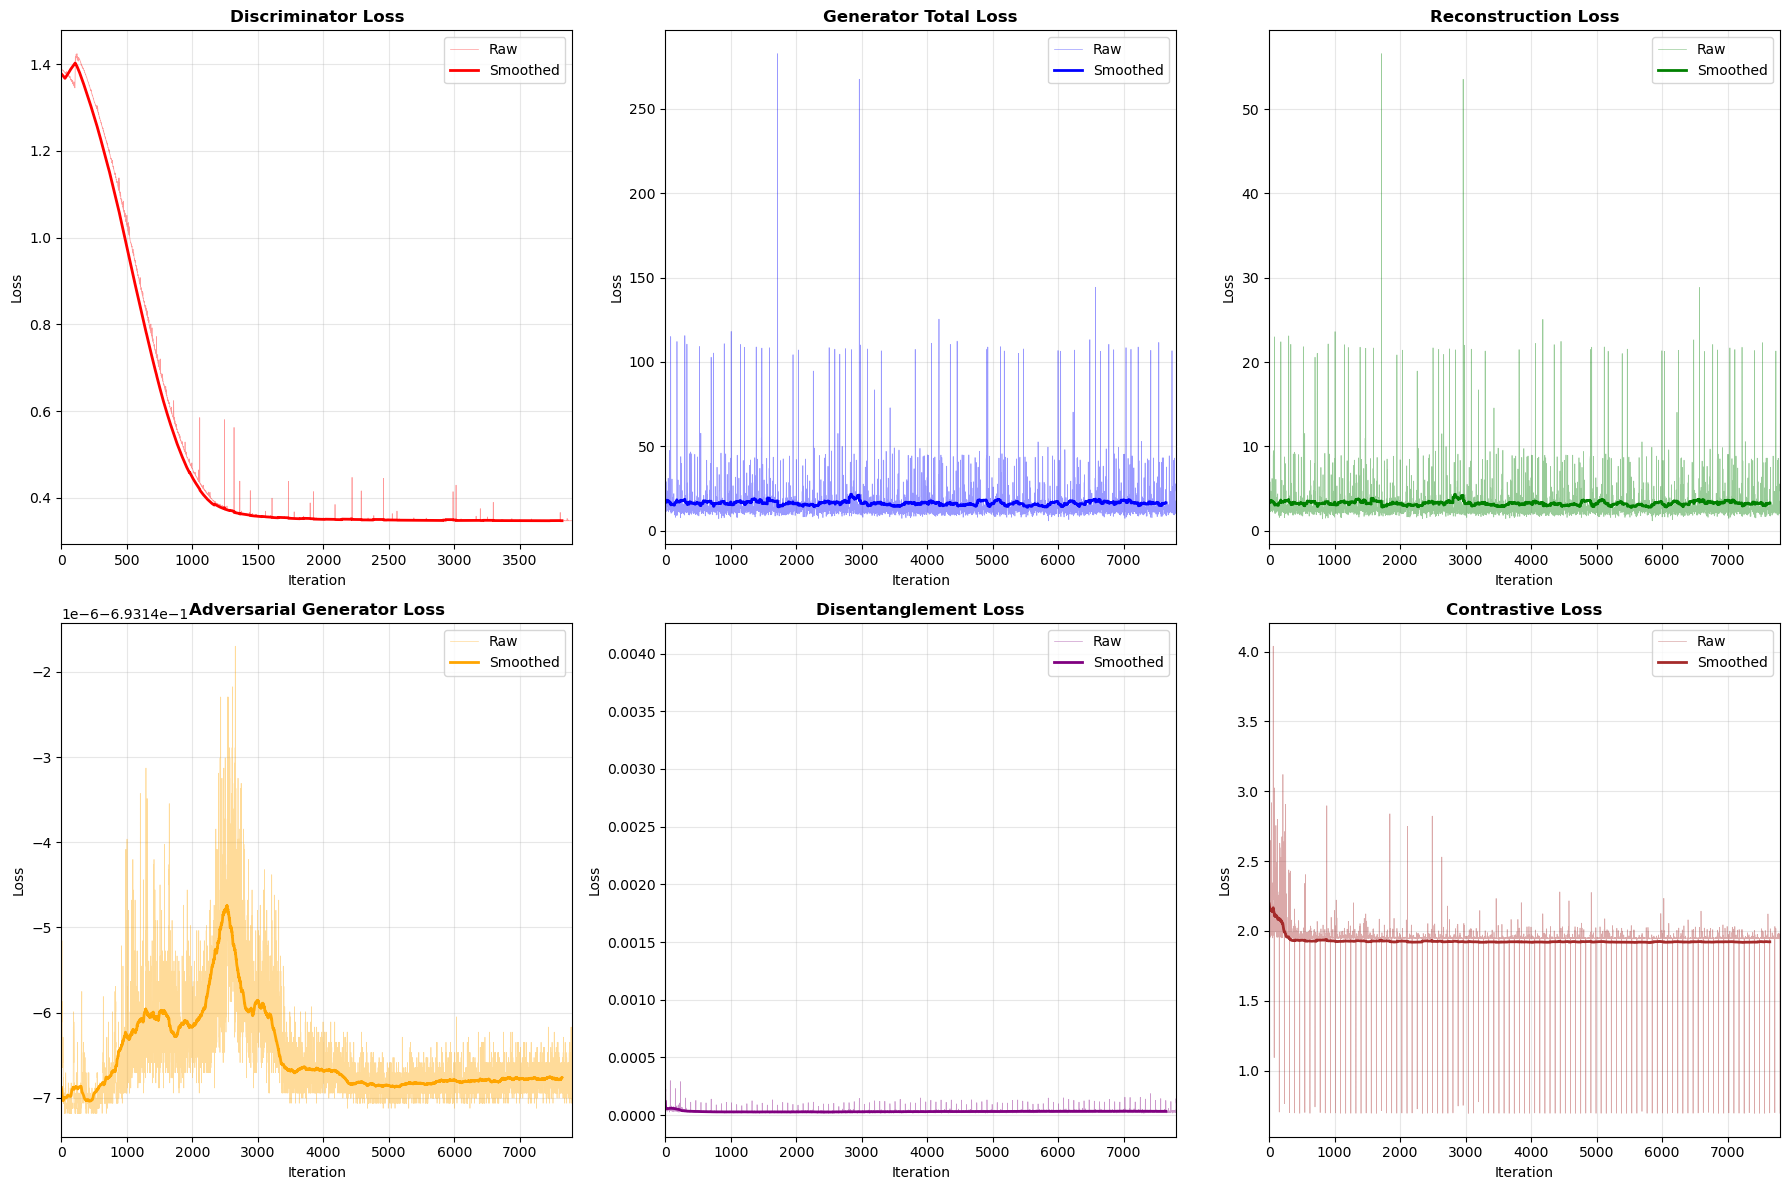

📈 Loss curves saved to: checkpoints\loss_curves.png

🎯 Training completed!
   Total epochs processed: 100
   Final consecutive NaN count: 0
   Checkpoints saved in: checkpoints
   Final GPU memory: 384.6 MB
🎉 Training session finished successfully!


In [ ]:
# main train loop
print("🚀 Starting training with enhanced NaN protection...")
print(f"📊 Configuration: {config}")


loss_history = {
    'total_G': [],
    'disc': [],
    'disent': [],
    'cont': [],
    'margin': [],
    'recon': [],
    'adv_gen': []
}


consecutive_nan_count = 0
max_consecutive_nans = config["nan_threshold"]


models_dict = {
    'style_encoder': style_encoder,
    'content_encoder': content_encoder,
    'discriminator': discriminator,
    'decoder': decoder
}

optimizers_dict = {
    'optimizer_G': optimizer_G,
    'optimizer_D': optimizer_D
}

schedulers_dict = {
    'scheduler_G': scheduler_G,
    'scheduler_D': scheduler_D
}

try:
    for epoch in tqdm(range(config["epochs"]), desc="Training Progress"):
        # early stopping check for NaN
        if consecutive_nan_count >= max_consecutive_nans:
            print(f"🛑 Early stopping: {consecutive_nan_count} consecutive NaN occurrences")
            break
        
        # set all models to training mode
        for model in models:
            model.train()
        
        epoch_losses = {key: [] for key in loss_history.keys()}
        
        print(f"\n🔄 Epoch {epoch+1}/{config['epochs']}")
        print("-" * 60)
        
        for batch_idx, (x, labels) in enumerate(train_loader):
            x = x.to(device)
            labels = labels.to(device)
            
            # Controllo NaN nei dati di input
            if check_for_nan(x, labels, names=["input_x", "input_labels"]):
                print(f"⚠️  Skipping batch {batch_idx} due to NaN in input data")
                continue
            
            # ============================================
            # DISCRIMINATOR training
            # ============================================
            for _ in range(config["discriminator_steps"]):
                disc_loss = discriminator_training_step(x, labels, epoch)
                
                # NaN
                if not np.isnan(disc_loss):
                    epoch_losses['disc'].append(disc_loss)
                    consecutive_nan_count = 0  # Reset counter 
                else:
                    consecutive_nan_count += 1
                    print(f"⚠️  NaN in discriminator loss (consecutive: {consecutive_nan_count})")
            



            # ============================================
            # GENERATORS training
            # ============================================
            for _ in range(config["generator_steps"]):
                gen_losses = generator_training_step(x, labels, epoch)
                
                # NaN
                nan_in_gen = any(np.isnan(v) for v in gen_losses.values())
                
                if not nan_in_gen:
                    for key, value in gen_losses.items():
                        if key in epoch_losses:
                            epoch_losses[key].append(value)
                    consecutive_nan_count = 0  # Reset counter su successo
                else:
                    consecutive_nan_count += 1
                    print(f"⚠️  NaN in generator losses (consecutive: {consecutive_nan_count})")
            



            # batch logging
            if batch_idx % 25 == 0:
                print(f"\n📊 Batch {batch_idx + 1}:")
                
                # disc loss
                if epoch_losses['disc']:
                    recent_disc = epoch_losses['disc'][-config["discriminator_steps"]:]
                    avg_disc = np.mean(recent_disc)
                    print(f"   Discriminator Loss: {avg_disc:.6f}")
                
                # gen loss
                if epoch_losses['total_G']:
                    recent_gen = epoch_losses['total_G'][-config["generator_steps"]:]
                    avg_total_G = np.mean(recent_gen)
                    print(f"   Generator Total Loss: {avg_total_G:.6f}")
                
                # individual losses
                gen_loss_names = ['adv_gen', 'disent', 'cont', 'margin', 'recon']
                for loss_name in gen_loss_names:
                    if epoch_losses[loss_name]:
                        recent_loss = epoch_losses[loss_name][-config["generator_steps"]:]
                        avg_loss = np.mean(recent_loss)
                        print(f"     {loss_name.replace('_', ' ').title()}: {avg_loss:.6f}")
                

                print(f"   Consecutive NaN count: {consecutive_nan_count}")
                if torch.cuda.is_available():
                    print(f"   GPU Memory: {torch.cuda.memory_allocated()/1024**2:.1f} MB")
            
            # NaN
            if consecutive_nan_count >= max_consecutive_nans:
                print(f"🛑 Stopping epoch {epoch+1} due to consecutive NaN issues")
                break
        
        # ============================================
        # update and save
        # ============================================
        if consecutive_nan_count < max_consecutive_nans:
            # update schedulers
            if epoch_losses['disc']:
                scheduler_D.step(np.mean(epoch_losses['disc']))
            if epoch_losses['total_G']:
                scheduler_G.step(np.mean(epoch_losses['total_G']))
            
            # add loss
            for key in loss_history.keys():
                if epoch_losses[key]:
                    loss_history[key].extend(epoch_losses[key])
            
            # save checkpoint
            if (epoch + 1) % config["save_interval"] == 0:
                save_checkpoint(epoch + 1, models_dict, optimizers_dict, schedulers_dict, config)
            
            # epoch summary
            print(f"\n✅ Epoch {epoch+1} Summary:")
            print("-" * 40)
            
            for key in ['disc', 'total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']:
                if epoch_losses[key]:
                    avg_loss = np.mean(epoch_losses[key])
                    print(f"   {key.replace('_', ' ').title()}: {avg_loss:.6f}")
            
            current_lr_G = optimizer_G.param_groups[0]['lr']
            current_lr_D = optimizer_D.param_groups[0]['lr']
            print(f"   LR Generator: {current_lr_G:.2e}")
            print(f"   LR Discriminator: {current_lr_D:.2e}")
            
            print("-" * 60)
        
        # memory clean
        if torch.cuda.is_available() and epoch % 10 == 0:
            torch.cuda.empty_cache()

except KeyboardInterrupt:
    print("\n⏹️  Training interrupted by user")
except Exception as e:
    print(f"\n❌ Training error: {e}")
    import traceback
    traceback.print_exc()
finally:
    # final save
    print("\n💾 Saving final checkpoint...")
    save_checkpoint(epoch + 1, models_dict, optimizers_dict, schedulers_dict, config)
    
    # Visualizzazione delle loss
    if any(loss_history[key] for key in loss_history.keys()):
        print("📊 Generating loss plots...")
        
        # Configura plot
        plt.style.use('default')
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        # Definisci le loss da plottare
        loss_configs = [
            ('disc', 'Discriminator Loss', 'red'),
            ('total_G', 'Generator Total Loss', 'blue'),
            ('recon', 'Reconstruction Loss', 'green'),
            ('adv_gen', 'Adversarial Generator Loss', 'orange'),
            ('disent', 'Disentanglement Loss', 'purple'),
            ('cont', 'Contrastive Loss', 'brown')
        ]
        
        for i, (loss_name, title, color) in enumerate(loss_configs):
            if loss_history[loss_name]:
                values = loss_history[loss_name]
                
                # Plot raw values
                axes[i].plot(values, alpha=0.4, color=color, linewidth=0.5, label='Raw')
                
                # Plot smoothed values se ci sono abbastanza punti
                if len(values) > 50:
                    window = max(1, len(values) // 50)
                    smoothed = np.convolve(values, np.ones(window)/window, mode='valid')
                    axes[i].plot(smoothed, color=color, linewidth=2, label='Smoothed')
                
                axes[i].set_title(title, fontsize=12, fontweight='bold')
                axes[i].set_xlabel('Iteration')
                axes[i].set_ylabel('Loss')
                axes[i].legend()
                axes[i].grid(True, alpha=0.3)
                axes[i].set_xlim(0, len(values))
        
        plt.tight_layout()
        plot_path = os.path.join(config["save_dir"], "loss_curves.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"📈 Loss curves saved to: {plot_path}")
    
    # Riepilogo finale
    print(f"\n🎯 Training completed!")
    print(f"   Total epochs processed: {epoch + 1}")
    print(f"   Final consecutive NaN count: {consecutive_nan_count}")
    print(f"   Checkpoints saved in: {config['save_dir']}")
    
    if torch.cuda.is_available():
        print(f"   Final GPU memory: {torch.cuda.memory_allocated()/1024**2:.1f} MB")
    
    print("🎉 Training session finished successfully!")

## Train with curriculum

In [ ]:
def get_curriculum_weights(epoch, total_epochs):
    progress = epoch / total_epochs
    
    # phase 1 (0-20%): only reconstruction
    if progress < 0.2:
        return {
            "lambda_recon": 10.0,
            "lambda_adv_gen": 0.0,
            "lambda_adv_disc": 0.0,
            "lambda_disent": 0.0,
            "lambda_cont": 0.0,
            "lambda_margin": 0.0
        }
    
    # phase 2 (20-40%): add disentanglement
    elif progress < 0.4:
        return {
            "lambda_recon": 8.0,
            "lambda_adv_gen": 0.0,
            "lambda_adv_disc": 0.0,
            "lambda_disent": 0.5,
            "lambda_cont": 0.0,
            "lambda_margin": 0.0
        }
    
    # phase 2 (40-60%): add contrastive learning
    elif progress < 0.6:
        return {
            "lambda_recon": 5.0,
            "lambda_adv_gen": 0.0,
            "lambda_adv_disc": 0.0,
            "lambda_disent": 0.8,
            "lambda_cont": 0.2,
            "lambda_margin": 0.1
        }
    
    # phase 4 (60-100%): introduce adversarial training gradually
    else:
        # gradual increase of adversarial loss
        adv_strength = min(1.0, (progress - 0.6) / 0.4)
        return {
            "lambda_recon": 3.0,
            "lambda_adv_gen": 0.3 * adv_strength,
            "lambda_adv_disc": 0.5 * adv_strength,
            "lambda_disent": 0.8,
            "lambda_cont": 0.1,
            "lambda_margin": 0.05
        }
    

def display_final_loss_summary(loss_history, config):
    """
    Visualizza il riepilogo finale delle loss e genera i grafici
    """
    print("📊 Generating final loss summary and plots...")
    
    # Controlla se ci sono loss da visualizzare
    if not any(loss_history[key] for key in loss_history.keys()):
        print("⚠️  No loss data to display")
        return
    
    # Configura plot
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Definisci le loss da plottare
    loss_configs = [
        ('disc', 'Discriminator Loss', 'red'),
        ('total_G', 'Generator Total Loss', 'blue'),
        ('recon', 'Reconstruction Loss', 'green'),
        ('adv_gen', 'Adversarial Generator Loss', 'orange'),
        ('disent', 'Disentanglement Loss', 'purple'),
        ('cont', 'Contrastive Loss', 'brown')
    ]
    
    for i, (loss_name, title, color) in enumerate(loss_configs):
        if loss_history[loss_name]:
            values = loss_history[loss_name]
            
            # Plot raw values
            axes[i].plot(values, alpha=0.4, color=color, linewidth=0.5, label='Raw')
            
            # Plot smoothed values se ci sono abbastanza punti
            if len(values) > 50:
                window = max(1, len(values) // 50)
                smoothed = np.convolve(values, np.ones(window)/window, mode='valid')
                axes[i].plot(smoothed, color=color, linewidth=2, label='Smoothed')
            
            axes[i].set_title(title, fontsize=12, fontweight='bold')
            axes[i].set_xlabel('Iteration')
            axes[i].set_ylabel('Loss')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xlim(0, len(values))
    
    plt.tight_layout()
    plot_path = os.path.join(config["save_dir"], "curriculum_loss_curves.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📈 Loss curves saved to: {plot_path}")

In [7]:
def discriminator_training_step_curriculum(x, labels, epoch, total_epochs):
    """
    Step di training per il discriminatore con curriculum learning
    """
    # Ottieni pesi curriculum
    curriculum_weights = get_curriculum_weights(epoch, total_epochs)
    
    # Salta training del discriminatore se non è ancora attivo
    if curriculum_weights["lambda_adv_disc"] == 0:
        return 0.0
    
    # Abilita gradienti solo per discriminatore
    set_requires_grad(discriminator, True)
    set_requires_grad([style_encoder, content_encoder, decoder], False)
    
    try:
        # Forward pass senza gradienti per i generatori
        with torch.no_grad():
            style_emb, class_emb = style_encoder(x, labels)
            content_emb = content_encoder(x)
        
        # Controllo NaN negli embeddings
        if check_for_nan(style_emb, class_emb, content_emb, 
                         names=["style_emb", "class_emb", "content_emb"]):
            return float('nan')
        
        # Calcola loss del discriminatore
        disc_loss, _ = adversarial_loss(
            style_emb.detach(),
            class_emb.detach(),
            content_emb.detach(),
            discriminator,
            labels,
            compute_for_discriminator=True,
            lambda_content=curriculum_weights["lambda_adv_disc"]
        )
        
        # Controllo NaN nella loss
        if check_for_nan(disc_loss, names=["disc_loss"]):
            return float('nan')
        
        # Backpropagation
        optimizer_D.zero_grad()
        disc_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), config["grad_clip_value"])
        
        optimizer_D.step()
        return disc_loss.item()
        
    except Exception as e:
        print(f"❌ Error in discriminator training step: {e}")
        return float('nan')

def generator_training_step_curriculum(x, labels, epoch, total_epochs):
    """
    Step di training per i generatori con curriculum learning
    """
    # Ottieni pesi curriculum per l'epoca corrente
    curriculum_weights = get_curriculum_weights(epoch, total_epochs)
    
    # Abilita gradienti per i generatori
    set_requires_grad([style_encoder, content_encoder, decoder], True)
    set_requires_grad(discriminator, False)
    
    try:
        # Forward pass
        style_emb, class_emb = style_encoder(x, labels)
        content_emb = content_encoder(x)
        
        # Controllo NaN
        if check_for_nan(style_emb, class_emb, content_emb,
                         names=["style_emb", "class_emb", "content_emb"]):
            return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}
        
        # Calcola solo le loss attive nel curriculum
        losses = {}
        
        # Loss di ricostruzione (sempre attiva)
        if curriculum_weights["lambda_recon"] > 0:
            stft_part = x[:, :, :, :, :513]
            recon_x = decoder(content_emb, style_emb, y=stft_part)
            recon_losses = compute_comprehensive_loss(recon_x, stft_part)
            losses["recon"] = recon_losses['total_loss']
        
        # Loss di disentanglement
        if curriculum_weights["lambda_disent"] > 0:
            losses["disent"] = disentanglement_loss(
                style_emb, content_emb.mean(dim=1), use_hsic=True
            )
        
        # Loss contrastiva
        if curriculum_weights["lambda_cont"] > 0:
            losses["cont"] = infoNCE_loss(style_emb, labels)
        
        # Margin loss
        if curriculum_weights["lambda_margin"] > 0:
            losses["margin"] = margin_loss(class_emb)
        
        # Loss avversariale (solo quando attivata)
        if curriculum_weights["lambda_adv_gen"] > 0:
            _, losses["adv_gen"] = adversarial_loss(
                style_emb, class_emb, content_emb, discriminator, labels,
                compute_for_discriminator=False,
                lambda_content=curriculum_weights["lambda_adv_gen"]
            )
        
        # Controlla NaN in tutte le loss calcolate
        if check_for_nan(*losses.values(), names=list(losses.keys())):
            return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}
        
        # Calcola loss totale usando i pesi del curriculum
        total_G_loss = sum(
            curriculum_weights[f"lambda_{key}"] * loss_val
            for key, loss_val in losses.items()
            if f"lambda_{key}" in curriculum_weights
        )
        
        # Backpropagation
        optimizer_G.zero_grad()
        total_G_loss.backward()
        
        # Gradient clipping
        generator_params = (
            list(style_encoder.parameters()) + 
            list(content_encoder.parameters()) +
            list(decoder.parameters())
        )
        torch.nn.utils.clip_grad_norm_(generator_params, config["grad_clip_value"])
        
        optimizer_G.step()
        
        # Prepara output con tutte le loss (0 se non attive)
        output_losses = {
            'total_G': total_G_loss.item(),
            'recon': losses.get("recon", torch.tensor(0.0)).item(),
            'disent': losses.get("disent", torch.tensor(0.0)).item(),
            'cont': losses.get("cont", torch.tensor(0.0)).item(),
            'margin': losses.get("margin", torch.tensor(0.0)).item(),
            'adv_gen': losses.get("adv_gen", torch.tensor(0.0)).item()
        }
        
        return output_losses
        
    except Exception as e:
        print(f"❌ Error in generator training step: {e}")
        return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}

In [ ]:
def train_with_curriculum():
    """
    Training principale con curriculum learning integrato
    """
    print("🚀 Starting curriculum learning training...")
    
    # Inizializza strutture per il tracking delle loss
    loss_history = {
        'total_G': [],
        'disc': [],
        'disent': [],
        'cont': [],
        'margin': [],
        'recon': [],
        'adv_gen': []
    }
    
    # Contatore per NaN consecutivi
    consecutive_nan_count = 0
    max_consecutive_nans = config["nan_threshold"]
    
    # Dizionari per salvataggio
    models_dict = {
        'style_encoder': style_encoder,
        'content_encoder': content_encoder,
        'discriminator': discriminator,
        'decoder': decoder
    }
    
    optimizers_dict = {
        'optimizer_G': optimizer_G,
        'optimizer_D': optimizer_D
    }
    
    schedulers_dict = {
        'scheduler_G': scheduler_G,
        'scheduler_D': scheduler_D
    }
    
    try:
        for epoch in tqdm(range(config["epochs"]), desc="Curriculum Training"):
            # Controllo early stopping per NaN
            if consecutive_nan_count >= max_consecutive_nans:
                print(f"🛑 Early stopping: {consecutive_nan_count} consecutive NaN occurrences")
                break
            
            # Ottieni pesi curriculum per l'epoca corrente
            curriculum_weights = get_curriculum_weights(epoch, config["epochs"])
            
            # Imposta tutti i modelli in modalità training
            for model in models:
                model.train()
            
            # Tracking delle loss per l'epoca corrente
            epoch_losses = {key: [] for key in loss_history.keys()}
            
            # Stampa fase corrente del curriculum
            progress = epoch / config["epochs"]
            if progress < 0.2:
                phase = "Fase 1: Solo Ricostruzione"
            elif progress < 0.4:
                phase = "Fase 2: + Disentanglement"
            elif progress < 0.6:
                phase = "Fase 3: + Contrastive Learning"
            else:
                phase = "Fase 4: + Adversarial Training"
            
            print(f"\n🔄 Epoch {epoch+1}/{config['epochs']} - {phase}")
            print(f"📊 Curriculum weights: {curriculum_weights}")
            print("-" * 60)
            
            for batch_idx, (x, labels) in enumerate(train_loader):
                # Trasferisce dati su GPU
                x = x.to(device)
                labels = labels.to(device)
                
                # Controllo NaN nei dati di input
                if check_for_nan(x, labels, names=["input_x", "input_labels"]):
                    print(f"⚠️  Skipping batch {batch_idx} due to NaN in input data")
                    continue
                
                # ============================================
                # TRAINING DISCRIMINATORE (solo se attivo)
                # ============================================
                if curriculum_weights["lambda_adv_disc"] > 0:
                    for _ in range(config["discriminator_steps"]):
                        disc_loss = discriminator_training_step_curriculum(x, labels, epoch, config["epochs"])
                        
                        if not np.isnan(disc_loss):
                            epoch_losses['disc'].append(disc_loss)
                            consecutive_nan_count = 0
                        else:
                            consecutive_nan_count += 1
                            print(f"⚠️  NaN in discriminator loss (consecutive: {consecutive_nan_count})")
                
                # ============================================
                # TRAINING GENERATORE
                # ============================================
                for _ in range(config["generator_steps"]):
                    gen_losses = generator_training_step_curriculum(x, labels, epoch, config["epochs"])
                    
                    # Controlla se ci sono NaN nelle loss del generatore
                    nan_in_gen = any(np.isnan(v) for v in gen_losses.values())
                    
                    if not nan_in_gen:
                        # Aggiungi loss valide alla storia
                        for key, value in gen_losses.items():
                            if key in epoch_losses:
                                epoch_losses[key].append(value)
                        consecutive_nan_count = 0
                    else:
                        consecutive_nan_count += 1
                        print(f"⚠️  NaN in generator losses (consecutive: {consecutive_nan_count})")
                
                # ============================================
                # LOGGING PER BATCH
                # ============================================
                if batch_idx % 10 == 0:
                    print(f"\n📊 Batch {batch_idx + 1} / {len(train_loader)}:")
                    
                    # Solo loss attive nel curriculum
                    if curriculum_weights["lambda_adv_disc"] > 0 and epoch_losses['disc']:
                        recent_disc = epoch_losses['disc'][-config["discriminator_steps"]:]
                        avg_disc = np.mean(recent_disc)
                        print(f"   Discriminator Loss: {avg_disc:.6f}")
                    
                    if epoch_losses['total_G']:
                        recent_gen = epoch_losses['total_G'][-config["generator_steps"]:]
                        avg_total_G = np.mean(recent_gen)
                        print(f"   Generator Total Loss: {avg_total_G:.6f}")
                    
                    # Loss individuali attive
                    for loss_name, weight_key in [
                        ('recon', 'lambda_recon'),
                        ('disent', 'lambda_disent'),
                        ('cont', 'lambda_cont'),
                        ('margin', 'lambda_margin'),
                        ('adv_gen', 'lambda_adv_gen')
                    ]:
                        if curriculum_weights[weight_key] > 0 and epoch_losses[loss_name]:
                            recent_loss = epoch_losses[loss_name][-config["generator_steps"]:]
                            avg_loss = np.mean(recent_loss)
                            print(f"     {loss_name.replace('_', ' ').title()}: {avg_loss:.6f}")
                
                # Controllo early stopping durante il batch
                if consecutive_nan_count >= max_consecutive_nans:
                    print(f"🛑 Stopping epoch {epoch+1} due to consecutive NaN issues")
                    break
            
            # ============================================
            # FINE EPOCA: AGGIORNAMENTI E SALVATAGGIO
            # ============================================
            if consecutive_nan_count < max_consecutive_nans:
                # Aggiorna schedulers
                if epoch_losses['disc']:
                    scheduler_D.step(np.mean(epoch_losses['disc']))
                if epoch_losses['total_G']:
                    scheduler_G.step(np.mean(epoch_losses['total_G']))
                
                # Aggiungi loss dell'epoca alla storia globale
                for key in loss_history.keys():
                    if epoch_losses[key]:
                        loss_history[key].extend(epoch_losses[key])
                
                # Salva checkpoint periodicamente
                if (epoch + 1) % config["save_interval"] == 0:
                    save_checkpoint(epoch + 1, models_dict, optimizers_dict, schedulers_dict, config)
                
                # Riepilogo dell'epoca
                print(f"\n✅ Epoch {epoch+1} Summary:")
                print("-" * 40)
                
                # Mostra solo loss attive
                for key, weight_key in [
                    ('disc', 'lambda_adv_disc'),
                    ('total_G', None),
                    ('recon', 'lambda_recon'),
                    ('disent', 'lambda_disent'),
                    ('cont', 'lambda_cont'),
                    ('margin', 'lambda_margin'),
                    ('adv_gen', 'lambda_adv_gen')
                ]:
                    if (weight_key is None or curriculum_weights[weight_key] > 0) and epoch_losses[key]:
                        avg_loss = np.mean(epoch_losses[key])
                        print(f"   {key.replace('_', ' ').title()}: {avg_loss:.6f}")
                
                print("-" * 60)
            
            # Pulizia memoria periodica
            if torch.cuda.is_available() and epoch % 10 == 0:
                torch.cuda.empty_cache()
    
    except KeyboardInterrupt:
        print("\n⏹️  Training interrupted by user")
    except Exception as e:
        print(f"\n❌ Training error: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # Salvataggio finale
        print("\n💾 Saving final checkpoint...")
        save_checkpoint(epoch + 1, models_dict, optimizers_dict, schedulers_dict, config)
        
        print("🎉 Curriculum learning training completed!")
        display_final_loss_summary(loss_history, config)
        print(f"   Checkpoints saved in: {config['save_dir']}")

        for loss_name in ['disc', 'total_G', 'recon', 'adv_gen', 'disent', 'cont', 'margin']:
            if loss_history[loss_name]:
                values = loss_history[loss_name]
                final_avg = np.mean(values[-100:]) if len(values) >= 100 else np.mean(values)
                overall_avg = np.mean(values)
                min_val = np.min(values)
                max_val = np.max(values)
                
                print(f"   {loss_name.replace('_', ' ').title()}:")
                print(f"     Final Average (last 100): {final_avg:.6f}")
                print(f"     Overall Average: {overall_avg:.6f}")
                print(f"     Min: {min_val:.6f}, Max: {max_val:.6f}")
                print(f"     Total iterations: {len(values)}")

        return loss_history

# ================================================================
# AVVIO DEL TRAINING CON CURRICULUM LEARNING
# ================================================================

# Sostituisci il loop di training originale con questo:
loss_history = train_with_curriculum()

🚀 Starting curriculum learning training...


Curriculum Training:   0%|          | 0/100 [00:00<?, ?it/s]


🔄 Epoch 1/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 30.040179
     Recon: 3.004018

📊 Batch 11 / 39:
   Generator Total Loss: 23.815835
     Recon: 2.381583

📊 Batch 21 / 39:
   Generator Total Loss: 20.773913
     Recon: 2.077391

📊 Batch 31 / 39:
   Generator Total Loss: 79.516014
     Recon: 7.951602


Curriculum Training:   1%|          | 1/100 [04:02<6:40:45, 242.88s/it]


✅ Epoch 1 Summary:
----------------------------------------
   Total G: 34.419098
   Recon: 3.441910
------------------------------------------------------------

🔄 Epoch 2/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 24.925966
     Recon: 2.492597

📊 Batch 11 / 39:
   Generator Total Loss: 19.064965
     Recon: 1.906497

📊 Batch 21 / 39:
   Generator Total Loss: 25.996021
     Recon: 2.599602

📊 Batch 31 / 39:
   Generator Total Loss: 33.118515
     Recon: 3.311852


Curriculum Training:   2%|▏         | 2/100 [11:36<9:58:58, 366.72s/it]


✅ Epoch 2 Summary:
----------------------------------------
   Total G: 32.796667
   Recon: 3.279667
------------------------------------------------------------

🔄 Epoch 3/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 279.129456
     Recon: 27.912946

📊 Batch 11 / 39:
   Generator Total Loss: 22.948074
     Recon: 2.294807

📊 Batch 21 / 39:
   Generator Total Loss: 19.330364
     Recon: 1.933036

📊 Batch 31 / 39:
   Generator Total Loss: 28.545554
     Recon: 2.854555


Curriculum Training:   3%|▎         | 3/100 [19:05<10:53:44, 404.38s/it]


✅ Epoch 3 Summary:
----------------------------------------
   Total G: 35.396991
   Recon: 3.539699
------------------------------------------------------------

🔄 Epoch 4/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 26.969208
     Recon: 2.696921

📊 Batch 11 / 39:
   Generator Total Loss: 21.883610
     Recon: 2.188361

📊 Batch 21 / 39:
   Generator Total Loss: 30.003974
     Recon: 3.000397

📊 Batch 31 / 39:
   Generator Total Loss: 21.186113
     Recon: 2.118611


Curriculum Training:   4%|▍         | 4/100 [26:26<11:10:10, 418.85s/it]


✅ Epoch 4 Summary:
----------------------------------------
   Total G: 28.546885
   Recon: 2.854689
------------------------------------------------------------

🔄 Epoch 5/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 22.021028
     Recon: 2.202103

📊 Batch 11 / 39:
   Generator Total Loss: 88.043983
     Recon: 8.804399

📊 Batch 21 / 39:
   Generator Total Loss: 31.782878
     Recon: 3.178288

📊 Batch 31 / 39:
   Generator Total Loss: 22.657051
     Recon: 2.265705


Curriculum Training:   5%|▌         | 5/100 [33:41<11:12:22, 424.65s/it]


✅ Epoch 5 Summary:
----------------------------------------
   Total G: 31.987876
   Recon: 3.198788
------------------------------------------------------------

🔄 Epoch 6/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 25.642575
     Recon: 2.564258

📊 Batch 11 / 39:
   Generator Total Loss: 17.786218
     Recon: 1.778622

📊 Batch 21 / 39:
   Generator Total Loss: 19.027709
     Recon: 1.902771

📊 Batch 31 / 39:
   Generator Total Loss: 27.664481
     Recon: 2.766448


Curriculum Training:   6%|▌         | 6/100 [41:08<11:17:01, 432.15s/it]


✅ Epoch 6 Summary:
----------------------------------------
   Total G: 28.522884
   Recon: 2.852288
------------------------------------------------------------

🔄 Epoch 7/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 22.890172
     Recon: 2.289017

📊 Batch 11 / 39:
   Generator Total Loss: 88.292343
     Recon: 8.829234

📊 Batch 21 / 39:
   Generator Total Loss: 225.828789
     Recon: 22.582879

📊 Batch 31 / 39:
   Generator Total Loss: 27.641722
     Recon: 2.764172


Curriculum Training:   7%|▋         | 7/100 [48:34<11:17:13, 436.92s/it]


✅ Epoch 7 Summary:
----------------------------------------
   Total G: 34.007477
   Recon: 3.400748
------------------------------------------------------------

🔄 Epoch 8/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 36.587626
     Recon: 3.658763

📊 Batch 11 / 39:
   Generator Total Loss: 45.518187
     Recon: 4.551819

📊 Batch 21 / 39:
   Generator Total Loss: 58.217724
     Recon: 5.821772

📊 Batch 31 / 39:
   Generator Total Loss: 24.484645
     Recon: 2.448465


Curriculum Training:   8%|▊         | 8/100 [55:58<11:13:22, 439.16s/it]


✅ Epoch 8 Summary:
----------------------------------------
   Total G: 27.974723
   Recon: 2.797472
------------------------------------------------------------

🔄 Epoch 9/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 36.502926
     Recon: 3.650293

📊 Batch 11 / 39:
   Generator Total Loss: 25.334967
     Recon: 2.533497

📊 Batch 21 / 39:
   Generator Total Loss: 26.164895
     Recon: 2.616490

📊 Batch 31 / 39:
   Generator Total Loss: 21.284824
     Recon: 2.128482


Curriculum Training:   9%|▉         | 9/100 [1:03:08<11:01:32, 436.18s/it]


✅ Epoch 9 Summary:
----------------------------------------
   Total G: 31.988054
   Recon: 3.198805
------------------------------------------------------------

🔄 Epoch 10/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 26.848783
     Recon: 2.684878

📊 Batch 11 / 39:
   Generator Total Loss: 50.893789
     Recon: 5.089379

📊 Batch 21 / 39:
   Generator Total Loss: 28.839541
     Recon: 2.883954

📊 Batch 31 / 39:
   Generator Total Loss: 28.440886
     Recon: 2.844089


Curriculum Training:  10%|█         | 10/100 [1:10:08<10:46:41, 431.13s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_10.pth

✅ Epoch 10 Summary:
----------------------------------------
   Total G: 35.492402
   Recon: 3.549240
------------------------------------------------------------

🔄 Epoch 11/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 25.566228
     Recon: 2.556623

📊 Batch 11 / 39:
   Generator Total Loss: 75.929966
     Recon: 7.592997

📊 Batch 21 / 39:
   Generator Total Loss: 31.248421
     Recon: 3.124842

📊 Batch 31 / 39:
   Generator Total Loss: 24.758408
     Recon: 2.475841

✅ Epoch 11 Summary:
----------------------------------------
   Total G: 36.962715
   Recon: 3.696271
------------------------------------------------------------


Curriculum Training:  11%|█         | 11/100 [1:17:23<10:41:29, 432.47s/it]


🔄 Epoch 12/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 29.414723
     Recon: 2.941472

📊 Batch 11 / 39:
   Generator Total Loss: 67.833050
     Recon: 6.783305

📊 Batch 21 / 39:
   Generator Total Loss: 108.518017
     Recon: 10.851801

📊 Batch 31 / 39:
   Generator Total Loss: 84.453579
     Recon: 8.445358


Curriculum Training:  12%|█▏        | 12/100 [1:22:30<9:38:21, 394.34s/it] 


✅ Epoch 12 Summary:
----------------------------------------
   Total G: 37.303389
   Recon: 3.730339
------------------------------------------------------------

🔄 Epoch 13/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 29.971838
     Recon: 2.997184

📊 Batch 11 / 39:
   Generator Total Loss: 18.574139
     Recon: 1.857414

📊 Batch 21 / 39:
   Generator Total Loss: 27.789881
     Recon: 2.778988

📊 Batch 31 / 39:
   Generator Total Loss: 25.979697
     Recon: 2.597970


Curriculum Training:  13%|█▎        | 13/100 [1:27:58<9:02:14, 373.96s/it]


✅ Epoch 13 Summary:
----------------------------------------
   Total G: 36.763182
   Recon: 3.676318
------------------------------------------------------------

🔄 Epoch 14/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 50.000170
     Recon: 5.000017

📊 Batch 11 / 39:
   Generator Total Loss: 22.600976
     Recon: 2.260098

📊 Batch 21 / 39:
   Generator Total Loss: 21.008660
     Recon: 2.100866

📊 Batch 31 / 39:
   Generator Total Loss: 33.187288
     Recon: 3.318729


Curriculum Training:  14%|█▍        | 14/100 [1:33:31<8:38:37, 361.83s/it]


✅ Epoch 14 Summary:
----------------------------------------
   Total G: 29.588585
   Recon: 2.958858
------------------------------------------------------------

🔄 Epoch 15/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 22.612436
     Recon: 2.261244

📊 Batch 11 / 39:
   Generator Total Loss: 27.675717
     Recon: 2.767572

📊 Batch 21 / 39:
   Generator Total Loss: 20.379340
     Recon: 2.037934

📊 Batch 31 / 39:
   Generator Total Loss: 28.014291
     Recon: 2.801429


Curriculum Training:  15%|█▌        | 15/100 [1:38:36<8:08:14, 344.65s/it]


✅ Epoch 15 Summary:
----------------------------------------
   Total G: 38.293624
   Recon: 3.829362
------------------------------------------------------------

🔄 Epoch 16/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 27.369197
     Recon: 2.736920

📊 Batch 11 / 39:
   Generator Total Loss: 24.729516
     Recon: 2.472952

📊 Batch 21 / 39:
   Generator Total Loss: 24.023959
     Recon: 2.402396

📊 Batch 31 / 39:
   Generator Total Loss: 40.765162
     Recon: 4.076516


Curriculum Training:  16%|█▌        | 16/100 [1:43:42<7:46:09, 332.97s/it]


✅ Epoch 16 Summary:
----------------------------------------
   Total G: 33.023854
   Recon: 3.302385
------------------------------------------------------------

🔄 Epoch 17/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 23.671750
     Recon: 2.367175

📊 Batch 11 / 39:
   Generator Total Loss: 25.725585
     Recon: 2.572559

📊 Batch 21 / 39:
   Generator Total Loss: 22.867392
     Recon: 2.286739

📊 Batch 31 / 39:
   Generator Total Loss: 27.181482
     Recon: 2.718148


Curriculum Training:  17%|█▋        | 17/100 [1:48:48<7:29:34, 324.99s/it]


✅ Epoch 17 Summary:
----------------------------------------
   Total G: 29.378600
   Recon: 2.937860
------------------------------------------------------------

🔄 Epoch 18/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 30.912606
     Recon: 3.091261

📊 Batch 11 / 39:
   Generator Total Loss: 24.188780
     Recon: 2.418878

📊 Batch 21 / 39:
   Generator Total Loss: 18.341660
     Recon: 1.834166

📊 Batch 31 / 39:
   Generator Total Loss: 28.686511
     Recon: 2.868651


Curriculum Training:  18%|█▊        | 18/100 [1:53:47<7:13:16, 317.04s/it]


✅ Epoch 18 Summary:
----------------------------------------
   Total G: 36.621262
   Recon: 3.662126
------------------------------------------------------------

🔄 Epoch 19/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 26.862859
     Recon: 2.686286

📊 Batch 11 / 39:
   Generator Total Loss: 29.573441
     Recon: 2.957344

📊 Batch 21 / 39:
   Generator Total Loss: 34.568436
     Recon: 3.456843

📊 Batch 31 / 39:
   Generator Total Loss: 22.815368
     Recon: 2.281537


Curriculum Training:  19%|█▉        | 19/100 [1:58:30<6:54:20, 306.91s/it]


✅ Epoch 19 Summary:
----------------------------------------
   Total G: 32.317943
   Recon: 3.231794
------------------------------------------------------------

🔄 Epoch 20/100 - Fase 1: Solo Ricostruzione
📊 Curriculum weights: {'lambda_recon': 10.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.0, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 26.176258
     Recon: 2.617626

📊 Batch 11 / 39:
   Generator Total Loss: 31.521892
     Recon: 3.152189

📊 Batch 21 / 39:
   Generator Total Loss: 30.468287
     Recon: 3.046829

📊 Batch 31 / 39:
   Generator Total Loss: 26.950768
     Recon: 2.695077


Curriculum Training:  20%|██        | 20/100 [2:03:56<6:56:42, 312.53s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_20.pth

✅ Epoch 20 Summary:
----------------------------------------
   Total G: 30.296709
   Recon: 3.029671
------------------------------------------------------------

🔄 Epoch 21/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 24.688993
     Recon: 3.086069
     Disent: 0.000876

📊 Batch 11 / 39:
   Generator Total Loss: 20.128338
     Recon: 2.516004
     Disent: 0.000611

📊 Batch 21 / 39:
   Generator Total Loss: 15.995523
     Recon: 1.999429
     Disent: 0.000191

📊 Batch 31 / 39:
   Generator Total Loss: 16.384453
     Recon: 2.048043
     Disent: 0.000223


Curriculum Training:  21%|██        | 21/100 [2:09:09<6:51:54, 312.84s/it]


✅ Epoch 21 Summary:
----------------------------------------
   Total G: 26.918207
   Recon: 3.364724
   Disent: 0.000830
------------------------------------------------------------

🔄 Epoch 22/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 17.306984
     Recon: 2.163355
     Disent: 0.000291

📊 Batch 11 / 39:
   Generator Total Loss: 20.723040
     Recon: 2.590369
     Disent: 0.000172

📊 Batch 21 / 39:
   Generator Total Loss: 22.724034
     Recon: 2.840496
     Disent: 0.000128

📊 Batch 31 / 39:
   Generator Total Loss: 17.562332
     Recon: 2.195279
     Disent: 0.000204


Curriculum Training:  22%|██▏       | 22/100 [2:13:43<6:31:17, 300.99s/it]


✅ Epoch 22 Summary:
----------------------------------------
   Total G: 21.309528
   Recon: 2.663664
   Disent: 0.000436
------------------------------------------------------------

🔄 Epoch 23/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 20.513479
     Recon: 2.564174
     Disent: 0.000168

📊 Batch 11 / 39:
   Generator Total Loss: 69.357819
     Recon: 8.669520
     Disent: 0.003304

📊 Batch 21 / 39:
   Generator Total Loss: 20.628377
     Recon: 2.578527
     Disent: 0.000322

📊 Batch 31 / 39:
   Generator Total Loss: 18.947603
     Recon: 2.368432
     Disent: 0.000290


Curriculum Training:  23%|██▎       | 23/100 [2:18:34<6:22:31, 298.08s/it]


✅ Epoch 23 Summary:
----------------------------------------
   Total G: 23.445411
   Recon: 2.930642
   Disent: 0.000548
------------------------------------------------------------

🔄 Epoch 24/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 19.333899
     Recon: 2.416724
     Disent: 0.000211

📊 Batch 11 / 39:
   Generator Total Loss: 18.242298
     Recon: 2.280283
     Disent: 0.000062

📊 Batch 21 / 39:
   Generator Total Loss: 27.596702
     Recon: 3.449561
     Disent: 0.000425

📊 Batch 31 / 39:
   Generator Total Loss: 21.881592
     Recon: 2.735195
     Disent: 0.000067


Curriculum Training:  24%|██▍       | 24/100 [2:23:18<6:12:20, 293.96s/it]


✅ Epoch 24 Summary:
----------------------------------------
   Total G: 23.996244
   Recon: 2.999504
   Disent: 0.000424
------------------------------------------------------------

🔄 Epoch 25/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 25.393925
     Recon: 3.174231
     Disent: 0.000161

📊 Batch 11 / 39:
   Generator Total Loss: 19.938432
     Recon: 2.492283
     Disent: 0.000328

📊 Batch 21 / 39:
   Generator Total Loss: 17.733903
     Recon: 2.216730
     Disent: 0.000118

📊 Batch 31 / 39:
   Generator Total Loss: 20.467000
     Recon: 2.558366
     Disent: 0.000146


Curriculum Training:  25%|██▌       | 25/100 [2:28:06<6:05:11, 292.15s/it]


✅ Epoch 25 Summary:
----------------------------------------
   Total G: 22.915484
   Recon: 2.864415
   Disent: 0.000327
------------------------------------------------------------

🔄 Epoch 26/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 15.433537
     Recon: 1.929184
     Disent: 0.000139

📊 Batch 11 / 39:
   Generator Total Loss: 33.112171
     Recon: 4.138957
     Disent: 0.001029

📊 Batch 21 / 39:
   Generator Total Loss: 20.734856
     Recon: 2.591853
     Disent: 0.000062

📊 Batch 31 / 39:
   Generator Total Loss: 17.957764
     Recon: 2.244714
     Disent: 0.000099


Curriculum Training:  26%|██▌       | 26/100 [2:32:51<5:57:22, 289.77s/it]


✅ Epoch 26 Summary:
----------------------------------------
   Total G: 24.423570
   Recon: 3.052924
   Disent: 0.000359
------------------------------------------------------------

🔄 Epoch 27/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 18.867505
     Recon: 2.358433
     Disent: 0.000084

📊 Batch 11 / 39:
   Generator Total Loss: 21.274722
     Recon: 2.659332
     Disent: 0.000132

📊 Batch 21 / 39:
   Generator Total Loss: 23.200848
     Recon: 2.900029
     Disent: 0.001226

📊 Batch 31 / 39:
   Generator Total Loss: 38.608385
     Recon: 4.825940
     Disent: 0.001733


Curriculum Training:  27%|██▋       | 27/100 [2:37:44<5:53:55, 290.90s/it]


✅ Epoch 27 Summary:
----------------------------------------
   Total G: 24.260131
   Recon: 3.032493
   Disent: 0.000366
------------------------------------------------------------

🔄 Epoch 28/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 18.895316
     Recon: 2.361911
     Disent: 0.000062

📊 Batch 11 / 39:
   Generator Total Loss: 21.896397
     Recon: 2.737046
     Disent: 0.000049

📊 Batch 21 / 39:
   Generator Total Loss: 18.112530
     Recon: 2.264062
     Disent: 0.000064

📊 Batch 31 / 39:
   Generator Total Loss: 18.250981
     Recon: 2.281369
     Disent: 0.000056


Curriculum Training:  28%|██▊       | 28/100 [2:42:54<5:56:00, 296.68s/it]


✅ Epoch 28 Summary:
----------------------------------------
   Total G: 28.183648
   Recon: 3.522934
   Disent: 0.000348
------------------------------------------------------------

🔄 Epoch 29/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 19.120092
     Recon: 2.390005
     Disent: 0.000111

📊 Batch 11 / 39:
   Generator Total Loss: 21.336111
     Recon: 2.667011
     Disent: 0.000054

📊 Batch 21 / 39:
   Generator Total Loss: 59.420395
     Recon: 7.427444
     Disent: 0.001676

📊 Batch 31 / 39:
   Generator Total Loss: 14.876826
     Recon: 1.859588
     Disent: 0.000243


Curriculum Training:  29%|██▉       | 29/100 [2:47:30<5:43:38, 290.41s/it]


✅ Epoch 29 Summary:
----------------------------------------
   Total G: 27.834240
   Recon: 3.479260
   Disent: 0.000322
------------------------------------------------------------

🔄 Epoch 30/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 23.817543
     Recon: 2.977188
     Disent: 0.000072

📊 Batch 11 / 39:
   Generator Total Loss: 20.031178
     Recon: 2.503884
     Disent: 0.000212

📊 Batch 21 / 39:
   Generator Total Loss: 16.399151
     Recon: 2.049887
     Disent: 0.000112

📊 Batch 31 / 39:
   Generator Total Loss: 15.820421
     Recon: 1.977544
     Disent: 0.000141


Curriculum Training:  30%|███       | 30/100 [2:52:37<5:44:27, 295.25s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_30.pth

✅ Epoch 30 Summary:
----------------------------------------
   Total G: 22.756143
   Recon: 2.844501
   Disent: 0.000268
------------------------------------------------------------

🔄 Epoch 31/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 15.479032
     Recon: 1.934875
     Disent: 0.000059

📊 Batch 11 / 39:
   Generator Total Loss: 20.601245
     Recon: 2.575147
     Disent: 0.000133

📊 Batch 21 / 39:
   Generator Total Loss: 19.388824
     Recon: 2.423596
     Disent: 0.000120

📊 Batch 31 / 39:
   Generator Total Loss: 19.623150
     Recon: 2.452890
     Disent: 0.000067


Curriculum Training:  31%|███       | 31/100 [2:57:27<5:37:44, 293.68s/it]


✅ Epoch 31 Summary:
----------------------------------------
   Total G: 23.334445
   Recon: 2.916789
   Disent: 0.000264
------------------------------------------------------------

🔄 Epoch 32/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 16.770486
     Recon: 2.096304
     Disent: 0.000109

📊 Batch 11 / 39:
   Generator Total Loss: 26.191486
     Recon: 3.273926
     Disent: 0.000153

📊 Batch 21 / 39:
   Generator Total Loss: 23.097732
     Recon: 2.887213
     Disent: 0.000046

📊 Batch 31 / 39:
   Generator Total Loss: 34.865774
     Recon: 4.358194
     Disent: 0.000451


Curriculum Training:  32%|███▏      | 32/100 [3:01:33<5:16:38, 279.38s/it]


✅ Epoch 32 Summary:
----------------------------------------
   Total G: 25.888181
   Recon: 3.236007
   Disent: 0.000249
------------------------------------------------------------

🔄 Epoch 33/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 24.683131
     Recon: 3.085388
     Disent: 0.000053

📊 Batch 11 / 39:
   Generator Total Loss: 16.236927
     Recon: 2.029612
     Disent: 0.000057

📊 Batch 21 / 39:
   Generator Total Loss: 46.654844
     Recon: 5.831689
     Disent: 0.002664

📊 Batch 31 / 39:
   Generator Total Loss: 15.971475
     Recon: 1.996431
     Disent: 0.000060


Curriculum Training:  33%|███▎      | 33/100 [3:05:40<5:01:23, 269.90s/it]


✅ Epoch 33 Summary:
----------------------------------------
   Total G: 27.742780
   Recon: 3.467825
   Disent: 0.000362
------------------------------------------------------------

🔄 Epoch 34/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 16.022452
     Recon: 2.002803
     Disent: 0.000056

📊 Batch 11 / 39:
   Generator Total Loss: 23.902436
     Recon: 2.987800
     Disent: 0.000069

📊 Batch 21 / 39:
   Generator Total Loss: 22.568730
     Recon: 2.821086
     Disent: 0.000084

📊 Batch 31 / 39:
   Generator Total Loss: 16.257841
     Recon: 2.032226
     Disent: 0.000065


Curriculum Training:  34%|███▍      | 34/100 [3:09:46<4:48:51, 262.60s/it]


✅ Epoch 34 Summary:
----------------------------------------
   Total G: 25.354591
   Recon: 3.169296
   Disent: 0.000451
------------------------------------------------------------

🔄 Epoch 35/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 19.327551
     Recon: 2.415941
     Disent: 0.000047

📊 Batch 11 / 39:
   Generator Total Loss: 20.101246
     Recon: 2.512651
     Disent: 0.000077

📊 Batch 21 / 39:
   Generator Total Loss: 18.521105
     Recon: 2.315135
     Disent: 0.000051

📊 Batch 31 / 39:
   Generator Total Loss: 19.613225
     Recon: 2.451647
     Disent: 0.000092


Curriculum Training:  35%|███▌      | 35/100 [3:13:52<4:39:07, 257.65s/it]


✅ Epoch 35 Summary:
----------------------------------------
   Total G: 24.772160
   Recon: 3.096497
   Disent: 0.000362
------------------------------------------------------------

🔄 Epoch 36/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 25.507590
     Recon: 3.188442
     Disent: 0.000101

📊 Batch 11 / 39:
   Generator Total Loss: 16.886162
     Recon: 2.110766
     Disent: 0.000067

📊 Batch 21 / 39:
   Generator Total Loss: 13.862434
     Recon: 1.732798
     Disent: 0.000093

📊 Batch 31 / 39:
   Generator Total Loss: 19.299133
     Recon: 2.412387
     Disent: 0.000083


Curriculum Training:  36%|███▌      | 36/100 [3:18:00<4:31:51, 254.87s/it]


✅ Epoch 36 Summary:
----------------------------------------
   Total G: 26.117329
   Recon: 3.264643
   Disent: 0.000373
------------------------------------------------------------

🔄 Epoch 37/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 15.888073
     Recon: 1.986004
     Disent: 0.000087

📊 Batch 11 / 39:
   Generator Total Loss: 18.537712
     Recon: 2.317209
     Disent: 0.000073

📊 Batch 21 / 39:
   Generator Total Loss: 16.896524
     Recon: 2.112058
     Disent: 0.000117

📊 Batch 31 / 39:
   Generator Total Loss: 23.131710
     Recon: 2.891459
     Disent: 0.000077


Curriculum Training:  37%|███▋      | 37/100 [3:22:12<4:26:27, 253.77s/it]


✅ Epoch 37 Summary:
----------------------------------------
   Total G: 24.211479
   Recon: 3.026415
   Disent: 0.000314
------------------------------------------------------------

🔄 Epoch 38/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 28.626904
     Recon: 3.578358
     Disent: 0.000074

📊 Batch 11 / 39:
   Generator Total Loss: 16.081982
     Recon: 2.010243
     Disent: 0.000081

📊 Batch 21 / 39:
   Generator Total Loss: 22.221478
     Recon: 2.777682
     Disent: 0.000051

📊 Batch 31 / 39:
   Generator Total Loss: 15.541028
     Recon: 1.942622
     Disent: 0.000103


Curriculum Training:  38%|███▊      | 38/100 [3:26:17<4:19:29, 251.12s/it]


✅ Epoch 38 Summary:
----------------------------------------
   Total G: 22.525547
   Recon: 2.815679
   Disent: 0.000225
------------------------------------------------------------

🔄 Epoch 39/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 21.286285
     Recon: 2.660777
     Disent: 0.000134

📊 Batch 11 / 39:
   Generator Total Loss: 27.880003
     Recon: 3.484993
     Disent: 0.000112

📊 Batch 21 / 39:
   Generator Total Loss: 51.712875
     Recon: 6.464002
     Disent: 0.001714

📊 Batch 31 / 39:
   Generator Total Loss: 20.772797
     Recon: 2.596595
     Disent: 0.000081


Curriculum Training:  39%|███▉      | 39/100 [3:30:26<4:14:47, 250.61s/it]


✅ Epoch 39 Summary:
----------------------------------------
   Total G: 24.078609
   Recon: 3.009807
   Disent: 0.000301
------------------------------------------------------------

🔄 Epoch 40/100 - Fase 2: + Disentanglement
📊 Curriculum weights: {'lambda_recon': 8.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.5, 'lambda_cont': 0.0, 'lambda_margin': 0.0}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 27.264122
     Recon: 3.407950
     Disent: 0.001046

📊 Batch 11 / 39:
   Generator Total Loss: 18.341670
     Recon: 2.292698
     Disent: 0.000179

📊 Batch 21 / 39:
   Generator Total Loss: 21.558219
     Recon: 2.694771
     Disent: 0.000098

📊 Batch 31 / 39:
   Generator Total Loss: 20.518085
     Recon: 2.564756
     Disent: 0.000072


Curriculum Training:  40%|████      | 40/100 [3:34:35<4:10:11, 250.20s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_40.pth

✅ Epoch 40 Summary:
----------------------------------------
   Total G: 23.438466
   Recon: 2.929790
   Disent: 0.000286
------------------------------------------------------------

🔄 Epoch 41/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 13.630813
     Recon: 2.618816
     Disent: 0.000104
     Cont: 2.683239
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 13.369590
     Recon: 2.592280
     Disent: 0.000245
     Cont: 2.039966
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 14.102619
     Recon: 2.742166
     Disent: 0.000358
     Cont: 1.957505
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 12.673951
     Recon: 2.453128
     Dis

Curriculum Training:  41%|████      | 41/100 [3:38:53<4:08:06, 252.31s/it]


✅ Epoch 41 Summary:
----------------------------------------
   Total G: 17.328892
   Recon: 3.377142
   Disent: 0.001051
   Cont: 2.211699
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 42/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 11.103621
     Recon: 2.141956
     Disent: 0.000269
     Cont: 1.968132
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 11.003012
     Recon: 2.120490
     Disent: 0.001720
     Cont: 1.995940
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 12.335816
     Recon: 2.388122
     Disent: 0.000405
     Cont: 1.974398
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 11.653065
     Recon: 2.252551
     Disent: 0.000370
    

Curriculum Training:  42%|████▏     | 42/100 [3:42:43<3:57:29, 245.69s/it]


✅ Epoch 42 Summary:
----------------------------------------
   Total G: 14.569906
   Recon: 2.833420
   Disent: 0.000670
   Cont: 2.011350
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 43/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 21.150027
     Recon: 4.144858
     Disent: 0.000162
     Cont: 2.128030
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 20.047488
     Recon: 3.930549
     Disent: 0.000230
     Cont: 1.972801
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 14.730572
     Recon: 2.867894
     Disent: 0.000641
     Cont: 1.952950
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 12.871987
     Recon: 2.496260
     Disent: 0.000512
    

Curriculum Training:  43%|████▎     | 43/100 [3:46:53<3:54:46, 247.12s/it]


✅ Epoch 43 Summary:
----------------------------------------
   Total G: 15.837217
   Recon: 3.089080
   Disent: 0.000762
   Cont: 1.956037
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 44/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 14.146189
     Recon: 2.750632
     Disent: 0.000657
     Cont: 1.962529
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 16.049988
     Recon: 3.130064
     Disent: 0.000709
     Cont: 1.995506
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 14.106698
     Recon: 2.743372
     Disent: 0.000257
     Cont: 1.948173
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 8.642174
     Recon: 1.650445
     Disent: 0.000444
     

Curriculum Training:  44%|████▍     | 44/100 [3:51:07<3:52:31, 249.14s/it]


✅ Epoch 44 Summary:
----------------------------------------
   Total G: 14.627621
   Recon: 2.847753
   Disent: 0.000661
   Cont: 1.941635
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 45/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 13.046373
     Recon: 2.531152
     Disent: 0.000642
     Cont: 1.950495
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 19.092720
     Recon: 3.740534
     Disent: 0.000726
     Cont: 1.947343
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 10.954117
     Recon: 2.112828
     Disent: 0.000146
     Cont: 1.949294
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 16.069571
     Recon: 3.135078
     Disent: 0.000717
    

Curriculum Training:  45%|████▌     | 45/100 [3:55:26<3:51:10, 252.19s/it]


✅ Epoch 45 Summary:
----------------------------------------
   Total G: 14.949350
   Recon: 2.911403
   Disent: 0.000296
   Cont: 1.960491
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 46/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 11.461644
     Recon: 2.214394
     Disent: 0.000156
     Cont: 1.947735
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 19.142741
     Recon: 3.750374
     Disent: 0.000293
     Cont: 1.953190
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 12.000655
     Recon: 2.322172
     Disent: 0.000122
     Cont: 1.948482
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 12.258614
     Recon: 2.373438
     Disent: 0.000679
    

Curriculum Training:  46%|████▌     | 46/100 [3:59:26<3:43:38, 248.49s/it]


✅ Epoch 46 Summary:
----------------------------------------
   Total G: 18.142035
   Recon: 3.549950
   Disent: 0.000341
   Cont: 1.960068
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 47/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 12.013514
     Recon: 2.324662
     Disent: 0.000080
     Cont: 1.950705
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 10.592599
     Recon: 2.040569
     Disent: 0.000062
     Cont: 1.948537
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 15.610171
     Recon: 3.044005
     Disent: 0.000220
     Cont: 1.949840
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 12.649628
     Recon: 2.452030
     Disent: 0.000068
    

Curriculum Training:  47%|████▋     | 47/100 [4:03:35<3:39:27, 248.45s/it]


✅ Epoch 47 Summary:
----------------------------------------
   Total G: 16.561904
   Recon: 3.235607
   Disent: 0.000297
   Cont: 1.918148
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 48/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 15.487416
     Recon: 3.019587
     Disent: 0.000056
     Cont: 1.947186
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 11.421611
     Recon: 2.206293
     Disent: 0.000291
     Cont: 1.949559
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 10.092170
     Recon: 1.940525
     Disent: 0.000063
     Cont: 1.947480
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 31.305490
     Recon: 6.183092
     Disent: 0.000451
    

Curriculum Training:  48%|████▊     | 48/100 [4:07:36<3:33:35, 246.46s/it]


✅ Epoch 48 Summary:
----------------------------------------
   Total G: 18.353282
   Recon: 3.593691
   Disent: 0.000223
   Cont: 1.923248
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 49/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 12.743726
     Recon: 2.470839
     Disent: 0.000086
     Cont: 1.947308
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 14.871340
     Recon: 2.896154
     Disent: 0.000122
     Cont: 1.952365
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 13.120296
     Recon: 2.546138
     Disent: 0.000066
     Cont: 1.947755
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 15.050185
     Recon: 2.932134
     Disent: 0.000123
    

Curriculum Training:  49%|████▉     | 49/100 [4:11:27<3:25:28, 241.73s/it]


✅ Epoch 49 Summary:
----------------------------------------
   Total G: 17.207097
   Recon: 3.364512
   Disent: 0.000224
   Cont: 1.921784
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 50/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 11.756723
     Recon: 2.273442
     Disent: 0.000064
     Cont: 1.947316
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 20.860971
     Recon: 4.094308
     Disent: 0.000060
     Cont: 1.946927
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 10.419683
     Recon: 2.005911
     Disent: 0.000327
     Cont: 1.949324
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 29.042024
     Recon: 5.730265
     Disent: 0.000538
    

Curriculum Training:  50%|█████     | 50/100 [4:15:32<3:22:17, 242.74s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_50.pth

✅ Epoch 50 Summary:
----------------------------------------
   Total G: 14.698721
   Recon: 2.862889
   Disent: 0.000184
   Cont: 1.920653
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 51/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 39.758570
     Recon: 7.873782
     Disent: 0.000402
     Cont: 1.946703
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 17.483651
     Recon: 3.418835
     Disent: 0.000081
     Cont: 1.947051
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 11.622492
     Recon: 2.246606
     Disent: 0.000059
     Cont: 1.947066
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 1

Curriculum Training:  51%|█████     | 51/100 [4:19:46<3:20:54, 246.01s/it]


✅ Epoch 51 Summary:
----------------------------------------
   Total G: 14.067195
   Recon: 2.736763
   Disent: 0.000155
   Cont: 1.916291
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 52/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 13.922331
     Recon: 2.706598
     Disent: 0.000056
     Cont: 1.946487
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 11.397593
     Recon: 2.201098
     Disent: 0.000106
     Cont: 1.960089
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 16.440662
     Recon: 3.209720
     Disent: 0.000076
     Cont: 1.960015
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 15.273108
     Recon: 2.976669
     Disent: 0.000219
    

Curriculum Training:  52%|█████▏    | 52/100 [4:27:21<4:06:56, 308.68s/it]


✅ Epoch 52 Summary:
----------------------------------------
   Total G: 15.483349
   Recon: 3.019982
   Disent: 0.000164
   Cont: 1.916543
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 53/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 17.474985
     Recon: 3.417054
     Disent: 0.000301
     Cont: 1.947364
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 10.506111
     Recon: 2.023324
     Disent: 0.000092
     Cont: 1.947089
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 10.550855
     Recon: 2.032257
     Disent: 0.000218
     Cont: 1.946986
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 15.128726
     Recon: 2.947374
     Disent: 0.000098
    

Curriculum Training:  53%|█████▎    | 53/100 [4:34:59<4:37:03, 353.69s/it]


✅ Epoch 53 Summary:
----------------------------------------
   Total G: 13.625070
   Recon: 2.648358
   Disent: 0.000139
   Cont: 1.915853
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 54/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 18.453419
     Recon: 3.612621
     Disent: 0.000556
     Cont: 1.949354
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 14.593563
     Recon: 2.840647
     Disent: 0.000066
     Cont: 1.951369
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 13.540491
     Recon: 2.630222
     Disent: 0.000055
     Cont: 1.946692
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 12.398730
     Recon: 2.401602
     Disent: 0.000041
    

Curriculum Training:  54%|█████▍    | 54/100 [4:42:38<4:55:18, 385.18s/it]


✅ Epoch 54 Summary:
----------------------------------------
   Total G: 17.263219
   Recon: 3.375885
   Disent: 0.000195
   Cont: 1.918180
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 55/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 113.250313
     Recon: 22.572095
     Disent: 0.000491
     Cont: 1.947243
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 42.642042
     Recon: 8.450469
     Disent: 0.000432
     Cont: 1.946748
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 13.915984
     Recon: 2.705317
     Disent: 0.000116
     Cont: 1.946518
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 14.151654
     Recon: 2.752432
     Disent: 0.000189
  

Curriculum Training:  55%|█████▌    | 55/100 [4:50:17<5:05:23, 407.18s/it]


✅ Epoch 55 Summary:
----------------------------------------
   Total G: 16.367174
   Recon: 3.196806
   Disent: 0.000154
   Cont: 1.915102
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 56/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 11.928112
     Recon: 2.307484
     Disent: 0.000138
     Cont: 1.952901
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 12.601585
     Recon: 2.442412
     Disent: 0.000234
     Cont: 1.946686
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 11.116396
     Recon: 2.145390
     Disent: 0.000178
     Cont: 1.946530
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 9.055595
     Recon: 1.733204
     Disent: 0.000317
     

Curriculum Training:  56%|█████▌    | 56/100 [4:57:55<5:09:52, 422.56s/it]


✅ Epoch 56 Summary:
----------------------------------------
   Total G: 14.748604
   Recon: 2.873076
   Disent: 0.000158
   Cont: 1.915495
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 57/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 16.396008
     Recon: 3.201313
     Disent: 0.000165
     Cont: 1.946532
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 12.707067
     Recon: 2.463516
     Disent: 0.000222
     Cont: 1.946557
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 17.032825
     Recon: 3.328674
     Disent: 0.000048
     Cont: 1.947095
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 19.429823
     Recon: 3.808002
     Disent: 0.000152
    

Curriculum Training:  57%|█████▋    | 57/100 [5:05:34<5:10:34, 433.36s/it]


✅ Epoch 57 Summary:
----------------------------------------
   Total G: 16.268998
   Recon: 3.177163
   Disent: 0.000173
   Cont: 1.915212
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 58/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 16.178463
     Recon: 3.157731
     Disent: 0.000507
     Cont: 1.947015
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 17.304698
     Recon: 3.383052
     Disent: 0.000143
     Cont: 1.946620
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 24.153300
     Recon: 4.752759
     Disent: 0.000252
     Cont: 1.946513
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 28.442561
     Recon: 5.610567
     Disent: 0.000320
    

Curriculum Training:  58%|█████▊    | 58/100 [5:13:12<5:08:42, 441.00s/it]


✅ Epoch 58 Summary:
----------------------------------------
   Total G: 16.009754
   Recon: 3.125193
   Disent: 0.000173
   Cont: 1.918255
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 59/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 14.180480
     Recon: 2.758208
     Disent: 0.000068
     Cont: 1.946921
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 27.446463
     Recon: 5.411355
     Disent: 0.000443
     Cont: 1.946680
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 47.398668
     Recon: 9.401787
     Disent: 0.000362
     Cont: 1.947199
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 12.546039
     Recon: 2.431347
     Disent: 0.000038
    

Curriculum Training:  59%|█████▉    | 59/100 [5:20:51<5:04:57, 446.29s/it]


✅ Epoch 59 Summary:
----------------------------------------
   Total G: 15.530400
   Recon: 3.029442
   Disent: 0.000165
   Cont: 1.915297
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 60/100 - Fase 3: + Contrastive Learning
📊 Curriculum weights: {'lambda_recon': 5.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.2, 'lambda_margin': 0.1}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 10.107587
     Recon: 1.943524
     Disent: 0.000087
     Cont: 1.949491
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 17.677474
     Recon: 3.457568
     Disent: 0.000339
     Cont: 1.946807
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 11.771520
     Recon: 2.276437
     Disent: 0.000034
     Cont: 1.946544
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 11.899943
     Recon: 2.302102
     Disent: 0.000145
    

Curriculum Training:  60%|██████    | 60/100 [5:28:30<5:00:02, 450.07s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_60.pth

✅ Epoch 60 Summary:
----------------------------------------
   Total G: 15.236775
   Recon: 2.970734
   Disent: 0.000173
   Cont: 1.914828
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 61/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.0, 'lambda_adv_disc': 0.0, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Generator Total Loss: 8.347962
     Recon: 2.717725
     Disent: 0.000052
     Cont: 1.947463
     Margin: 0.000000

📊 Batch 11 / 39:
   Generator Total Loss: 6.598573
     Recon: 2.134584
     Disent: 0.000210
     Cont: 1.946530
     Margin: 0.000000

📊 Batch 21 / 39:
   Generator Total Loss: 9.095907
     Recon: 2.967074
     Disent: 0.000071
     Cont: 1.946295
     Margin: 0.000000

📊 Batch 31 / 39:
   Generator Total Loss: 11.

Curriculum Training:  61%|██████    | 61/100 [5:36:09<4:54:14, 452.67s/it]


✅ Epoch 61 Summary:
----------------------------------------
   Total G: 10.483398
   Recon: 3.430580
   Disent: 0.000129
   Cont: 1.915536
   Margin: 0.000000
------------------------------------------------------------

🔄 Epoch 62/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.007500000000000007, 'lambda_adv_disc': 0.012500000000000011, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 1.041462
   Generator Total Loss: 8.292032
     Recon: 2.700847
     Disent: 0.000032
     Cont: 1.946657
     Margin: 0.000000
     Adv Gen: -0.693147

📊 Batch 11 / 39:
   Discriminator Loss: 1.036772
   Generator Total Loss: 8.197151
     Recon: 2.669149
     Disent: 0.000305
     Cont: 1.946590
     Margin: 0.000000
     Adv Gen: -0.693147

📊 Batch 21 / 39:
   Discriminator Loss: 1.032352
   Generator Total Loss: 11.120048
     Rec

Curriculum Training:  62%|██████▏   | 62/100 [5:42:20<4:31:15, 428.30s/it]


✅ Epoch 62 Summary:
----------------------------------------
   Disc: 1.032459
   Total G: 9.135226
   Recon: 2.982960
   Disent: 0.000112
   Cont: 1.914562
   Margin: 0.000000
   Adv Gen: -0.693147
------------------------------------------------------------

🔄 Epoch 63/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.015000000000000013, 'lambda_adv_disc': 0.025000000000000022, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 1.030901
   Generator Total Loss: 8.667299
     Recon: 2.827594
     Disent: 0.000032
     Cont: 1.948887
     Margin: 0.000000
     Adv Gen: -0.693147

📊 Batch 11 / 39:
   Discriminator Loss: 1.025037
   Generator Total Loss: 7.350204
     Recon: 2.388645
     Disent: 0.000039
     Cont: 1.946360
     Margin: 0.000000
     Adv Gen: -0.693147

📊 Batch 21 / 39:
   Discriminator Loss: 1.018369
   G

Curriculum Training:  63%|██████▎   | 63/100 [5:48:23<4:11:57, 408.59s/it]


✅ Epoch 63 Summary:
----------------------------------------
   Disc: 1.018998
   Total G: 11.906935
   Recon: 3.908566
   Disent: 0.000143
   Cont: 1.915213
   Margin: 0.000000
   Adv Gen: -0.693147
------------------------------------------------------------

🔄 Epoch 64/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.02250000000000002, 'lambda_adv_disc': 0.03750000000000003, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 1.015005
   Generator Total Loss: 6.167056
     Recon: 1.995965
     Disent: 0.000087
     Cont: 1.946882
     Margin: 0.000000
     Adv Gen: -0.693147

📊 Batch 11 / 39:
   Discriminator Loss: 1.008441
   Generator Total Loss: 13.679670
     Recon: 4.500032
     Disent: 0.000278
     Cont: 1.949470
     Margin: 0.000000
     Adv Gen: -0.693147

📊 Batch 21 / 39:
   Discriminator Loss: 1.000997
   G

Curriculum Training:  64%|██████▍   | 64/100 [5:54:40<3:59:32, 399.24s/it]


✅ Epoch 64 Summary:
----------------------------------------
   Disc: 1.001573
   Total G: 10.467386
   Recon: 3.430449
   Disent: 0.000129
   Cont: 1.915311
   Margin: 0.000000
   Adv Gen: -0.693147
------------------------------------------------------------

🔄 Epoch 65/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.030000000000000027, 'lambda_adv_disc': 0.050000000000000044, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.995815
   Generator Total Loss: 6.905841
     Recon: 2.243978
     Disent: 0.000025
     Cont: 1.946820
     Margin: 0.000000
     Adv Gen: -0.693147

📊 Batch 11 / 39:
   Discriminator Loss: 0.988655
   Generator Total Loss: 10.531399
     Recon: 3.452488
     Disent: 0.000078
     Cont: 1.946675
     Margin: 0.000000
     Adv Gen: -0.693147

📊 Batch 21 / 39:
   Discriminator Loss: 0.980743
  

Curriculum Training:  65%|██████▌   | 65/100 [6:00:41<3:46:14, 387.84s/it]


✅ Epoch 65 Summary:
----------------------------------------
   Disc: 0.982206
   Total G: 10.851029
   Recon: 3.558800
   Disent: 0.000181
   Cont: 1.952770
   Margin: 0.000000
   Adv Gen: -0.693147
------------------------------------------------------------

🔄 Epoch 66/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.03750000000000003, 'lambda_adv_disc': 0.06250000000000006, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.973868
   Generator Total Loss: 9.857967
     Recon: 3.229746
     Disent: 0.000043
     Cont: 1.946885
     Margin: 0.000000
     Adv Gen: -0.693147

📊 Batch 11 / 39:
   Discriminator Loss: 0.964826
   Generator Total Loss: 8.142880
     Recon: 2.658066
     Disent: 0.000032
     Cont: 1.946497
     Margin: 0.000000
     Adv Gen: -0.693146

📊 Batch 21 / 39:
   Discriminator Loss: 0.957917
   Ge

Curriculum Training:  66%|██████▌   | 66/100 [6:06:48<3:36:08, 381.42s/it]


✅ Epoch 66 Summary:
----------------------------------------
   Disc: 0.957973
   Total G: 8.523378
   Recon: 2.785909
   Disent: 0.000111
   Cont: 1.915547
   Margin: 0.000000
   Adv Gen: -0.693146
------------------------------------------------------------

🔄 Epoch 67/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.04500000000000004, 'lambda_adv_disc': 0.07500000000000007, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.948980
   Generator Total Loss: 7.722798
     Recon: 2.519751
     Disent: 0.000057
     Cont: 1.946914
     Margin: 0.000000
     Adv Gen: -0.693146

📊 Batch 11 / 39:
   Discriminator Loss: 0.940219
   Generator Total Loss: 10.412127
     Recon: 3.416147
     Disent: 0.000039
     Cont: 1.948490
     Margin: 0.000000
     Adv Gen: -0.693145

📊 Batch 21 / 39:
   Discriminator Loss: 0.930284
   Ge

Curriculum Training:  67%|██████▋   | 67/100 [6:12:49<3:26:30, 375.48s/it]


✅ Epoch 67 Summary:
----------------------------------------
   Disc: 0.931556
   Total G: 10.890861
   Recon: 3.576776
   Disent: 0.000123
   Cont: 1.916265
   Margin: 0.000000
   Adv Gen: -0.693144
------------------------------------------------------------

🔄 Epoch 68/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.05250000000000005, 'lambda_adv_disc': 0.08750000000000008, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.920407
   Generator Total Loss: 6.909445
     Recon: 2.250375
     Disent: 0.000035
     Cont: 1.946813
     Margin: 0.000000
     Adv Gen: -0.693143

📊 Batch 11 / 39:
   Discriminator Loss: 0.909814
   Generator Total Loss: 8.097934
     Recon: 2.646549
     Disent: 0.000032
     Cont: 1.946500
     Margin: 0.000000
     Adv Gen: -0.693143

📊 Batch 21 / 39:
   Discriminator Loss: 0.901195
   Ge

Curriculum Training:  68%|██████▊   | 68/100 [6:18:48<3:17:30, 370.32s/it]


✅ Epoch 68 Summary:
----------------------------------------
   Disc: 0.901452
   Total G: 8.279811
   Recon: 2.708218
   Disent: 0.000095
   Cont: 1.914703
   Margin: 0.000000
   Adv Gen: -0.693143
------------------------------------------------------------

🔄 Epoch 69/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.06000000000000005, 'lambda_adv_disc': 0.10000000000000009, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.891786
   Generator Total Loss: 8.107544
     Recon: 2.651412
     Disent: 0.000027
     Cont: 1.948748
     Margin: 0.000000
     Adv Gen: -0.693142

📊 Batch 11 / 39:
   Discriminator Loss: 0.878849
   Generator Total Loss: 5.573014
     Recon: 1.806641
     Disent: 0.000025
     Cont: 1.946605
     Margin: 0.000000
     Adv Gen: -0.693142

📊 Batch 21 / 39:
   Discriminator Loss: 0.867086
   Gen

Curriculum Training:  69%|██████▉   | 69/100 [6:24:54<3:10:44, 369.17s/it]


✅ Epoch 69 Summary:
----------------------------------------
   Disc: 0.869334
   Total G: 10.984214
   Recon: 3.611408
   Disent: 0.000139
   Cont: 1.914686
   Margin: 0.000000
   Adv Gen: -0.693141
------------------------------------------------------------

🔄 Epoch 70/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.06749999999999998, 'lambda_adv_disc': 0.11249999999999996, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.855831
   Generator Total Loss: 9.501427
     Recon: 3.117778
     Disent: 0.000303
     Cont: 1.946382
     Margin: 0.000000
     Adv Gen: -0.693138

📊 Batch 11 / 39:
   Discriminator Loss: 0.844642
   Generator Total Loss: 6.411349
     Recon: 2.087825
     Disent: 0.000022
     Cont: 1.946443
     Margin: 0.000000
     Adv Gen: -0.693141

📊 Batch 21 / 39:
   Discriminator Loss: 0.833870
   Ge

Curriculum Training:  70%|███████   | 70/100 [6:30:58<3:03:47, 367.60s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_70.pth

✅ Epoch 70 Summary:
----------------------------------------
   Disc: 0.834772
   Total G: 9.403255
   Recon: 3.086149
   Disent: 0.000133
   Cont: 1.914894
   Margin: 0.000000
   Adv Gen: -0.693140
------------------------------------------------------------

🔄 Epoch 71/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.07499999999999998, 'lambda_adv_disc': 0.12499999999999997, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.821102
   Generator Total Loss: 12.631953
     Recon: 4.162946
     Disent: 0.000573
     Cont: 1.946408
     Margin: 0.000000
     Adv Gen: -0.693137

📊 Batch 11 / 39:
   Discriminator Loss: 0.809433
   Generator Total Loss: 6.800175
     Recon: 2.219110
     Disent: 0.000232
     Cont: 1.946432
     Margin: 0.000000
     Adv Gen: -0.693140

Curriculum Training:  71%|███████   | 71/100 [6:36:49<2:55:16, 362.64s/it]


✅ Epoch 71 Summary:
----------------------------------------
   Disc: 0.798827
   Total G: 10.099496
   Recon: 3.319969
   Disent: 0.000132
   Cont: 1.914706
   Margin: 0.000000
   Adv Gen: -0.693140
------------------------------------------------------------

🔄 Epoch 72/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.08249999999999999, 'lambda_adv_disc': 0.13749999999999998, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.783191
   Generator Total Loss: 10.943012
     Recon: 3.601833
     Disent: 0.000029
     Cont: 1.946756
     Margin: 0.000000
     Adv Gen: -0.693142

📊 Batch 11 / 39:
   Discriminator Loss: 0.770960
   Generator Total Loss: 6.843206
     Recon: 2.235198
     Disent: 0.000176
     Cont: 1.946537
     Margin: 0.000000
     Adv Gen: -0.693143

📊 Batch 21 / 39:
   Discriminator Loss: 0.758482
   G

Curriculum Training:  72%|███████▏  | 72/100 [6:41:40<2:39:10, 341.10s/it]


✅ Epoch 72 Summary:
----------------------------------------
   Disc: 0.760364
   Total G: 10.584046
   Recon: 3.483191
   Disent: 0.000132
   Cont: 1.915507
   Margin: 0.000000
   Adv Gen: -0.693142
------------------------------------------------------------

🔄 Epoch 73/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.09, 'lambda_adv_disc': 0.15, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.744383
   Generator Total Loss: 8.803646
     Recon: 2.890345
     Disent: 0.000438
     Cont: 1.946437
     Margin: 0.000000
     Adv Gen: -0.693139

📊 Batch 11 / 39:
   Discriminator Loss: 0.731331
   Generator Total Loss: 6.441799
     Recon: 2.103155
     Disent: 0.000089
     Cont: 1.946459
     Margin: 0.000000
     Adv Gen: -0.693144

📊 Batch 21 / 39:
   Discriminator Loss: 0.717836
   Generator Total Loss: 7.752606
 

Curriculum Training:  73%|███████▎  | 73/100 [6:46:59<2:30:29, 334.42s/it]


✅ Epoch 73 Summary:
----------------------------------------
   Disc: 0.720555
   Total G: 10.248803
   Recon: 3.373205
   Disent: 0.000104
   Cont: 1.914874
   Margin: 0.000000
   Adv Gen: -0.693143
------------------------------------------------------------

🔄 Epoch 74/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.0975, 'lambda_adv_disc': 0.1625, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.704252
   Generator Total Loss: 10.865853
     Recon: 3.579590
     Disent: 0.000038
     Cont: 1.946356
     Margin: 0.000000
     Adv Gen: -0.693145

📊 Batch 11 / 39:
   Discriminator Loss: 0.693066
   Generator Total Loss: 4.878156
     Recon: 1.583688
     Disent: 0.000046
     Cont: 1.946354
     Margin: 0.000000
     Adv Gen: -0.693146

📊 Batch 21 / 39:
   Discriminator Loss: 0.679649
   Generator Total Loss: 9.596

Curriculum Training:  74%|███████▍  | 74/100 [6:51:56<2:20:06, 323.32s/it]


✅ Epoch 74 Summary:
----------------------------------------
   Disc: 0.680480
   Total G: 10.264108
   Recon: 3.380051
   Disent: 0.000087
   Cont: 1.914668
   Margin: 0.000000
   Adv Gen: -0.693145
------------------------------------------------------------

🔄 Epoch 75/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.10500000000000001, 'lambda_adv_disc': 0.17500000000000002, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.663138
   Generator Total Loss: 5.152266
     Recon: 1.676767
     Disent: 0.000113
     Cont: 1.946555
     Margin: 0.000000
     Adv Gen: -0.693146

📊 Batch 11 / 39:
   Discriminator Loss: 0.650689
   Generator Total Loss: 7.265194
     Recon: 2.381097
     Disent: 0.000049
     Cont: 1.946431
     Margin: 0.000000
     Adv Gen: -0.693146

📊 Batch 21 / 39:
   Discriminator Loss: 0.638822
   Ge

Curriculum Training:  75%|███████▌  | 75/100 [6:57:01<2:12:21, 317.67s/it]


✅ Epoch 75 Summary:
----------------------------------------
   Disc: 0.640666
   Total G: 9.854386
   Recon: 3.245191
   Disent: 0.000099
   Cont: 1.915134
   Margin: 0.000000
   Adv Gen: -0.693146
------------------------------------------------------------

🔄 Epoch 76/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.11250000000000002, 'lambda_adv_disc': 0.18750000000000003, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.626129
   Generator Total Loss: 11.247893
     Recon: 3.710344
     Disent: 0.000121
     Cont: 1.947432
     Margin: 0.000000
     Adv Gen: -0.693145

📊 Batch 11 / 39:
   Discriminator Loss: 0.611096
   Generator Total Loss: 6.804569
     Recon: 2.229295
     Disent: 0.000031
     Cont: 1.946364
     Margin: 0.000000
     Adv Gen: -0.693147

📊 Batch 21 / 39:
   Discriminator Loss: 0.599526
   Ge

Curriculum Training:  76%|███████▌  | 76/100 [7:02:11<2:06:08, 315.34s/it]


✅ Epoch 76 Summary:
----------------------------------------
   Disc: 0.600406
   Total G: 9.138553
   Recon: 3.008314
   Disent: 0.000114
   Cont: 1.915000
   Margin: 0.000000
   Adv Gen: -0.693146
------------------------------------------------------------

🔄 Epoch 77/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.12000000000000002, 'lambda_adv_disc': 0.20000000000000004, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.584319
   Generator Total Loss: 7.731764
     Recon: 2.540084
     Disent: 0.000061
     Cont: 1.946405
     Margin: 0.000000
     Adv Gen: -0.693147

📊 Batch 11 / 39:
   Discriminator Loss: 0.576376
   Generator Total Loss: 7.258575
     Recon: 2.382323
     Disent: 0.000047
     Cont: 1.947452
     Margin: 0.000000
     Adv Gen: -0.693147

📊 Batch 21 / 39:
   Discriminator Loss: 0.558722
   Gen

Curriculum Training:  77%|███████▋  | 77/100 [7:07:19<2:00:01, 313.12s/it]


✅ Epoch 77 Summary:
----------------------------------------
   Disc: 0.561046
   Total G: 9.504194
   Recon: 3.131939
   Disent: 0.000101
   Cont: 1.914733
   Margin: 0.000000
   Adv Gen: -0.693146
------------------------------------------------------------

🔄 Epoch 78/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.12750000000000003, 'lambda_adv_disc': 0.21250000000000005, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.545349
   Generator Total Loss: 6.450840
     Recon: 2.114848
     Disent: 0.000051
     Cont: 1.946312
     Margin: 0.000000
     Adv Gen: -0.693146

📊 Batch 11 / 39:
   Discriminator Loss: 0.532007
   Generator Total Loss: 5.122927
     Recon: 1.672213
     Disent: 0.000032
     Cont: 1.946393
     Margin: 0.000000
     Adv Gen: -0.693147

📊 Batch 21 / 39:
   Discriminator Loss: 0.522096
   Gen

Curriculum Training:  78%|███████▊  | 78/100 [7:12:36<1:55:13, 314.25s/it]


✅ Epoch 78 Summary:
----------------------------------------
   Disc: 0.523249
   Total G: 10.428427
   Recon: 3.441744
   Disent: 0.000110
   Cont: 1.914818
   Margin: 0.000000
   Adv Gen: -0.693146
------------------------------------------------------------

🔄 Epoch 79/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.13500000000000004, 'lambda_adv_disc': 0.22500000000000006, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.509306
   Generator Total Loss: 7.340060
     Recon: 2.412980
     Disent: 0.000087
     Cont: 1.946247
     Margin: 0.000000
     Adv Gen: -0.693146

📊 Batch 11 / 39:
   Discriminator Loss: 0.497128
   Generator Total Loss: 6.681418
     Recon: 2.193426
     Disent: 0.000074
     Cont: 1.946575
     Margin: 0.000000
     Adv Gen: -0.693147

📊 Batch 21 / 39:
   Discriminator Loss: 0.485209
   Ge

Curriculum Training:  79%|███████▉  | 79/100 [7:17:36<1:48:34, 310.22s/it]


✅ Epoch 79 Summary:
----------------------------------------
   Disc: 0.487331
   Total G: 9.908877
   Recon: 3.270299
   Disent: 0.000125
   Cont: 1.914542
   Margin: 0.000000
   Adv Gen: -0.693145
------------------------------------------------------------

🔄 Epoch 80/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.14250000000000004, 'lambda_adv_disc': 0.23750000000000007, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.498500
   Generator Total Loss: 67.417751
     Recon: 22.438399
     Disent: 0.000302
     Cont: 2.010842
     Margin: 0.000000
     Adv Gen: -0.693140

📊 Batch 11 / 39:
   Discriminator Loss: 0.462453
   Generator Total Loss: 7.864563
     Recon: 2.589553
     Disent: 0.000044
     Cont: 1.946435
     Margin: 0.000000
     Adv Gen: -0.693146

📊 Batch 21 / 39:
   Discriminator Loss: 0.453274
   G

Curriculum Training:  80%|████████  | 80/100 [7:22:47<1:43:28, 310.41s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_80.pth

✅ Epoch 80 Summary:
----------------------------------------
   Disc: 0.454388
   Total G: 9.743481
   Recon: 3.216855
   Disent: 0.000103
   Cont: 1.916073
   Margin: 0.000000
   Adv Gen: -0.693145
------------------------------------------------------------

🔄 Epoch 81/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.15000000000000002, 'lambda_adv_disc': 0.25000000000000006, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.441812
   Generator Total Loss: 12.036480
     Recon: 3.981880
     Disent: 0.000205
     Cont: 1.946470
     Margin: 0.000000
     Adv Gen: -0.693137

📊 Batch 11 / 39:
   Discriminator Loss: 0.431504
   Generator Total Loss: 7.658667
     Recon: 2.522660
     Disent: 0.000036
     Cont: 1.946303
     Margin: 0.000000
     Adv Gen: -0.693146

Curriculum Training:  81%|████████  | 81/100 [7:28:23<1:40:41, 317.98s/it]


✅ Epoch 81 Summary:
----------------------------------------
   Disc: 0.423412
   Total G: 8.678164
   Recon: 2.863542
   Disent: 0.000087
   Cont: 1.914393
   Margin: 0.000000
   Adv Gen: -0.693145
------------------------------------------------------------

🔄 Epoch 82/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.15750000000000003, 'lambda_adv_disc': 0.26250000000000007, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.414329
   Generator Total Loss: 10.578925
     Recon: 3.497776
     Disent: 0.000048
     Cont: 1.947291
     Margin: 0.000000
     Adv Gen: -0.693146

📊 Batch 11 / 39:
   Discriminator Loss: 0.405417
   Generator Total Loss: 7.960567
     Recon: 2.624983
     Disent: 0.000111
     Cont: 1.946995
     Margin: 0.000000
     Adv Gen: -0.693145

📊 Batch 21 / 39:
   Discriminator Loss: 0.395653
   Ge

Curriculum Training:  82%|████████▏ | 82/100 [7:35:29<1:45:06, 350.38s/it]


✅ Epoch 82 Summary:
----------------------------------------
   Disc: 0.396070
   Total G: 10.245018
   Recon: 3.387561
   Disent: 0.000082
   Cont: 1.914388
   Margin: 0.000000
   Adv Gen: -0.693144
------------------------------------------------------------

🔄 Epoch 83/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.16499999999999998, 'lambda_adv_disc': 0.27499999999999997, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.387652
   Generator Total Loss: 8.483505
     Recon: 2.801064
     Disent: 0.000031
     Cont: 1.946572
     Margin: 0.000000
     Adv Gen: -0.693146

📊 Batch 11 / 39:
   Discriminator Loss: 0.380023
   Generator Total Loss: 5.832618
     Recon: 1.917345
     Disent: 0.000038
     Cont: 1.949230
     Margin: 0.000000
     Adv Gen: -0.693145

📊 Batch 21 / 39:
   Discriminator Loss: 0.371283
   Ge

Curriculum Training:  83%|████████▎ | 83/100 [7:42:29<1:45:12, 371.35s/it]


✅ Epoch 83 Summary:
----------------------------------------
   Disc: 0.371971
   Total G: 10.077172
   Recon: 3.333330
   Disent: 0.000094
   Cont: 1.914738
   Margin: 0.000000
   Adv Gen: -0.693143
------------------------------------------------------------

🔄 Epoch 84/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.1725, 'lambda_adv_disc': 0.2875, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.364419
   Generator Total Loss: 7.302553
     Recon: 2.409146
     Disent: 0.000048
     Cont: 1.946443
     Margin: 0.000000
     Adv Gen: -0.693144

📊 Batch 11 / 39:
   Discriminator Loss: 0.357150
   Generator Total Loss: 10.147462
     Recon: 3.357447
     Disent: 0.000065
     Cont: 1.946383
     Margin: 0.000000
     Adv Gen: -0.693145

📊 Batch 21 / 39:
   Discriminator Loss: 0.349535
   Generator Total Loss: 8.389

Curriculum Training:  84%|████████▍ | 84/100 [7:49:26<1:42:42, 385.13s/it]


✅ Epoch 84 Summary:
----------------------------------------
   Disc: 0.353817
   Total G: 10.768387
   Recon: 3.565214
   Disent: 0.000121
   Cont: 1.922169
   Margin: 0.000000
   Adv Gen: -0.693141
------------------------------------------------------------

🔄 Epoch 85/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.18, 'lambda_adv_disc': 0.3, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.345940
   Generator Total Loss: 9.274627
     Recon: 3.068219
     Disent: 0.000105
     Cont: 1.946491
     Margin: 0.000000
     Adv Gen: -0.693137

📊 Batch 11 / 39:
   Discriminator Loss: 0.339060
   Generator Total Loss: 14.197981
     Recon: 4.709245
     Disent: 0.000459
     Cont: 1.946435
     Margin: 0.000000
     Adv Gen: -0.693130

📊 Batch 21 / 39:
   Discriminator Loss: 0.333250
   Generator Total Loss: 5.979680
 

Curriculum Training:  85%|████████▌ | 85/100 [7:56:17<1:38:12, 392.86s/it]


✅ Epoch 85 Summary:
----------------------------------------
   Disc: 0.333893
   Total G: 9.314644
   Recon: 3.082628
   Disent: 0.000110
   Cont: 1.914353
   Margin: 0.000000
   Adv Gen: -0.693140
------------------------------------------------------------

🔄 Epoch 86/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.1875, 'lambda_adv_disc': 0.3125, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.330513
   Generator Total Loss: 11.033488
     Recon: 3.656232
     Disent: 0.000147
     Cont: 1.946374
     Margin: 0.000000
     Adv Gen: -0.693142

📊 Batch 11 / 39:
   Discriminator Loss: 0.325227
   Generator Total Loss: 6.412060
     Recon: 2.115754
     Disent: 0.000169
     Cont: 1.946256
     Margin: 0.000000
     Adv Gen: -0.693143

📊 Batch 21 / 39:
   Discriminator Loss: 0.319340
   Generator Total Loss: 6.0952

Curriculum Training:  86%|████████▌ | 86/100 [8:03:08<1:32:53, 398.14s/it]


✅ Epoch 86 Summary:
----------------------------------------
   Disc: 0.320234
   Total G: 10.093454
   Recon: 3.343962
   Disent: 0.000091
   Cont: 1.914573
   Margin: 0.000000
   Adv Gen: -0.693140
------------------------------------------------------------

🔄 Epoch 87/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.195, 'lambda_adv_disc': 0.325, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.320166
   Generator Total Loss: 18.869279
     Recon: 6.269771
     Disent: 0.000382
     Cont: 1.948173
     Margin: 0.000000
     Adv Gen: -0.693110

📊 Batch 11 / 39:
   Discriminator Loss: 0.313363
   Generator Total Loss: 7.987998
     Recon: 2.642823
     Disent: 0.000026
     Cont: 1.946710
     Margin: 0.000000
     Adv Gen: -0.693145

📊 Batch 21 / 39:
   Discriminator Loss: 0.311125
   Generator Total Loss: 15.8735

Curriculum Training:  87%|████████▋ | 87/100 [8:10:11<1:27:53, 405.68s/it]


✅ Epoch 87 Summary:
----------------------------------------
   Disc: 0.309355
   Total G: 10.521340
   Recon: 3.488298
   Disent: 0.000161
   Cont: 1.914797
   Margin: 0.000000
   Adv Gen: -0.693134
------------------------------------------------------------

🔄 Epoch 88/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.2025, 'lambda_adv_disc': 0.3375, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.308626
   Generator Total Loss: 6.478369
     Recon: 2.141358
     Disent: 0.000023
     Cont: 1.946380
     Margin: 0.000000
     Adv Gen: -0.693140

📊 Batch 11 / 39:
   Discriminator Loss: 0.304403
   Generator Total Loss: 8.584635
     Recon: 2.843447
     Disent: 0.000028
     Cont: 1.946313
     Margin: 0.000000
     Adv Gen: -0.693139

📊 Batch 21 / 39:
   Discriminator Loss: 0.301108
   Generator Total Loss: 10.493

Curriculum Training:  88%|████████▊ | 88/100 [8:17:09<1:21:51, 409.33s/it]


✅ Epoch 88 Summary:
----------------------------------------
   Disc: 0.301194
   Total G: 10.517255
   Recon: 3.488696
   Disent: 0.000106
   Cont: 1.914406
   Margin: 0.000000
   Adv Gen: -0.693132
------------------------------------------------------------

🔄 Epoch 89/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.21000000000000002, 'lambda_adv_disc': 0.35000000000000003, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.302124
   Generator Total Loss: 7.917655
     Recon: 2.622847
     Disent: 0.000046
     Cont: 1.946366
     Margin: 0.000000
     Adv Gen: -0.693141

📊 Batch 11 / 39:
   Discriminator Loss: 0.298774
   Generator Total Loss: 13.347044
     Recon: 4.432554
     Disent: 0.000385
     Cont: 1.946277
     Margin: 0.000000
     Adv Gen: -0.693113

📊 Batch 21 / 39:
   Discriminator Loss: 0.295932
   G

Curriculum Training:  89%|████████▉ | 89/100 [8:24:04<1:15:20, 410.91s/it]


✅ Epoch 89 Summary:
----------------------------------------
   Disc: 0.295860
   Total G: 9.033909
   Recon: 2.995977
   Disent: 0.000120
   Cont: 1.914409
   Margin: 0.000000
   Adv Gen: -0.693133
------------------------------------------------------------

🔄 Epoch 90/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.21750000000000003, 'lambda_adv_disc': 0.36250000000000004, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.297514
   Generator Total Loss: 10.305558
     Recon: 3.420480
     Disent: 0.000274
     Cont: 1.946471
     Margin: 0.000000
     Adv Gen: -0.693095

📊 Batch 11 / 39:
   Discriminator Loss: 0.295279
   Generator Total Loss: 5.417242
     Recon: 1.791093
     Disent: 0.000117
     Cont: 1.946284
     Margin: 0.000000
     Adv Gen: -0.693141

📊 Batch 21 / 39:
   Discriminator Loss: 0.292598
   Ge

Curriculum Training:  90%|█████████ | 90/100 [8:30:50<1:08:16, 409.65s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_90.pth

✅ Epoch 90 Summary:
----------------------------------------
   Disc: 0.293321
   Total G: 11.067338
   Recon: 3.675475
   Disent: 0.000154
   Cont: 1.915417
   Margin: 0.000000
   Adv Gen: -0.693117
------------------------------------------------------------

🔄 Epoch 91/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.22500000000000003, 'lambda_adv_disc': 0.37500000000000006, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.296114
   Generator Total Loss: 7.797105
     Recon: 2.585958
     Disent: 0.000661
     Cont: 1.946272
     Margin: 0.000000
     Adv Gen: -0.693005

📊 Batch 11 / 39:
   Discriminator Loss: 0.295058
   Generator Total Loss: 5.815809
     Recon: 1.925697
     Disent: 0.000046
     Cont: 1.946379
     Margin: 0.000000
     Adv Gen: -0.693142

Curriculum Training:  91%|█████████ | 91/100 [8:37:55<1:02:08, 414.26s/it]


✅ Epoch 91 Summary:
----------------------------------------
   Disc: 0.293461
   Total G: 8.176127
   Recon: 2.713509
   Disent: 0.000095
   Cont: 1.914779
   Margin: 0.000000
   Adv Gen: -0.693130
------------------------------------------------------------

🔄 Epoch 92/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.23250000000000004, 'lambda_adv_disc': 0.38750000000000007, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.297769
   Generator Total Loss: 24.826478
     Recon: 8.264255
     Disent: 0.000245
     Cont: 1.946248
     Margin: 0.000000
     Adv Gen: -0.692933

📊 Batch 11 / 39:
   Discriminator Loss: 0.297013
   Generator Total Loss: 9.375825
     Recon: 3.114115
     Disent: 0.000022
     Cont: 1.946171
     Margin: 0.000000
     Adv Gen: -0.693139

📊 Batch 21 / 39:
   Discriminator Loss: 0.295562
   Ge

Curriculum Training:  92%|█████████▏| 92/100 [8:44:18<53:57, 404.75s/it]  


✅ Epoch 92 Summary:
----------------------------------------
   Disc: 0.295747
   Total G: 8.609562
   Recon: 2.859731
   Disent: 0.000114
   Cont: 1.914294
   Margin: 0.000000
   Adv Gen: -0.693122
------------------------------------------------------------

🔄 Epoch 93/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.24000000000000005, 'lambda_adv_disc': 0.4000000000000001, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.301314
   Generator Total Loss: 8.599583
     Recon: 2.857090
     Disent: 0.000041
     Cont: 1.946328
     Margin: 0.000000
     Adv Gen: -0.693134

📊 Batch 11 / 39:
   Discriminator Loss: 0.301089
   Generator Total Loss: 5.918423
     Recon: 1.963367
     Disent: 0.000045
     Cont: 1.946384
     Margin: 0.000000
     Adv Gen: -0.693132

📊 Batch 21 / 39:
   Discriminator Loss: 0.299592
   Gene

Curriculum Training:  93%|█████████▎| 93/100 [8:50:41<46:27, 398.20s/it]


✅ Epoch 93 Summary:
----------------------------------------
   Disc: 0.299872
   Total G: 9.182805
   Recon: 3.052537
   Disent: 0.000114
   Cont: 1.914492
   Margin: 0.000000
   Adv Gen: -0.693111
------------------------------------------------------------

🔄 Epoch 94/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.24750000000000005, 'lambda_adv_disc': 0.4125000000000001, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.307031
   Generator Total Loss: 6.927517
     Recon: 2.301453
     Disent: 0.000077
     Cont: 1.946471
     Margin: 0.000000
     Adv Gen: -0.693138

📊 Batch 11 / 39:
   Discriminator Loss: 0.304911
   Generator Total Loss: 7.137291
     Recon: 2.371365
     Disent: 0.000141
     Cont: 1.946291
     Margin: 0.000000
     Adv Gen: -0.693121

📊 Batch 21 / 39:
   Discriminator Loss: 0.305842
   Gene

Curriculum Training:  94%|█████████▍| 94/100 [8:56:57<39:09, 391.61s/it]


✅ Epoch 94 Summary:
----------------------------------------
   Disc: 0.305007
   Total G: 8.287700
   Recon: 2.755915
   Disent: 0.000078
   Cont: 1.914406
   Margin: 0.000000
   Adv Gen: -0.693121
------------------------------------------------------------

🔄 Epoch 95/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.25499999999999995, 'lambda_adv_disc': 0.42499999999999993, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.312258
   Generator Total Loss: 6.869547
     Recon: 2.283853
     Disent: 0.000126
     Cont: 1.946364
     Margin: 0.000000
     Adv Gen: -0.693134

📊 Batch 11 / 39:
   Discriminator Loss: 0.311392
   Generator Total Loss: 6.517274
     Recon: 2.166426
     Disent: 0.000138
     Cont: 1.946360
     Margin: 0.000000
     Adv Gen: -0.693138

📊 Batch 21 / 39:
   Discriminator Loss: 0.310870
   Gen

Curriculum Training:  95%|█████████▌| 95/100 [9:03:17<32:20, 388.20s/it]


✅ Epoch 95 Summary:
----------------------------------------
   Disc: 0.310877
   Total G: 10.100616
   Recon: 3.361938
   Disent: 0.000122
   Cont: 1.914411
   Margin: 0.000000
   Adv Gen: -0.693088
------------------------------------------------------------

🔄 Epoch 96/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.26249999999999996, 'lambda_adv_disc': 0.43749999999999994, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.322351
   Generator Total Loss: 25.818939
     Recon: 8.601175
     Disent: 0.000332
     Cont: 1.970106
     Margin: 0.000000
     Adv Gen: -0.692812

📊 Batch 11 / 39:
   Discriminator Loss: 0.318268
   Generator Total Loss: 6.958697
     Recon: 2.315322
     Disent: 0.000052
     Cont: 1.946395
     Margin: 0.000000
     Adv Gen: -0.693142

📊 Batch 21 / 39:
   Discriminator Loss: 0.316628
   G

Curriculum Training:  96%|█████████▌| 96/100 [9:09:12<25:12, 378.10s/it]


✅ Epoch 96 Summary:
----------------------------------------
   Disc: 0.317688
   Total G: 10.279848
   Recon: 3.423362
   Disent: 0.000103
   Cont: 1.916164
   Margin: 0.000000
   Adv Gen: -0.693091
------------------------------------------------------------

🔄 Epoch 97/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.26999999999999996, 'lambda_adv_disc': 0.44999999999999996, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.324616
   Generator Total Loss: 11.620814
     Recon: 3.871054
     Disent: 0.000181
     Cont: 1.946405
     Margin: 0.000000
     Adv Gen: -0.693093

📊 Batch 11 / 39:
   Discriminator Loss: 0.323091
   Generator Total Loss: 11.771098
     Recon: 3.921140
     Disent: 0.000184
     Cont: 1.946390
     Margin: 0.000000
     Adv Gen: -0.692991

📊 Batch 21 / 39:
   Discriminator Loss: 0.324001
   

Curriculum Training:  97%|█████████▋| 97/100 [9:15:03<18:30, 370.16s/it]


✅ Epoch 97 Summary:
----------------------------------------
   Disc: 0.324249
   Total G: 10.414429
   Recon: 3.470008
   Disent: 0.000121
   Cont: 1.914426
   Margin: 0.000000
   Adv Gen: -0.693088
------------------------------------------------------------

🔄 Epoch 98/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.27749999999999997, 'lambda_adv_disc': 0.46249999999999997, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.332574
   Generator Total Loss: 6.800270
     Recon: 2.265979
     Disent: 0.000049
     Cont: 1.946392
     Margin: 0.000000
     Adv Gen: -0.693138

📊 Batch 11 / 39:
   Discriminator Loss: 0.332213
   Generator Total Loss: 5.635270
     Recon: 1.877649
     Disent: 0.000059
     Cont: 1.946220
     Margin: 0.000000
     Adv Gen: -0.693133

📊 Batch 21 / 39:
   Discriminator Loss: 0.332269
   Ge

Curriculum Training:  98%|█████████▊| 98/100 [9:20:57<12:10, 365.13s/it]


✅ Epoch 98 Summary:
----------------------------------------
   Disc: 0.331709
   Total G: 8.918963
   Recon: 2.973266
   Disent: 0.000089
   Cont: 1.914284
   Margin: 0.000000
   Adv Gen: -0.693092
------------------------------------------------------------

🔄 Epoch 99/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.285, 'lambda_adv_disc': 0.475, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.339810
   Generator Total Loss: 6.970231
     Recon: 2.324362
     Disent: 0.000046
     Cont: 1.946467
     Margin: 0.000000
     Adv Gen: -0.693122

📊 Batch 11 / 39:
   Discriminator Loss: 0.339388
   Generator Total Loss: 7.833399
     Recon: 2.612081
     Disent: 0.000059
     Cont: 1.946431
     Margin: 0.000000
     Adv Gen: -0.693106

📊 Batch 21 / 39:
   Discriminator Loss: 0.337205
   Generator Total Loss: 22.670081

Curriculum Training:  99%|█████████▉| 99/100 [9:26:55<06:03, 363.03s/it]


✅ Epoch 99 Summary:
----------------------------------------
   Disc: 0.339419
   Total G: 9.406263
   Recon: 3.137414
   Disent: 0.000087
   Cont: 1.914819
   Margin: 0.000000
   Adv Gen: -0.693087
------------------------------------------------------------

🔄 Epoch 100/100 - Fase 4: + Adversarial Training
📊 Curriculum weights: {'lambda_recon': 3.0, 'lambda_adv_gen': 0.2925, 'lambda_adv_disc': 0.4875, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05}
------------------------------------------------------------

📊 Batch 1 / 39:
   Discriminator Loss: 0.347740
   Generator Total Loss: 7.401579
     Recon: 2.469868
     Disent: 0.000086
     Cont: 1.946483
     Margin: 0.000000
     Adv Gen: -0.693135

📊 Batch 11 / 39:
   Discriminator Loss: 0.347607
   Generator Total Loss: 6.009091
     Recon: 2.005725
     Disent: 0.000049
     Cont: 1.946181
     Margin: 0.000000
     Adv Gen: -0.693130

📊 Batch 21 / 39:
   Discriminator Loss: 0.348196
   Generator Total Loss: 7.6801

Curriculum Training: 100%|██████████| 100/100 [9:32:58<00:00, 343.78s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_100.pth

✅ Epoch 100 Summary:
----------------------------------------
   Disc: 0.347338
   Total G: 8.489909
   Recon: 2.833702
   Disent: 0.000094
   Cont: 1.914554
   Margin: 0.000000
   Adv Gen: -0.693086
------------------------------------------------------------

💾 Saving final checkpoint...


💾 Checkpoint saved: checkpoints\checkpoint_epoch_100.pth
🎉 Curriculum learning training completed!


## Small test

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

def visualize_reconstruction(models_dict, train_loader, device, num_samples=2, save_path=None):
    """
    Visualizza e confronta originale vs ricostruzione per alcuni campioni casuali.
    
    Args:
        models_dict: dizionario con i modelli {'style_encoder': ..., 'content_encoder': ..., 'decoder': ...}
        train_loader: DataLoader per il training
        device: dispositivo (cuda/cpu)
        num_samples: numero di campioni da visualizzare
        save_path: path dove salvare le immagini (opzionale)
    """
    
    # Estrai i modelli
    style_encoder = models_dict['style_encoder']
    content_encoder = models_dict['content_encoder']
    decoder = models_dict['decoder']
    
    # Metti i modelli in modalità eval
    style_encoder.eval()
    content_encoder.eval()
    decoder.eval()
    
    print(f"🎯 Visualizing {num_samples} reconstruction examples...")
    
    with torch.no_grad():
        # Prendi un batch casuale
        batch_iterator = iter(train_loader)
        x, labels = next(batch_iterator)
        
        # Trasferisci su device
        x = x.to(device)
        labels = labels.to(device)
        
        print(f"📊 Batch shape: {x.shape}")
        print(f"📋 Labels: {labels}")
        
        # Limita al numero di campioni richiesto
        x = x[:num_samples]
        labels = labels[:num_samples]
        
        # Forward pass attraverso i modelli
        print("🔄 Forward pass attraverso i modelli...")
        
        # Encoding
        style_emb, class_emb = style_encoder(x, labels)
        content_emb = content_encoder(x)
        
        print(f"   Style embedding shape: {style_emb.shape}")
        print(f"   Class embedding shape: {class_emb.shape}")
        print(f"   Content embedding shape: {content_emb.shape}")
        
        # Estrai la parte STFT (prime 513 frequenze)
        stft_original = x[:, :, :, :, :513]  # (batch, sections, channels, time, freq)
        
        # Ricostruzione
        print("🔧 Generating reconstruction...")
        # duplicate class embedding from (2,d) to (B,d)
        B = content_emb.size(0)
        class_emb = class_emb.repeat_interleave(repeats=B//2, dim=0)
        reconstructed = decoder(content_emb, class_emb, y=stft_original)
        
        print(f"   Original STFT shape: {stft_original.shape}")
        print(f"   Reconstructed shape: {reconstructed.shape}")
        
        # Visualizza ogni campione
        for i in range(num_samples):
            print(f"\n📈 Visualizing sample {i+1}/{num_samples} (Label: {labels[i].item()})")
            
            # Prendi una sezione casuale (es. la prima)
            section_idx = 0
            
            original_section = stft_original[i, section_idx]  # (channels, time, freq)
            reconstructed_section = reconstructed[i, section_idx]  # (channels, time, freq)
            
            print(f"   Section {section_idx} - Original shape: {original_section.shape}")
            print(f"   Section {section_idx} - Reconstructed shape: {reconstructed_section.shape}")
            
            # Visualizza originale
            print(f"   📊 Original STFT - Sample {i+1}")
            plot_stft(original_section, log_scale=True)
            
            # Visualizza ricostruzione
            print(f"   🔧 Reconstructed STFT - Sample {i+1}")
            plot_stft(reconstructed_section, log_scale=True)
            
            # Calcola e visualizza la differenza
            print(f"   📉 Reconstruction Error - Sample {i+1}")
            plot_reconstruction_error(original_section, reconstructed_section)
            
            # Salva se richiesto
            if save_path:
                save_comparison_plots(original_section, reconstructed_section, 
                                    labels[i].item(), i, save_path)


def plot_reconstruction_error(original, reconstructed, sr=22050, hop_length=256):
    """
    Visualizza l'errore di ricostruzione.
    
    Args:
        original: tensor originale (channels, time, freq)
        reconstructed: tensor ricostruito (channels, time, freq)
        sr: sample rate
        hop_length: hop length per STFT
    """
    
    # Calcola magnitude per entrambi
    orig_real, orig_imag = original[0], original[1]
    recon_real, recon_imag = reconstructed[0], reconstructed[1]
    
    orig_magnitude = torch.hypot(orig_real, orig_imag)
    recon_magnitude = torch.hypot(recon_real, recon_imag)
    
    # Errore assoluto
    error = torch.abs(orig_magnitude - recon_magnitude)
    
    # Errore relativo (in dB)
    error_db = 20 * torch.log10(error + 1e-8)
    
    # Visualizza
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Errore assoluto
    plt.subplot(2, 2, 1)
    plt.imshow(
        error.T.cpu().numpy(),
        origin='lower',
        aspect='auto',
        extent=[0, original.shape[1] * hop_length / sr, 0, sr/2]
    )
    plt.colorbar(label='Absolute Error')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Absolute Reconstruction Error')
    
    # Subplot 2: Errore in dB
    plt.subplot(2, 2, 2)
    plt.imshow(
        error_db.T.cpu().numpy(),
        origin='lower',
        aspect='auto',
        extent=[0, original.shape[1] * hop_length / sr, 0, sr/2]
    )
    plt.colorbar(label='Error (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Reconstruction Error (dB)')
    
    # Subplot 3: Istogramma degli errori
    plt.subplot(2, 2, 3)
    error_flat = error.flatten().cpu().numpy()
    plt.hist(error_flat, bins=50, alpha=0.7, color='red')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.yscale('log')
    
    # Subplot 4: Statistiche
    plt.subplot(2, 2, 4)
    plt.axis('off')
    
    # Calcola statistiche
    mae = torch.mean(error).item()
    mse = torch.mean(error**2).item()
    rmse = torch.sqrt(torch.mean(error**2)).item()
    max_error = torch.max(error).item()
    
    # Calcola SNR
    signal_power = torch.mean(orig_magnitude**2)
    noise_power = torch.mean(error**2)
    snr_db = 10 * torch.log10(signal_power / noise_power).item()
    
    stats_text = f"""
    Reconstruction Statistics:
    
    MAE: {mae:.6f}
    MSE: {mse:.6f}
    RMSE: {rmse:.6f}
    Max Error: {max_error:.6f}
    
    SNR: {snr_db:.2f} dB
    
    Original Range: [{torch.min(orig_magnitude):.4f}, {torch.max(orig_magnitude):.4f}]
    Reconstructed Range: [{torch.min(recon_magnitude):.4f}, {torch.max(recon_magnitude):.4f}]
    """
    
    plt.text(0.1, 0.9, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()


def save_comparison_plots(original, reconstructed, label, sample_idx, save_path):
    """
    Salva i plot di confronto su file.
    
    Args:
        original: tensor originale
        reconstructed: tensor ricostruito
        label: etichetta del campione
        sample_idx: indice del campione
        save_path: directory dove salvare
    """
    
    os.makedirs(save_path, exist_ok=True)
    
    # Calcola magnitudes
    orig_real, orig_imag = original[0], original[1]
    recon_real, recon_imag = reconstructed[0], reconstructed[1]
    
    orig_magnitude = torch.hypot(orig_real, orig_imag)
    recon_magnitude = torch.hypot(recon_real, recon_imag)
    
    # Converti in dB
    orig_db = 20 * torch.log10(orig_magnitude + 1e-8)
    recon_db = 20 * torch.log10(recon_magnitude + 1e-8)
    
    # Crea figura comparativa
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Originale
    im1 = axes[0].imshow(orig_db.T.cpu().numpy(), origin='lower', aspect='auto')
    axes[0].set_title(f'Original (Label: {label})')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Frequency')
    plt.colorbar(im1, ax=axes[0], label='Magnitude (dB)')
    
    # Ricostruzione
    im2 = axes[1].imshow(recon_db.T.cpu().numpy(), origin='lower', aspect='auto')
    axes[1].set_title(f'Reconstructed (Label: {label})')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Frequency')
    plt.colorbar(im2, ax=axes[1], label='Magnitude (dB)')
    
    # Differenza
    diff = torch.abs(orig_db - recon_db)
    im3 = axes[2].imshow(diff.T.cpu().numpy(), origin='lower', aspect='auto')
    axes[2].set_title(f'Absolute Difference (Label: {label})')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Frequency')
    plt.colorbar(im3, ax=axes[2], label='|Difference| (dB)')
    
    plt.tight_layout()
    
    # Salva
    filename = f'reconstruction_comparison_sample_{sample_idx}_label_{label}.png'
    filepath = os.path.join(save_path, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"   💾 Saved comparison plot: {filepath}")


def audio_reconstruction_test(models_dict, train_loader, device, num_samples=1):
    """
    Test completo che include anche la ricostruzione audio.
    
    Args:
        models_dict: dizionario con i modelli
        train_loader: DataLoader
        device: dispositivo
        num_samples: numero di campioni da testare
    """
    
    print("🎵 Testing audio reconstruction pipeline...")
    
    # Visualizza ricostruzioni spettrali
    visualize_reconstruction(models_dict, train_loader, device, num_samples)
    
    # Test ricostruzione audio (se hai le funzioni inverse)
    print("\n🔊 Testing audio reconstruction...")
    
    style_encoder = models_dict['style_encoder']
    content_encoder = models_dict['content_encoder']
    decoder = models_dict['decoder']
    
    style_encoder.eval()
    content_encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        batch_iterator = iter(train_loader)
        x, labels = next(batch_iterator)
        
        x = x.to(device)
        labels = labels.to(device)
        
        # Prendi un campione
        sample = x[0:1]  # (1, sections, channels, time, freq)
        sample_label = labels[0:1]
        
        # Forward pass
        style_emb, class_emb = style_encoder(sample, sample_label)
        content_emb = content_encoder(sample)
        
        # Ricostruzione
        stft_original = sample[:, :, :, :, :513]

        # duplicate class embedding from (2,d) to (B,d)
        B = content_emb.size(0)
        class_emb = class_emb.repeat_interleave(repeats=B//2, dim=0)
        reconstructed = decoder(content_emb, class_emb, y=stft_original)
        
        print(f"🎯 Audio reconstruction test completed!")
        print(f"   Original shape: {stft_original.shape}")
        print(f"   Reconstructed shape: {reconstructed.shape}")
        
        # Qui potresti aggiungere la ricostruzione audio vera e propria
        # usando le tue funzioni inverse_STFT e sections2spectrogram
        
        return {
            'original': stft_original,
            'reconstructed': reconstructed,
            'style_emb': style_emb,
            'content_emb': content_emb,
            'label': sample_label
        }


# Esempio di utilizzo:
"""
# Dopo aver caricato i modelli
models_dict = {
    'style_encoder': style_encoder,
    'content_encoder': content_encoder,
    'decoder': decoder
}

# Visualizza ricostruzioni
visualize_reconstruction(models_dict, train_loader, device, num_samples=3)

# Test completo con salvataggio
visualize_reconstruction(models_dict, train_loader, device, 
                        num_samples=2, save_path="reconstruction_results")

# Test audio completo
results = audio_reconstruction_test(models_dict, train_loader, device)
"""

'\n# Dopo aver caricato i modelli\nmodels_dict = {\n    \'style_encoder\': style_encoder,\n    \'content_encoder\': content_encoder,\n    \'decoder\': decoder\n}\n\n# Visualizza ricostruzioni\nvisualize_reconstruction(models_dict, train_loader, device, num_samples=3)\n\n# Test completo con salvataggio\nvisualize_reconstruction(models_dict, train_loader, device, \n                        num_samples=2, save_path="reconstruction_results")\n\n# Test audio completo\nresults = audio_reconstruction_test(models_dict, train_loader, device)\n'

✅ Loaded separate statistics:
  Piano: train_set_stats/stats_stft_cqt_piano.npz
  Violin: train_set_stats/stats_stft_cqt_violin.npz
🎯 Visualizing 5 reconstruction examples...
📊 Batch shape: torch.Size([16, 3, 2, 287, 597])
📋 Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
🔄 Forward pass attraverso i modelli...
   Style embedding shape: torch.Size([5, 256])
   Class embedding shape: torch.Size([1, 256])
   Content embedding shape: torch.Size([5, 3, 256])
🔧 Generating reconstruction...
   Original STFT shape: torch.Size([5, 3, 2, 287, 513])
   Reconstructed shape: torch.Size([5, 3, 2, 287, 513])

📈 Visualizing sample 1/5 (Label: 0)
   Section 0 - Original shape: torch.Size([2, 287, 513])
   Section 0 - Reconstructed shape: torch.Size([2, 287, 513])
   📊 Original STFT - Sample 1


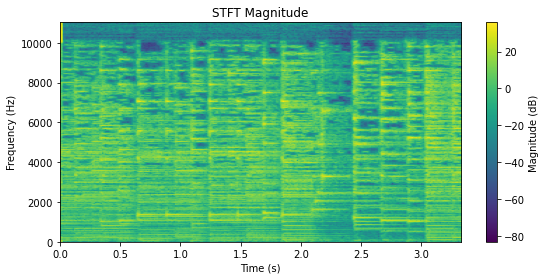

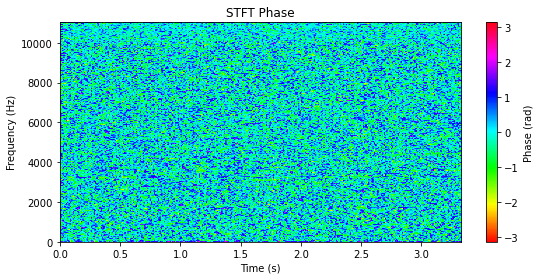

   🔧 Reconstructed STFT - Sample 1


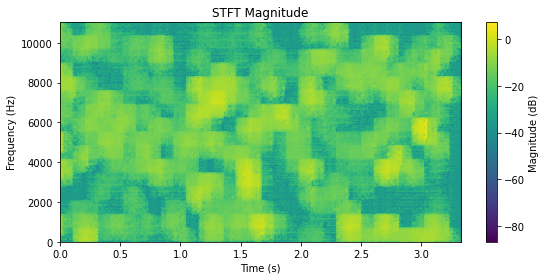

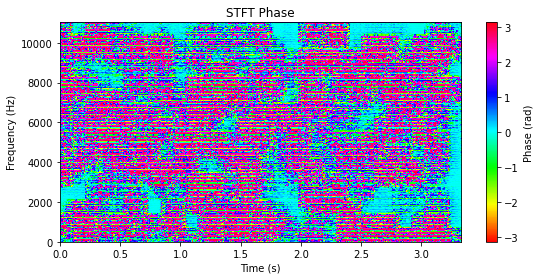

   📉 Reconstruction Error - Sample 1


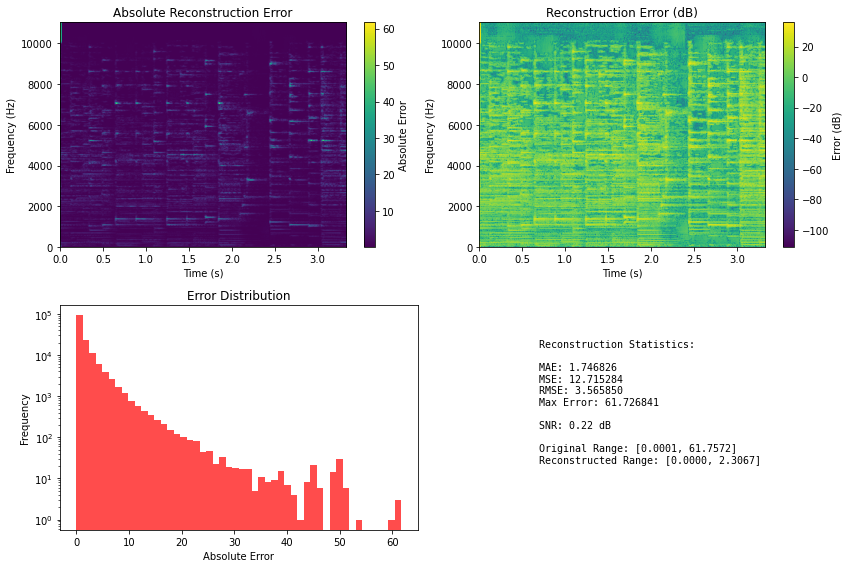


📈 Visualizing sample 2/5 (Label: 0)
   Section 0 - Original shape: torch.Size([2, 287, 513])
   Section 0 - Reconstructed shape: torch.Size([2, 287, 513])
   📊 Original STFT - Sample 2


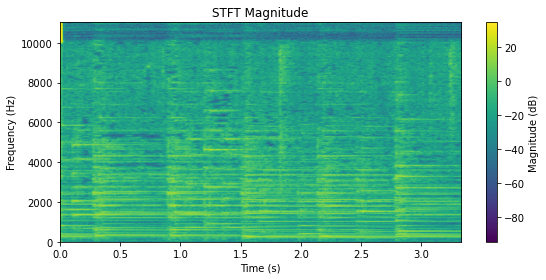

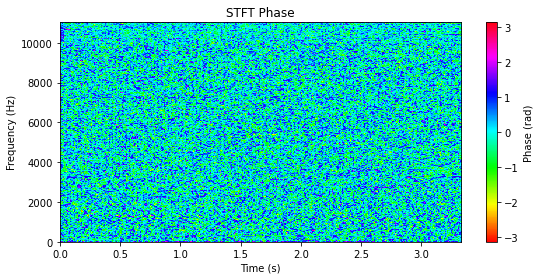

   🔧 Reconstructed STFT - Sample 2


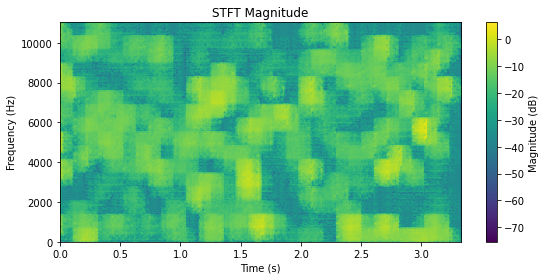

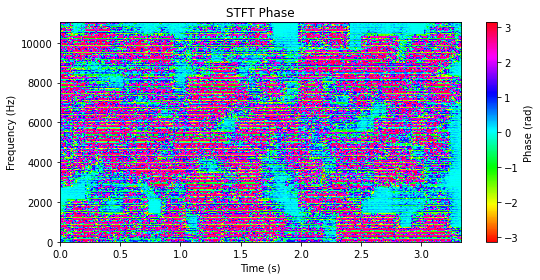

   📉 Reconstruction Error - Sample 2


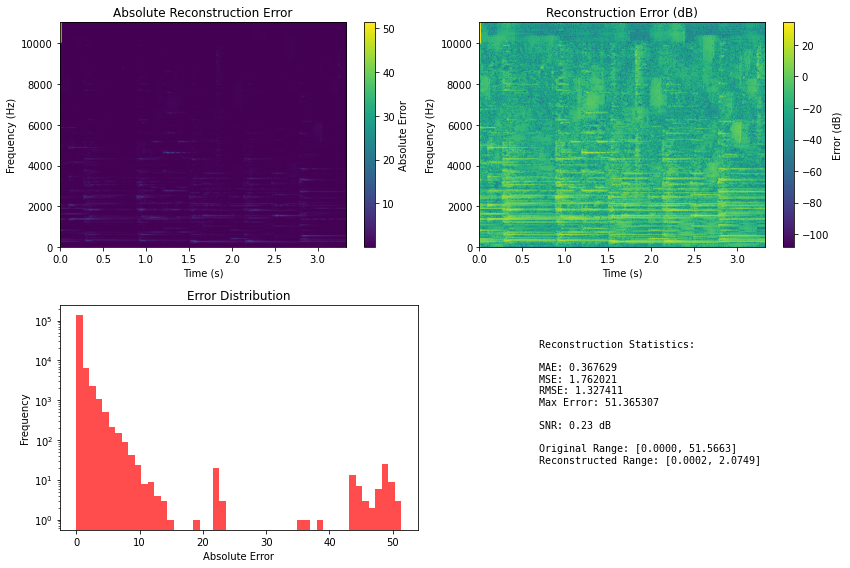


📈 Visualizing sample 3/5 (Label: 0)
   Section 0 - Original shape: torch.Size([2, 287, 513])
   Section 0 - Reconstructed shape: torch.Size([2, 287, 513])
   📊 Original STFT - Sample 3


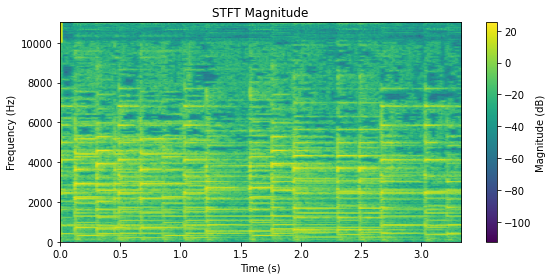

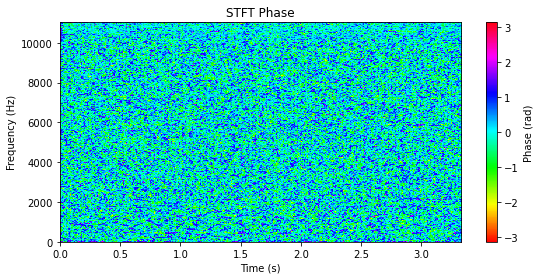

   🔧 Reconstructed STFT - Sample 3


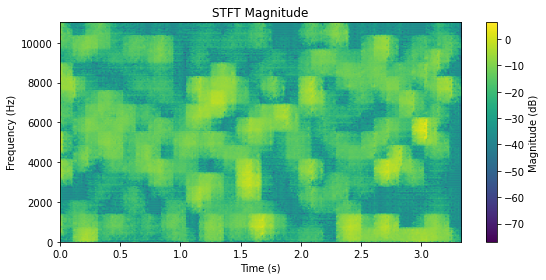

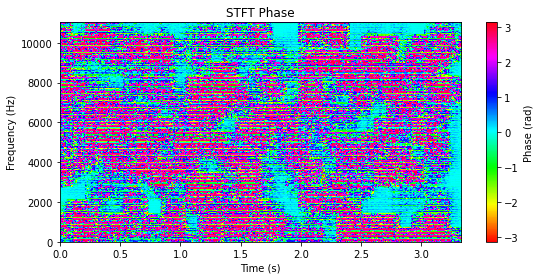

   📉 Reconstruction Error - Sample 3


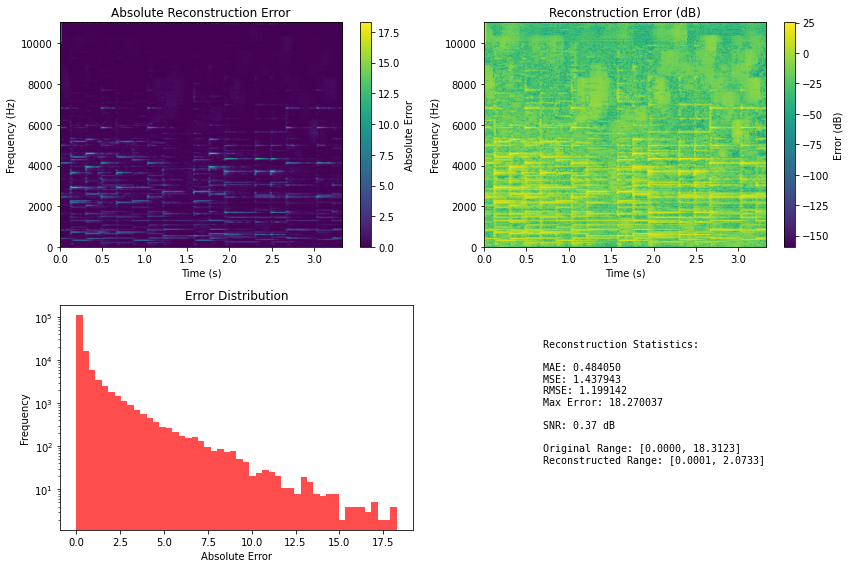


📈 Visualizing sample 4/5 (Label: 0)
   Section 0 - Original shape: torch.Size([2, 287, 513])
   Section 0 - Reconstructed shape: torch.Size([2, 287, 513])
   📊 Original STFT - Sample 4


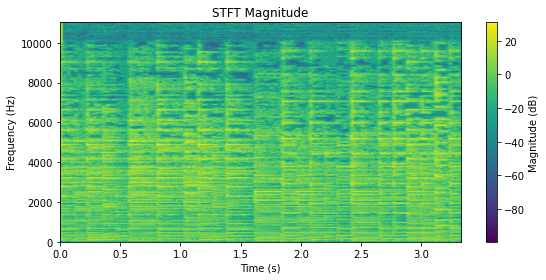

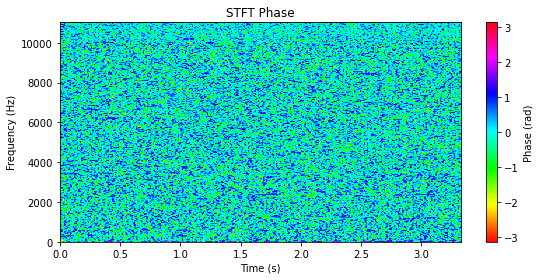

   🔧 Reconstructed STFT - Sample 4


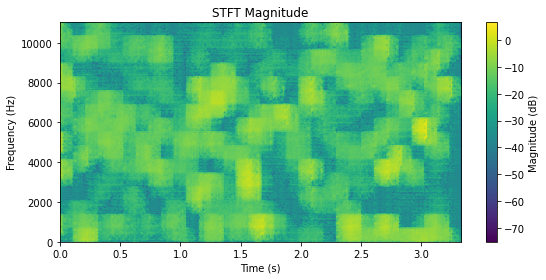

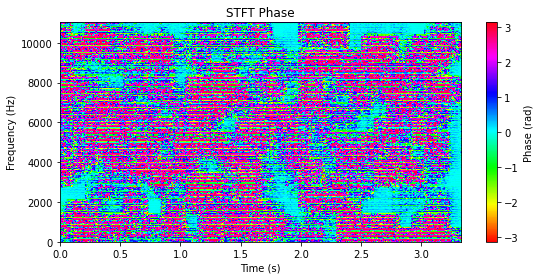

   📉 Reconstruction Error - Sample 4


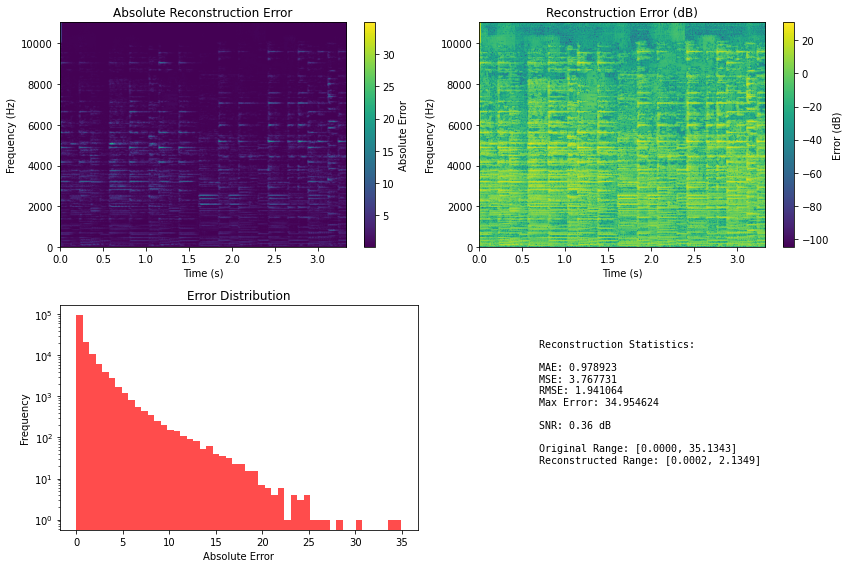


📈 Visualizing sample 5/5 (Label: 0)
   Section 0 - Original shape: torch.Size([2, 287, 513])
   Section 0 - Reconstructed shape: torch.Size([2, 287, 513])
   📊 Original STFT - Sample 5


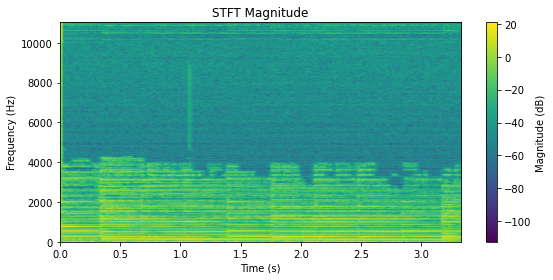

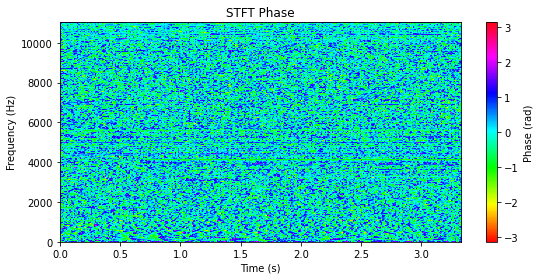

   🔧 Reconstructed STFT - Sample 5


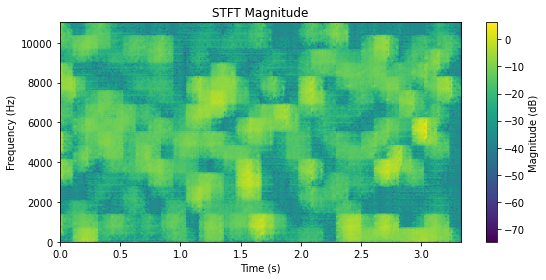

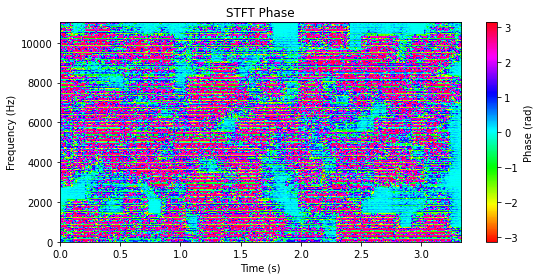

   📉 Reconstruction Error - Sample 5


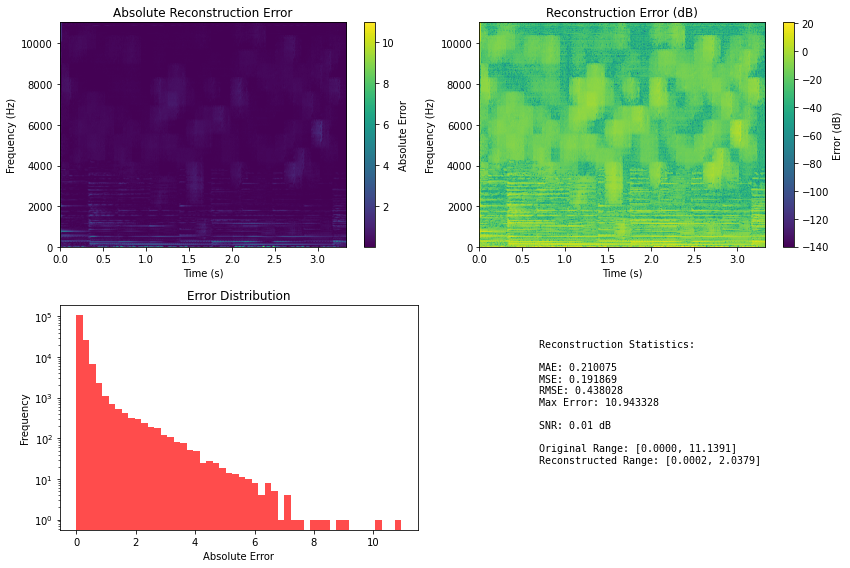

In [11]:
models_dict = {
    'style_encoder': style_encoder,
    'content_encoder': content_encoder,
    'decoder': decoder
}

train_loader = get_dataloader(
        piano_dir=config["piano_dir"],
        violin_dir=config["violin_dir"],
        batch_size=config["batch_size"],
        shuffle=True,
        stats_path=config["stats_path"]
    )

# Visualizza 3 campioni casuali
visualize_reconstruction(models_dict, train_loader, device, num_samples=5)
